# Logistic model1
- V0 Based on https://www.kaggle.com/anokas/talkingdata-mobile-user-demographics/sparse-xgboost-starter-2-26857
- V1 Hyperparameter optimization via HyperOpt
    - Min score: 2.274252(diff: 0.1) : alpha 2, lamba: 6, eta: 0.003 
    - Min score: 2.282447 (diff 0.043088): alpha: 6, eta: 0.002024, lambda: 6

Scores:
- V0: CV: 2.161099 / 2.274405, LB: 2.6855
- V1  CV: 2.169910 / 2.274244, LB: 2.26785

In [135]:
import os
import pickle
import time
import sys
import imp

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix, hstack
import xgboost as xgb
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import log_loss

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from ml_toolbox.kaggle import KaggleResult

%matplotlib inline


In [97]:
feat_dir = 'data'
data_dir = 'data_ori'
sub_dir = 'model_1_xgboost'

In [9]:
def open_feature_file(fname, samples='train'):
    if fname[-3:] == 'csv':
        if samples=='train':
            X = gatrain[['device_id']].merge( pd.read_csv(os.path.join(feat_dir, fname)), on='device_id', how='left')
        else:
            X = gatest[['device_id']].merge( pd.read_csv(os.path.join(feat_dir, fname)), on='device_id', how='left')
            
        X.drop('device_id', axis=1, inplace=True)
        X.fillna(0, inplace=True)
        
        for c in X.columns:
            if X[c].max()>1:
                #X[c] = StandardScaler().fit_transform(X)
                X[c] = MinMaxScaler().fit_transform(X)
                
        return csr_matrix(X.values)
    else:
        # Assume it is a pickle file
        with open(os.path.join(feat_dir, '{}_{}.pickle'.format(fname,samples)), 'rb') as f:
            return pickle.load(f)


In [10]:
feature_files = ['features_brand_model_bag',
                 'features_brand_bag',
                 'features_appid_installed',
                 'features_label_app_installed']

In [12]:
Xtrain = hstack([open_feature_file(f) for f in feature_files], format='csr')
Xtest = hstack([open_feature_file(f,'test') for f in feature_files], format='csr')
print('Xtrain shape:', Xtrain.shape, 'Xtest shape:', Xtest.shape)

('Xtrain shape:', (74645, 21527), 'Xtest shape:', (112071, 21527))


In [4]:
gatrain = pd.read_csv(os.path.join(data_dir,'gender_age_train.csv'))
gatest = pd.read_csv(os.path.join(data_dir,'gender_age_test.csv'))

targetencoder = LabelEncoder().fit(gatrain.group)
y = targetencoder.transform(gatrain.group)
nclasses = len(targetencoder.classes_)

In [89]:
params = {}
params['booster'] = 'gblinear'
params['objective'] = "multi:softprob"
params['eval_metric'] = 'mlogloss'
params['eta'] = 0.003
params['num_class'] = 12
params['lambda'] = 6
params['alpha'] = 2

In [90]:
kf = list(StratifiedKFold(y, n_folds=10, shuffle=True, random_state=4242))[0]

Xtr, Xte = Xtrain[kf[0], :], Xtrain[kf[1], :]
ytr, yte = y[kf[0]], y[kf[1]]

print('Training set: ' + str(Xtr.shape))
print('Validation set: ' + str(Xte.shape))

d_train = xgb.DMatrix(Xtr, label=ytr)
d_valid = xgb.DMatrix(Xte, label=yte)

watchlist = [(d_train, 'train'), (d_valid, 'eval')]

clf = xgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=25)



Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.472400	eval-mlogloss:2.472516
[1]	train-mlogloss:2.463079	eval-mlogloss:2.463364
[2]	train-mlogloss:2.455680	eval-mlogloss:2.456284
[3]	train-mlogloss:2.449705	eval-mlogloss:2.450579
[4]	train-mlogloss:2.444614	eval-mlogloss:2.445809
[5]	train-mlogloss:2.440212	eval-mlogloss:2.441712
[6]	train-mlogloss:2.436312	eval-mlogloss:2.438096
[7]	train-mlogloss:2.432737	eval-mlogloss:2.434854
[8]	train-mlogloss:2.429445	eval-mlogloss:2.431895
[9]	train-mlogloss:2.426318	eval-mlogloss:2.429144
[10]	train-mlogloss:2.423388	eval-mlogloss:2.426572
[11]	train-mlogloss:2.420566	eval-mlogloss:2.424154
[12]	train-mlogloss:2.417931	eval-mlogloss:2.421837
[13]	train-mlogloss:2.415346	eval-mlogloss:2.419641
[14]	train-mlogloss:2.412852	eval-mlogloss:2.417525
[15]	train-mlogloss:2.410440	eval-mlogloss:2.415489
[16]	train-mlogloss:2.408087	eval-mlogloss:2.413521
[17]	train-mlogloss:2.405809	eval-mlogloss:2.411630
[18]	train-mlog

In [95]:
cv_score = log_loss(yte, clf.predict(xgb.DMatrix(Xte)))
print('CV Score:', cv_score)

('CV Score:', 2.2742518182783571)


In [91]:
pred = clf.predict(xgb.DMatrix(Xtest))

pred = pd.DataFrame(pred, index = gatest.device_id, columns=targetencoder.classes_)
pred.head()
pred.to_csv('sparse_xgb.csv', index=True)

In [136]:
imp.reload(ml_toolbox.kaggle)

<module 'ml_toolbox.kaggle' from 'ml_toolbox/kaggle.pyc'>

In [137]:
kag = KaggleResult(pred, cv_score=cv_score, description='XGBoost Model 1', subdir=sub_dir)

In [ ]:
if kag.validate():
    #kag.upload()
print kag.lb_score

In [18]:
pred.head()

F23-    F24-26    F27-28    F29-32    F33-42  \
device_id                                                                
 1002079943728939269  0.000961  0.005293  0.016644  0.009958  0.034455   
-1547860181818787117  0.007001  0.018102  0.025414  0.049749  0.061766   
 7374582448058474277  0.036303  0.044443  0.050729  0.173322  0.167783   
-6220210354783429585  0.002589  0.028331  0.007547  0.015236  0.051230   
-5893464122623104785  0.043169  0.067403  0.048709  0.065777  0.059606   

                          F43+      M22-    M23-26    M27-28    M29-31  \
device_id                                                                
 1002079943728939269  0.054225  0.015596  0.041634  0.062057  0.161845   
-1547860181818787117  0.127055  0.004657  0.083989  0.071397  0.104567   
 7374582448058474277  0.066788  0.017566  0.029176  0.054360  0.085741   
-6220210354783429585  0.102467  0.068093  0.135229  0.072710  0.122682   
-5893464122623104785  0.046219  0.081174  0.154101  0.098054  0.101682   

                        M32-38      M39+  
device_id                                 
 1002079943728939269  0.285192  0.312142  
-1547860181818787117  0.224146  0.222157  
 7374582448058474277  0.163620  0.110169  
-6220210354783429585  0.217205  0.176683  
-5893464122623104785  0.142798  0.091308

## HyperOpt optimization loop

In [45]:
def f_nn(params):
    global counter
    global times
    
    a = time.time()
    
    # create model
    print ('Params testing %d: %s' % (counter, params))
    counter += 1
    
    kf = list(StratifiedKFold(y, n_folds=10, shuffle=True, random_state=4242))[0]

    Xtr, Xte = Xtrain[kf[0], :], Xtrain[kf[1], :]
    ytr, yte = y[kf[0]], y[kf[1]]

    print('Training set: ' + str(Xtr.shape))
    print('Validation set: ' + str(Xte.shape))

    d_train = xgb.DMatrix(Xtr, label=ytr)
    d_valid = xgb.DMatrix(Xte, label=yte)

    watchlist = [(d_train, 'train'), (d_valid, 'eval')]

    clf = xgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=25)

    logloss_tr = log_loss(ytr, clf.predict(xgb.DMatrix(Xtr)))
    logloss_te = log_loss(yte, clf.predict(xgb.DMatrix(Xte)))
    times.append(a-time.time())
                        
    print('Log_loss:', logloss_te, 'It took', a-time.time())
    print('Average time per eval:', sum(times)/counter)
    sys.stdout.flush() 
    return {'loss': logloss_te, 'status': STATUS_OK, 'loss_train': logloss_tr}

In [46]:
params['booster'] = 'gblinear'
params['objective'] = "multi:softprob"
params['eval_metric'] = 'mlogloss'
params['eta'] = hp.loguniform('eta', -7, -2)
params['num_class'] = 12
params['lambda'] = hp.randint('lambda', 7)
params['alpha'] = hp.randint('alpha', 7)

In [49]:
counter = 0
times = []
trials = Trials()
best = fmin(f_nn, params, algo=tpe.suggest, max_evals=300, trials=trials)
print 'best: '
print best

Params testing 0: {'eta': 0.03221821196364413, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 6, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.428135	eval-mlogloss:2.430982
[1]	train-mlogloss:2.399961	eval-mlogloss:2.406765
[2]	train-mlogloss:2.379453	eval-mlogloss:2.390042
[3]	train-mlogloss:2.363003	eval-mlogloss:2.377174
[4]	train-mlogloss:2.349138	eval-mlogloss:2.366702
[5]	train-mlogloss:2.337141	eval-mlogloss:2.357920
[6]	train-mlogloss:2.326591	eval-mlogloss:2.350392
[7]	train-mlogloss:2.317232	eval-mlogloss:2.343835
[8]	train-mlogloss:2.308718	eval-mlogloss:2.338050
[9]	train-mlogloss:2.301028	eval-mlogloss:2.332908
[10]	train-mlogloss:2.293893	eval-mlogloss:2.328296
[11]	train-mlogloss:2.287392	eval-mlogloss:2.324127
[12]	train-mlogloss:2.281353	eval-mlogloss:2.320357
[13]	train-mlogloss:2.275793	eval-mlogloss:2.316918
[14]	train-mlogloss:2.270547	eval-mlogloss:2.313775
[15]	train-mlogloss:2.265706	eval-mlogloss:2.310883
[16]	train-mlogloss:2.261109	eval-mlogloss:2.308233
[17]	train-mlogloss:2.256826	eval-mlogloss:2.305799
[18]	train-mlog

('Log_loss:', 2.2749240206713388, 'It took', -105.18056392669678)
('Average time per eval:', -105.18056201934814)
Params testing 1: {'eta': 0.029863732740448706, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 6, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.430293	eval-mlogloss:2.432939
[1]	train-mlogloss:2.403213	eval-mlogloss:2.409454
[2]	train-mlogloss:2.383378	eval-mlogloss:2.393168
[3]	train-mlogloss:2.367412	eval-mlogloss:2.380563
[4]	train-mlogloss:2.353862	eval-mlogloss:2.370270
[5]	train-mlogloss:2.342167	eval-mlogloss:2.361584
[6]	train-mlogloss:2.331809	eval-mlogloss:2.354112
[7]	train-mlogloss:2.322500	eval-mlogloss:2.347580
[8]	train-mlogloss:2.314152	eval-mlogloss:2.341791
[9]	train-mlogloss:2.306550	eval-mlogloss:2.336632
[10]	train-mlogloss:2.299592	eval-mlogloss:2.331990
[11]	train-mlogloss:2.293078	eval-mlogloss:2.327784
[12]	train-mlogloss:2.287110	eval-mlogloss:2.323963
[13]	train-mlogloss:2.281534	eval-mlogloss:2.320467
[14]	train-mlogloss:2.276374	eval-mlogloss:2.317265
[15]	train-mlogloss:2.271414	eval-mlogloss:2.314314
[16]	train-mlogloss:2.266863	eval-mlogloss:2.311606
[17]	train-mlogloss:2.262576	eval-mlogloss:2.309073
[18]	train-mlog

('Log_loss:', 2.2748788888848623, 'It took', -110.66260600090027)
('Average time per eval:', -107.92158353328705)
Params testing 2: {'eta': 0.12367115346621922, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 3, 'lambda': 5, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.375331	eval-mlogloss:2.386145
[1]	train-mlogloss:2.330373	eval-mlogloss:2.351022
[2]	train-mlogloss:2.301446	eval-mlogloss:2.329971
[3]	train-mlogloss:2.280699	eval-mlogloss:2.316010
[4]	train-mlogloss:2.265001	eval-mlogloss:2.306149
[5]	train-mlogloss:2.252605	eval-mlogloss:2.298910
[6]	train-mlogloss:2.242567	eval-mlogloss:2.293434
[7]	train-mlogloss:2.234283	eval-mlogloss:2.289233
[8]	train-mlogloss:2.227323	eval-mlogloss:2.285978
[9]	train-mlogloss:2.221446	eval-mlogloss:2.283423
[10]	train-mlogloss:2.216408	eval-mlogloss:2.281420
[11]	train-mlogloss:2.212026	eval-mlogloss:2.279837
[12]	train-mlogloss:2.208193	eval-mlogloss:2.278591
[13]	train-mlogloss:2.204892	eval-mlogloss:2.277627
[14]	train-mlogloss:2.201925	eval-mlogloss:2.276865
[15]	train-mlogloss:2.199350	eval-mlogloss:2.276274
[16]	train-mlogloss:2.197026	eval-mlogloss:2.275836
[17]	train-mlogloss:2.194960	eval-mlogloss:2.275501
[18]	train-mlog

('Log_loss:', 2.2771996608920957, 'It took', -51.80766010284424)
('Average time per eval:', -89.21694199244182)
Params testing 3: {'eta': 0.11308864330598596, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 1, 'lambda': 6, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.368590	eval-mlogloss:2.385514
[1]	train-mlogloss:2.316904	eval-mlogloss:2.349251
[2]	train-mlogloss:2.282148	eval-mlogloss:2.327421
[3]	train-mlogloss:2.256389	eval-mlogloss:2.312927
[4]	train-mlogloss:2.236201	eval-mlogloss:2.302783
[5]	train-mlogloss:2.219922	eval-mlogloss:2.295420
[6]	train-mlogloss:2.206564	eval-mlogloss:2.289977
[7]	train-mlogloss:2.195220	eval-mlogloss:2.285915
[8]	train-mlogloss:2.185574	eval-mlogloss:2.282864
[9]	train-mlogloss:2.177269	eval-mlogloss:2.280583
[10]	train-mlogloss:2.170106	eval-mlogloss:2.278884
[11]	train-mlogloss:2.163784	eval-mlogloss:2.277646
[12]	train-mlogloss:2.158253	eval-mlogloss:2.276761
[13]	train-mlogloss:2.153355	eval-mlogloss:2.276151
[14]	train-mlogloss:2.149016	eval-mlogloss:2.275752
[15]	train-mlogloss:2.145127	eval-mlogloss:2.275542
[16]	train-mlogloss:2.141644	eval-mlogloss:2.275467
[17]	train-mlogloss:2.138514	eval-mlogloss:2.275499
[18]	train-mlog

('Log_loss:', 2.2832971130011956, 'It took', -46.54990792274475)
('Average time per eval:', -78.55018323659897)
Params testing 4: {'eta': 0.001200602604067276, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 4, 'lambda': 1, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.479159	eval-mlogloss:2.479366
[1]	train-mlogloss:2.474442	eval-mlogloss:2.474544
[2]	train-mlogloss:2.470224	eval-mlogloss:2.470307
[3]	train-mlogloss:2.466405	eval-mlogloss:2.466544
[4]	train-mlogloss:2.463011	eval-mlogloss:2.463190
[5]	train-mlogloss:2.459916	eval-mlogloss:2.460162
[6]	train-mlogloss:2.457092	eval-mlogloss:2.457423
[7]	train-mlogloss:2.454448	eval-mlogloss:2.454939
[8]	train-mlogloss:2.452107	eval-mlogloss:2.452641
[9]	train-mlogloss:2.449927	eval-mlogloss:2.450531
[10]	train-mlogloss:2.447868	eval-mlogloss:2.448574
[11]	train-mlogloss:2.445922	eval-mlogloss:2.446747
[12]	train-mlogloss:2.444096	eval-mlogloss:2.445037
[13]	train-mlogloss:2.442407	eval-mlogloss:2.443432
[14]	train-mlogloss:2.440781	eval-mlogloss:2.441906
[15]	train-mlogloss:2.439247	eval-mlogloss:2.440460
[16]	train-mlogloss:2.437781	eval-mlogloss:2.439085
[17]	train-mlogloss:2.436387	eval-mlogloss:2.437768
[18]	train-mlog

('Log_loss:', 2.2858335273326627, 'It took', -1002.1937470436096)
('Average time per eval:', -263.27889556884764)
Params testing 5: {'eta': 0.0788739122888725, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 2, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.389762	eval-mlogloss:2.400260
[1]	train-mlogloss:2.346460	eval-mlogloss:2.367053
[2]	train-mlogloss:2.316635	eval-mlogloss:2.345968
[3]	train-mlogloss:2.294106	eval-mlogloss:2.331093
[4]	train-mlogloss:2.276096	eval-mlogloss:2.319995
[5]	train-mlogloss:2.261216	eval-mlogloss:2.311384
[6]	train-mlogloss:2.248594	eval-mlogloss:2.304544
[7]	train-mlogloss:2.237769	eval-mlogloss:2.299020
[8]	train-mlogloss:2.228321	eval-mlogloss:2.294509
[9]	train-mlogloss:2.220032	eval-mlogloss:2.290796
[10]	train-mlogloss:2.212732	eval-mlogloss:2.287726
[11]	train-mlogloss:2.206170	eval-mlogloss:2.285180
[12]	train-mlogloss:2.200300	eval-mlogloss:2.283069
[13]	train-mlogloss:2.194952	eval-mlogloss:2.281317
[14]	train-mlogloss:2.190173	eval-mlogloss:2.279864
[15]	train-mlogloss:2.185844	eval-mlogloss:2.278668
[16]	train-mlogloss:2.181842	eval-mlogloss:2.277701
[17]	train-mlogloss:2.178224	eval-mlogloss:2.276900
[18]	train-mlog

('Log_loss:', 2.2799054266113581, 'It took', -53.820712089538574)
('Average time per eval:', -228.36919812361398)
Params testing 6: {'eta': 0.020602470658167664, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 6, 'lambda': 0, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.442469	eval-mlogloss:2.443205
[1]	train-mlogloss:2.422322	eval-mlogloss:2.424383
[2]	train-mlogloss:2.407668	eval-mlogloss:2.411328
[3]	train-mlogloss:2.396013	eval-mlogloss:2.401040
[4]	train-mlogloss:2.385973	eval-mlogloss:2.392449
[5]	train-mlogloss:2.377200	eval-mlogloss:2.385043
[6]	train-mlogloss:2.369403	eval-mlogloss:2.378547
[7]	train-mlogloss:2.362404	eval-mlogloss:2.372751
[8]	train-mlogloss:2.356108	eval-mlogloss:2.367541
[9]	train-mlogloss:2.350227	eval-mlogloss:2.362823
[10]	train-mlogloss:2.344874	eval-mlogloss:2.358516
[11]	train-mlogloss:2.339918	eval-mlogloss:2.354550
[12]	train-mlogloss:2.335368	eval-mlogloss:2.350889
[13]	train-mlogloss:2.330978	eval-mlogloss:2.347500
[14]	train-mlogloss:2.327002	eval-mlogloss:2.344328
[15]	train-mlogloss:2.323269	eval-mlogloss:2.341381
[16]	train-mlogloss:2.319699	eval-mlogloss:2.338622
[17]	train-mlogloss:2.316292	eval-mlogloss:2.336029
[18]	train-mlog

('Log_loss:', 2.2762299289172252, 'It took', -250.01013016700745)
('Average time per eval:', -231.4607596737998)
Params testing 7: {'eta': 0.09609134985166595, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 3, 'lambda': 1, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.384046	eval-mlogloss:2.394260
[1]	train-mlogloss:2.340911	eval-mlogloss:2.360389
[2]	train-mlogloss:2.312219	eval-mlogloss:2.339388
[3]	train-mlogloss:2.291092	eval-mlogloss:2.324904
[4]	train-mlogloss:2.274553	eval-mlogloss:2.314300
[5]	train-mlogloss:2.261269	eval-mlogloss:2.306247
[6]	train-mlogloss:2.250193	eval-mlogloss:2.299941
[7]	train-mlogloss:2.240881	eval-mlogloss:2.294936
[8]	train-mlogloss:2.232825	eval-mlogloss:2.290921
[9]	train-mlogloss:2.225903	eval-mlogloss:2.287666
[10]	train-mlogloss:2.219862	eval-mlogloss:2.285021
[11]	train-mlogloss:2.214577	eval-mlogloss:2.282859
[12]	train-mlogloss:2.209882	eval-mlogloss:2.281101
[13]	train-mlogloss:2.205638	eval-mlogloss:2.279667
[14]	train-mlogloss:2.201837	eval-mlogloss:2.278498
[15]	train-mlogloss:2.198514	eval-mlogloss:2.277552
[16]	train-mlogloss:2.195361	eval-mlogloss:2.276798
[17]	train-mlogloss:2.192675	eval-mlogloss:2.276191
[18]	train-mlog

('Log_loss:', 2.2784513370625223, 'It took', -52.17339110374451)
('Average time per eval:', -209.04983833432198)
Params testing 8: {'eta': 0.04447325263391285, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 1, 'lambda': 3, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.411090	eval-mlogloss:2.418849
[1]	train-mlogloss:2.373985	eval-mlogloss:2.390058
[2]	train-mlogloss:2.346794	eval-mlogloss:2.370667
[3]	train-mlogloss:2.325213	eval-mlogloss:2.356203
[4]	train-mlogloss:2.307016	eval-mlogloss:2.344785
[5]	train-mlogloss:2.291419	eval-mlogloss:2.335468
[6]	train-mlogloss:2.277836	eval-mlogloss:2.327687
[7]	train-mlogloss:2.265583	eval-mlogloss:2.321073
[8]	train-mlogloss:2.254676	eval-mlogloss:2.315392
[9]	train-mlogloss:2.244713	eval-mlogloss:2.310479
[10]	train-mlogloss:2.235735	eval-mlogloss:2.306193
[11]	train-mlogloss:2.227449	eval-mlogloss:2.302430
[12]	train-mlogloss:2.219783	eval-mlogloss:2.299123
[13]	train-mlogloss:2.212799	eval-mlogloss:2.296209
[14]	train-mlogloss:2.206234	eval-mlogloss:2.293638
[15]	train-mlogloss:2.200197	eval-mlogloss:2.291353
[16]	train-mlogloss:2.194468	eval-mlogloss:2.289325
[17]	train-mlogloss:2.189180	eval-mlogloss:2.287528
[18]	train-mlog

('Log_loss:', 2.2803643178754629, 'It took', -65.09560298919678)
('Average time per eval:', -193.05492297808328)
Params testing 9: {'eta': 0.0013758738687971786, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 1, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.478099	eval-mlogloss:2.478346
[1]	train-mlogloss:2.472522	eval-mlogloss:2.472750
[2]	train-mlogloss:2.467577	eval-mlogloss:2.467907
[3]	train-mlogloss:2.463188	eval-mlogloss:2.463683
[4]	train-mlogloss:2.459285	eval-mlogloss:2.459957
[5]	train-mlogloss:2.455788	eval-mlogloss:2.456617
[6]	train-mlogloss:2.452544	eval-mlogloss:2.453632
[7]	train-mlogloss:2.449681	eval-mlogloss:2.450912
[8]	train-mlogloss:2.447025	eval-mlogloss:2.448428
[9]	train-mlogloss:2.444507	eval-mlogloss:2.446147
[10]	train-mlogloss:2.442177	eval-mlogloss:2.444024
[11]	train-mlogloss:2.440024	eval-mlogloss:2.442047
[12]	train-mlogloss:2.437958	eval-mlogloss:2.440189
[13]	train-mlogloss:2.436025	eval-mlogloss:2.438436
[14]	train-mlogloss:2.434180	eval-mlogloss:2.436773
[15]	train-mlogloss:2.432383	eval-mlogloss:2.435201
[16]	train-mlogloss:2.430702	eval-mlogloss:2.433684
[17]	train-mlogloss:2.429032	eval-mlogloss:2.432236
[18]	train-mlog

('Log_loss:', 2.2770182420818212, 'It took', -981.4988279342651)
('Average time per eval:', -271.89931337833406)
Params testing 10: {'eta': 0.005592855080437963, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 1, 'lambda': 1, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.462612	eval-mlogloss:2.463574
[1]	train-mlogloss:2.448312	eval-mlogloss:2.450485
[2]	train-mlogloss:2.437699	eval-mlogloss:2.441144
[3]	train-mlogloss:2.429120	eval-mlogloss:2.433801
[4]	train-mlogloss:2.421638	eval-mlogloss:2.427664
[5]	train-mlogloss:2.414878	eval-mlogloss:2.422300
[6]	train-mlogloss:2.408754	eval-mlogloss:2.417466
[7]	train-mlogloss:2.402962	eval-mlogloss:2.413053
[8]	train-mlogloss:2.397525	eval-mlogloss:2.408957
[9]	train-mlogloss:2.392338	eval-mlogloss:2.405117
[10]	train-mlogloss:2.387376	eval-mlogloss:2.401511
[11]	train-mlogloss:2.382654	eval-mlogloss:2.398099
[12]	train-mlogloss:2.378121	eval-mlogloss:2.394866
[13]	train-mlogloss:2.373745	eval-mlogloss:2.391794
[14]	train-mlogloss:2.369618	eval-mlogloss:2.388856
[15]	train-mlogloss:2.365551	eval-mlogloss:2.386059
[16]	train-mlogloss:2.361596	eval-mlogloss:2.383381
[17]	train-mlogloss:2.357792	eval-mlogloss:2.380818
[18]	train-mlog

('Log_loss:', 2.2776103868562076, 'It took', -281.43761801719666)
('Average time per eval:', -272.7664318951693)
Params testing 11: {'eta': 0.0026598022365001764, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 3, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.473284	eval-mlogloss:2.473446
[1]	train-mlogloss:2.464452	eval-mlogloss:2.464776
[2]	train-mlogloss:2.457323	eval-mlogloss:2.457953
[3]	train-mlogloss:2.451460	eval-mlogloss:2.452379
[4]	train-mlogloss:2.446460	eval-mlogloss:2.447701
[5]	train-mlogloss:2.442092	eval-mlogloss:2.443665
[6]	train-mlogloss:2.438202	eval-mlogloss:2.440114
[7]	train-mlogloss:2.434715	eval-mlogloss:2.436924
[8]	train-mlogloss:2.431463	eval-mlogloss:2.434009
[9]	train-mlogloss:2.428423	eval-mlogloss:2.431322
[10]	train-mlogloss:2.425520	eval-mlogloss:2.428806
[11]	train-mlogloss:2.422803	eval-mlogloss:2.426438
[12]	train-mlogloss:2.420167	eval-mlogloss:2.424203
[13]	train-mlogloss:2.417680	eval-mlogloss:2.422069
[14]	train-mlogloss:2.415249	eval-mlogloss:2.420022
[15]	train-mlogloss:2.412924	eval-mlogloss:2.418048
[16]	train-mlogloss:2.410655	eval-mlogloss:2.416139
[17]	train-mlogloss:2.408426	eval-mlogloss:2.414309
[18]	train-mlog

('Log_loss:', 2.2744399422383408, 'It took', -843.1221270561218)
('Average time per eval:', -320.2960730791092)
Params testing 12: {'eta': 0.004693735655711183, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 4, 'lambda': 3, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.467544	eval-mlogloss:2.467623
[1]	train-mlogloss:2.455996	eval-mlogloss:2.456395
[2]	train-mlogloss:2.447600	eval-mlogloss:2.448262
[3]	train-mlogloss:2.440941	eval-mlogloss:2.441942
[4]	train-mlogloss:2.435349	eval-mlogloss:2.436723
[5]	train-mlogloss:2.430467	eval-mlogloss:2.432218
[6]	train-mlogloss:2.426037	eval-mlogloss:2.428226
[7]	train-mlogloss:2.422014	eval-mlogloss:2.424582
[8]	train-mlogloss:2.418250	eval-mlogloss:2.421229
[9]	train-mlogloss:2.414675	eval-mlogloss:2.418093
[10]	train-mlogloss:2.411269	eval-mlogloss:2.415140
[11]	train-mlogloss:2.408051	eval-mlogloss:2.412333
[12]	train-mlogloss:2.404909	eval-mlogloss:2.409672
[13]	train-mlogloss:2.401903	eval-mlogloss:2.407114
[14]	train-mlogloss:2.399004	eval-mlogloss:2.404680
[15]	train-mlogloss:2.396286	eval-mlogloss:2.402327
[16]	train-mlogloss:2.393610	eval-mlogloss:2.400079
[17]	train-mlogloss:2.391042	eval-mlogloss:2.397913
[18]	train-mlog

('Log_loss:', 2.2751926797150235, 'It took', -737.0856900215149)
('Average time per eval:', -352.3568127522102)
Params testing 13: {'eta': 0.0019128502769655805, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 6, 'lambda': 1, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.476669	eval-mlogloss:2.476776
[1]	train-mlogloss:2.470184	eval-mlogloss:2.470176
[2]	train-mlogloss:2.464656	eval-mlogloss:2.464709
[3]	train-mlogloss:2.459992	eval-mlogloss:2.460079
[4]	train-mlogloss:2.455877	eval-mlogloss:2.456115
[5]	train-mlogloss:2.452346	eval-mlogloss:2.452639
[6]	train-mlogloss:2.449227	eval-mlogloss:2.449575
[7]	train-mlogloss:2.446335	eval-mlogloss:2.446847
[8]	train-mlogloss:2.443732	eval-mlogloss:2.444358
[9]	train-mlogloss:2.441353	eval-mlogloss:2.442092
[10]	train-mlogloss:2.439162	eval-mlogloss:2.439987
[11]	train-mlogloss:2.437091	eval-mlogloss:2.438029
[12]	train-mlogloss:2.435167	eval-mlogloss:2.436203
[13]	train-mlogloss:2.433311	eval-mlogloss:2.434471
[14]	train-mlogloss:2.431542	eval-mlogloss:2.432821
[15]	train-mlogloss:2.429801	eval-mlogloss:2.431255
[16]	train-mlogloss:2.428179	eval-mlogloss:2.429745
[17]	train-mlogloss:2.426615	eval-mlogloss:2.428302
[18]	train-mlog

('Log_loss:', 2.2817988285957203, 'It took', -973.8753199577332)
('Average time per eval:', -396.7509916850499)
Params testing 14: {'eta': 0.011455676693317565, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 3, 'lambda': 6, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.453314	eval-mlogloss:2.453822
[1]	train-mlogloss:2.436740	eval-mlogloss:2.438130
[2]	train-mlogloss:2.424725	eval-mlogloss:2.427274
[3]	train-mlogloss:2.415094	eval-mlogloss:2.418683
[4]	train-mlogloss:2.406623	eval-mlogloss:2.411388
[5]	train-mlogloss:2.399036	eval-mlogloss:2.404971
[6]	train-mlogloss:2.392166	eval-mlogloss:2.399211
[7]	train-mlogloss:2.385803	eval-mlogloss:2.393962
[8]	train-mlogloss:2.379877	eval-mlogloss:2.389158
[9]	train-mlogloss:2.374413	eval-mlogloss:2.384722
[10]	train-mlogloss:2.369275	eval-mlogloss:2.380600
[11]	train-mlogloss:2.364402	eval-mlogloss:2.376761
[12]	train-mlogloss:2.359823	eval-mlogloss:2.373184
[13]	train-mlogloss:2.355525	eval-mlogloss:2.369814
[14]	train-mlogloss:2.351444	eval-mlogloss:2.366638
[15]	train-mlogloss:2.347594	eval-mlogloss:2.363637
[16]	train-mlogloss:2.343887	eval-mlogloss:2.360794
[17]	train-mlogloss:2.340302	eval-mlogloss:2.358108
[18]	train-mlog

('Log_loss:', 2.274686171631342, 'It took', -284.3235650062561)
('Average time per eval:', -389.25582982699075)
Params testing 15: {'eta': 0.051968552881131516, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 5, 'lambda': 2, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.416730	eval-mlogloss:2.419761
[1]	train-mlogloss:2.385582	eval-mlogloss:2.392470
[2]	train-mlogloss:2.364064	eval-mlogloss:2.374383
[3]	train-mlogloss:2.347514	eval-mlogloss:2.360986
[4]	train-mlogloss:2.334146	eval-mlogloss:2.350455
[5]	train-mlogloss:2.323008	eval-mlogloss:2.341853
[6]	train-mlogloss:2.313482	eval-mlogloss:2.334666
[7]	train-mlogloss:2.305211	eval-mlogloss:2.328523
[8]	train-mlogloss:2.297906	eval-mlogloss:2.323231
[9]	train-mlogloss:2.291467	eval-mlogloss:2.318611
[10]	train-mlogloss:2.285739	eval-mlogloss:2.314556
[11]	train-mlogloss:2.280521	eval-mlogloss:2.310953
[12]	train-mlogloss:2.275827	eval-mlogloss:2.307746
[13]	train-mlogloss:2.271546	eval-mlogloss:2.304885
[14]	train-mlogloss:2.267555	eval-mlogloss:2.302313
[15]	train-mlogloss:2.263996	eval-mlogloss:2.299989
[16]	train-mlogloss:2.260738	eval-mlogloss:2.297888
[17]	train-mlogloss:2.257593	eval-mlogloss:2.295992
[18]	train-mlog

('Log_loss:', 2.275788909034929, 'It took', -106.90940594673157)
('Average time per eval:', -371.6091782748699)
Params testing 16: {'eta': 0.002321542733321976, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 4, 'lambda': 4, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.475070	eval-mlogloss:2.475140
[1]	train-mlogloss:2.467427	eval-mlogloss:2.467505
[2]	train-mlogloss:2.461210	eval-mlogloss:2.461360
[3]	train-mlogloss:2.455916	eval-mlogloss:2.456273
[4]	train-mlogloss:2.451517	eval-mlogloss:2.451957
[5]	train-mlogloss:2.447617	eval-mlogloss:2.448237
[6]	train-mlogloss:2.444151	eval-mlogloss:2.444954
[7]	train-mlogloss:2.441040	eval-mlogloss:2.442039
[8]	train-mlogloss:2.438278	eval-mlogloss:2.439367
[9]	train-mlogloss:2.435645	eval-mlogloss:2.436937
[10]	train-mlogloss:2.433205	eval-mlogloss:2.434669
[11]	train-mlogloss:2.430915	eval-mlogloss:2.432549
[12]	train-mlogloss:2.428702	eval-mlogloss:2.430549
[13]	train-mlogloss:2.426593	eval-mlogloss:2.428645
[14]	train-mlogloss:2.424570	eval-mlogloss:2.426833
[15]	train-mlogloss:2.422611	eval-mlogloss:2.425095
[16]	train-mlogloss:2.420749	eval-mlogloss:2.423417
[17]	train-mlogloss:2.418946	eval-mlogloss:2.421801
[18]	train-mlog

('Log_loss:', 2.2766256551002026, 'It took', -974.8101511001587)
('Average time per eval:', -407.0915883148418)
Params testing 17: {'eta': 0.0022745697389690966, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 6, 'lambda': 0, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.475329	eval-mlogloss:2.475396
[1]	train-mlogloss:2.467925	eval-mlogloss:2.467945
[2]	train-mlogloss:2.461860	eval-mlogloss:2.461931
[3]	train-mlogloss:2.456721	eval-mlogloss:2.456947
[4]	train-mlogloss:2.452405	eval-mlogloss:2.452725
[5]	train-mlogloss:2.448664	eval-mlogloss:2.449093
[6]	train-mlogloss:2.445291	eval-mlogloss:2.445885
[7]	train-mlogloss:2.442293	eval-mlogloss:2.443027
[8]	train-mlogloss:2.439609	eval-mlogloss:2.440433
[9]	train-mlogloss:2.437085	eval-mlogloss:2.438059
[10]	train-mlogloss:2.434753	eval-mlogloss:2.435864
[11]	train-mlogloss:2.432520	eval-mlogloss:2.433815
[12]	train-mlogloss:2.430436	eval-mlogloss:2.431879
[13]	train-mlogloss:2.428429	eval-mlogloss:2.430034
[14]	train-mlogloss:2.426507	eval-mlogloss:2.428286
[15]	train-mlogloss:2.424680	eval-mlogloss:2.426612
[16]	train-mlogloss:2.422912	eval-mlogloss:2.424989
[17]	train-mlogloss:2.421184	eval-mlogloss:2.423430
[18]	train-mlog

('Log_loss:', 2.2793167435577444, 'It took', -981.2300808429718)
('Average time per eval:', -438.9881711800893)
Params testing 18: {'eta': 0.0054119485479170535, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 3, 'lambda': 6, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.465580	eval-mlogloss:2.465726
[1]	train-mlogloss:2.453229	eval-mlogloss:2.453736
[2]	train-mlogloss:2.444243	eval-mlogloss:2.445218
[3]	train-mlogloss:2.437229	eval-mlogloss:2.438590
[4]	train-mlogloss:2.431277	eval-mlogloss:2.433096
[5]	train-mlogloss:2.425959	eval-mlogloss:2.428330
[6]	train-mlogloss:2.421180	eval-mlogloss:2.424072
[7]	train-mlogloss:2.416777	eval-mlogloss:2.420173
[8]	train-mlogloss:2.412595	eval-mlogloss:2.416572
[9]	train-mlogloss:2.408663	eval-mlogloss:2.413193
[10]	train-mlogloss:2.404932	eval-mlogloss:2.410004
[11]	train-mlogloss:2.401325	eval-mlogloss:2.406985
[12]	train-mlogloss:2.397864	eval-mlogloss:2.404117
[13]	train-mlogloss:2.394646	eval-mlogloss:2.401379
[14]	train-mlogloss:2.391495	eval-mlogloss:2.398757
[15]	train-mlogloss:2.388531	eval-mlogloss:2.396257
[16]	train-mlogloss:2.385561	eval-mlogloss:2.393848
[17]	train-mlogloss:2.382706	eval-mlogloss:2.391544
[18]	train-mlog

('Log_loss:', 2.2746621026762388, 'It took', -583.6697201728821)
('Average time per eval:', -446.60298949793764)
Params testing 19: {'eta': 0.005992494103698047, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 4, 'lambda': 5, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.464435	eval-mlogloss:2.464514
[1]	train-mlogloss:2.451782	eval-mlogloss:2.452190
[2]	train-mlogloss:2.442650	eval-mlogloss:2.443536
[3]	train-mlogloss:2.435551	eval-mlogloss:2.436814
[4]	train-mlogloss:2.429506	eval-mlogloss:2.431244
[5]	train-mlogloss:2.424158	eval-mlogloss:2.426406
[6]	train-mlogloss:2.419362	eval-mlogloss:2.422062
[7]	train-mlogloss:2.414857	eval-mlogloss:2.418099
[8]	train-mlogloss:2.410636	eval-mlogloss:2.414416
[9]	train-mlogloss:2.406673	eval-mlogloss:2.410964
[10]	train-mlogloss:2.402821	eval-mlogloss:2.407719
[11]	train-mlogloss:2.399255	eval-mlogloss:2.404646
[12]	train-mlogloss:2.395808	eval-mlogloss:2.401732
[13]	train-mlogloss:2.392584	eval-mlogloss:2.398955
[14]	train-mlogloss:2.389443	eval-mlogloss:2.396308
[15]	train-mlogloss:2.386385	eval-mlogloss:2.393769
[16]	train-mlogloss:2.383454	eval-mlogloss:2.391339
[17]	train-mlogloss:2.380668	eval-mlogloss:2.389010
[18]	train-mlog

('Log_loss:', 2.2752138641478976, 'It took', -637.9288890361786)
('Average time per eval:', -456.16928442716596)
Params testing 20: {'eta': 0.0035154918361011674, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 0, 'lambda': 3, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.468956	eval-mlogloss:2.469742
[1]	train-mlogloss:2.457262	eval-mlogloss:2.459083
[2]	train-mlogloss:2.448101	eval-mlogloss:2.451007
[3]	train-mlogloss:2.440466	eval-mlogloss:2.444542
[4]	train-mlogloss:2.433982	eval-mlogloss:2.439158
[5]	train-mlogloss:2.428216	eval-mlogloss:2.434489
[6]	train-mlogloss:2.422941	eval-mlogloss:2.430338
[7]	train-mlogloss:2.417989	eval-mlogloss:2.426573
[8]	train-mlogloss:2.413311	eval-mlogloss:2.423108
[9]	train-mlogloss:2.408848	eval-mlogloss:2.419863
[10]	train-mlogloss:2.404616	eval-mlogloss:2.416816
[11]	train-mlogloss:2.400523	eval-mlogloss:2.413917
[12]	train-mlogloss:2.396599	eval-mlogloss:2.411165
[13]	train-mlogloss:2.392796	eval-mlogloss:2.408524
[14]	train-mlogloss:2.389085	eval-mlogloss:2.406000
[15]	train-mlogloss:2.385442	eval-mlogloss:2.403571
[16]	train-mlogloss:2.381926	eval-mlogloss:2.401227
[17]	train-mlogloss:2.378508	eval-mlogloss:2.398964
[18]	train-mlog

('Log_loss:', 2.2800932270506529, 'It took', -373.0632140636444)
('Average time per eval:', -452.2118524596805)
Params testing 21: {'eta': 0.01136310843891036, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 3, 'lambda': 3, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.452775	eval-mlogloss:2.453439
[1]	train-mlogloss:2.435921	eval-mlogloss:2.437583
[2]	train-mlogloss:2.423687	eval-mlogloss:2.426597
[3]	train-mlogloss:2.413840	eval-mlogloss:2.417897
[4]	train-mlogloss:2.405185	eval-mlogloss:2.410519
[5]	train-mlogloss:2.397417	eval-mlogloss:2.404028
[6]	train-mlogloss:2.390397	eval-mlogloss:2.398212
[7]	train-mlogloss:2.383909	eval-mlogloss:2.392909
[8]	train-mlogloss:2.377854	eval-mlogloss:2.388061
[9]	train-mlogloss:2.372291	eval-mlogloss:2.383592
[10]	train-mlogloss:2.367019	eval-mlogloss:2.379433
[11]	train-mlogloss:2.362067	eval-mlogloss:2.375570
[12]	train-mlogloss:2.357405	eval-mlogloss:2.371951
[13]	train-mlogloss:2.353015	eval-mlogloss:2.368560
[14]	train-mlogloss:2.348833	eval-mlogloss:2.365366
[15]	train-mlogloss:2.344918	eval-mlogloss:2.362346
[16]	train-mlogloss:2.341100	eval-mlogloss:2.359494
[17]	train-mlogloss:2.337440	eval-mlogloss:2.356782
[18]	train-mlog

('Log_loss:', 2.2746386401086429, 'It took', -256.8371150493622)
('Average time per eval:', -443.33118253404444)
Params testing 22: {'eta': 0.011368381325262623, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 0, 'lambda': 3, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.447912	eval-mlogloss:2.451073
[1]	train-mlogloss:2.426961	eval-mlogloss:2.433725
[2]	train-mlogloss:2.410904	eval-mlogloss:2.421481
[3]	train-mlogloss:2.397304	eval-mlogloss:2.411680
[4]	train-mlogloss:2.385131	eval-mlogloss:2.403344
[5]	train-mlogloss:2.374091	eval-mlogloss:2.396018
[6]	train-mlogloss:2.363878	eval-mlogloss:2.389452
[7]	train-mlogloss:2.354335	eval-mlogloss:2.383515
[8]	train-mlogloss:2.345366	eval-mlogloss:2.378082
[9]	train-mlogloss:2.336963	eval-mlogloss:2.373085
[10]	train-mlogloss:2.328975	eval-mlogloss:2.368470
[11]	train-mlogloss:2.321409	eval-mlogloss:2.364187
[12]	train-mlogloss:2.314182	eval-mlogloss:2.360183
[13]	train-mlogloss:2.307250	eval-mlogloss:2.356435
[14]	train-mlogloss:2.300660	eval-mlogloss:2.352922
[15]	train-mlogloss:2.294344	eval-mlogloss:2.349617
[16]	train-mlogloss:2.288306	eval-mlogloss:2.346502
[17]	train-mlogloss:2.282383	eval-mlogloss:2.343559
[18]	train-mlog

('Log_loss:', 2.2811017759490451, 'It took', -133.90090203285217)
('Average time per eval:', -429.87769198417664)
Params testing 23: {'eta': 0.0166469914589677, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 5, 'lambda': 3, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.446878	eval-mlogloss:2.447472
[1]	train-mlogloss:2.428288	eval-mlogloss:2.429999
[2]	train-mlogloss:2.414894	eval-mlogloss:2.417880
[3]	train-mlogloss:2.404018	eval-mlogloss:2.408263
[4]	train-mlogloss:2.394714	eval-mlogloss:2.400164
[5]	train-mlogloss:2.386355	eval-mlogloss:2.393107
[6]	train-mlogloss:2.378903	eval-mlogloss:2.386853
[7]	train-mlogloss:2.372098	eval-mlogloss:2.381243
[8]	train-mlogloss:2.365958	eval-mlogloss:2.376159
[9]	train-mlogloss:2.360297	eval-mlogloss:2.371512
[10]	train-mlogloss:2.355031	eval-mlogloss:2.367252
[11]	train-mlogloss:2.350098	eval-mlogloss:2.363316
[12]	train-mlogloss:2.345529	eval-mlogloss:2.359659
[13]	train-mlogloss:2.341232	eval-mlogloss:2.356258
[14]	train-mlogloss:2.337192	eval-mlogloss:2.353073
[15]	train-mlogloss:2.333364	eval-mlogloss:2.350097
[16]	train-mlogloss:2.329686	eval-mlogloss:2.347297
[17]	train-mlogloss:2.326368	eval-mlogloss:2.344637
[18]	train-mlog

('Log_loss:', 2.2756740383273657, 'It took', -287.7456820011139)
('Average time per eval:', -423.95552485187847)
Params testing 24: {'eta': 0.0009537871617950195, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 3, 'lambda': 3, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.480182	eval-mlogloss:2.480401
[1]	train-mlogloss:2.476235	eval-mlogloss:2.476381
[2]	train-mlogloss:2.472653	eval-mlogloss:2.472770
[3]	train-mlogloss:2.469376	eval-mlogloss:2.469471
[4]	train-mlogloss:2.466317	eval-mlogloss:2.466492
[5]	train-mlogloss:2.463528	eval-mlogloss:2.463769
[6]	train-mlogloss:2.460988	eval-mlogloss:2.461260
[7]	train-mlogloss:2.458590	eval-mlogloss:2.458944
[8]	train-mlogloss:2.456357	eval-mlogloss:2.456807
[9]	train-mlogloss:2.454246	eval-mlogloss:2.454825
[10]	train-mlogloss:2.452362	eval-mlogloss:2.452956
[11]	train-mlogloss:2.450534	eval-mlogloss:2.451215
[12]	train-mlogloss:2.448820	eval-mlogloss:2.449584
[13]	train-mlogloss:2.447186	eval-mlogloss:2.448035
[14]	train-mlogloss:2.445591	eval-mlogloss:2.446582
[15]	train-mlogloss:2.444123	eval-mlogloss:2.445194
[16]	train-mlogloss:2.442721	eval-mlogloss:2.443864
[17]	train-mlogloss:2.441370	eval-mlogloss:2.442609
[18]	train-mlog

('Log_loss:', 2.2898388524426423, 'It took', -975.1774580478668)
('Average time per eval:', -446.00440209388734)
Params testing 25: {'eta': 0.008949369232543317, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 4, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.456590	eval-mlogloss:2.457248
[1]	train-mlogloss:2.440748	eval-mlogloss:2.442410
[2]	train-mlogloss:2.429378	eval-mlogloss:2.432101
[3]	train-mlogloss:2.420109	eval-mlogloss:2.423976
[4]	train-mlogloss:2.412048	eval-mlogloss:2.417103
[5]	train-mlogloss:2.404795	eval-mlogloss:2.411050
[6]	train-mlogloss:2.398062	eval-mlogloss:2.405584
[7]	train-mlogloss:2.391899	eval-mlogloss:2.400593
[8]	train-mlogloss:2.386129	eval-mlogloss:2.395983
[9]	train-mlogloss:2.380752	eval-mlogloss:2.391702
[10]	train-mlogloss:2.375599	eval-mlogloss:2.387711
[11]	train-mlogloss:2.370728	eval-mlogloss:2.383966
[12]	train-mlogloss:2.366157	eval-mlogloss:2.380461
[13]	train-mlogloss:2.361763	eval-mlogloss:2.377133
[14]	train-mlogloss:2.357563	eval-mlogloss:2.373996
[15]	train-mlogloss:2.353625	eval-mlogloss:2.371023
[16]	train-mlogloss:2.349775	eval-mlogloss:2.368199
[17]	train-mlogloss:2.346103	eval-mlogloss:2.365509
[18]	train-mlog

('Log_loss:', 2.274455119193838, 'It took', -276.7572109699249)
('Average time per eval:', -439.49489466960614)
Params testing 26: {'eta': 0.007471533675952448, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 4, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.459751	eval-mlogloss:2.460238
[1]	train-mlogloss:2.444961	eval-mlogloss:2.446317
[2]	train-mlogloss:2.434443	eval-mlogloss:2.436608
[3]	train-mlogloss:2.425885	eval-mlogloss:2.428998
[4]	train-mlogloss:2.418509	eval-mlogloss:2.422610
[5]	train-mlogloss:2.411920	eval-mlogloss:2.416981
[6]	train-mlogloss:2.405804	eval-mlogloss:2.411910
[7]	train-mlogloss:2.400106	eval-mlogloss:2.407268
[8]	train-mlogloss:2.394773	eval-mlogloss:2.402956
[9]	train-mlogloss:2.389823	eval-mlogloss:2.398937
[10]	train-mlogloss:2.385105	eval-mlogloss:2.395187
[11]	train-mlogloss:2.380628	eval-mlogloss:2.391634
[12]	train-mlogloss:2.376314	eval-mlogloss:2.388285
[13]	train-mlogloss:2.372211	eval-mlogloss:2.385126
[14]	train-mlogloss:2.368338	eval-mlogloss:2.382119
[15]	train-mlogloss:2.364558	eval-mlogloss:2.379254
[16]	train-mlogloss:2.360944	eval-mlogloss:2.376530
[17]	train-mlogloss:2.357455	eval-mlogloss:2.373925
[18]	train-mlog

('Log_loss:', 2.2744122625863903, 'It took', -324.14763283729553)
('Average time per eval:', -435.22277382568075)
Params testing 27: {'eta': 0.0032818752582662314, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 4, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.471259	eval-mlogloss:2.471404
[1]	train-mlogloss:2.461272	eval-mlogloss:2.461681
[2]	train-mlogloss:2.453477	eval-mlogloss:2.454262
[3]	train-mlogloss:2.447214	eval-mlogloss:2.448331
[4]	train-mlogloss:2.441889	eval-mlogloss:2.443407
[5]	train-mlogloss:2.437290	eval-mlogloss:2.439162
[6]	train-mlogloss:2.433150	eval-mlogloss:2.435425
[7]	train-mlogloss:2.429384	eval-mlogloss:2.432050
[8]	train-mlogloss:2.425840	eval-mlogloss:2.428955
[9]	train-mlogloss:2.422554	eval-mlogloss:2.426088
[10]	train-mlogloss:2.419382	eval-mlogloss:2.423396
[11]	train-mlogloss:2.416447	eval-mlogloss:2.420840
[12]	train-mlogloss:2.413574	eval-mlogloss:2.418410
[13]	train-mlogloss:2.410819	eval-mlogloss:2.416088
[14]	train-mlogloss:2.408137	eval-mlogloss:2.413871
[15]	train-mlogloss:2.405541	eval-mlogloss:2.411718
[16]	train-mlogloss:2.403034	eval-mlogloss:2.409660
[17]	train-mlogloss:2.400565	eval-mlogloss:2.407661
[18]	train-mlog

('Log_loss:', 2.2743705796714524, 'It took', -712.2205801010132)
('Average time per eval:', -445.1155525786536)
Params testing 28: {'eta': 0.0077875336376434425, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 4, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.459051	eval-mlogloss:2.459569
[1]	train-mlogloss:2.444022	eval-mlogloss:2.445437
[2]	train-mlogloss:2.433322	eval-mlogloss:2.435601
[3]	train-mlogloss:2.424588	eval-mlogloss:2.427883
[4]	train-mlogloss:2.417120	eval-mlogloss:2.421373
[5]	train-mlogloss:2.410331	eval-mlogloss:2.415662
[6]	train-mlogloss:2.404130	eval-mlogloss:2.410507
[7]	train-mlogloss:2.398286	eval-mlogloss:2.405772
[8]	train-mlogloss:2.392858	eval-mlogloss:2.401403
[9]	train-mlogloss:2.387777	eval-mlogloss:2.397315
[10]	train-mlogloss:2.383010	eval-mlogloss:2.393499
[11]	train-mlogloss:2.378398	eval-mlogloss:2.389915
[12]	train-mlogloss:2.374029	eval-mlogloss:2.386527
[13]	train-mlogloss:2.369869	eval-mlogloss:2.383315
[14]	train-mlogloss:2.365927	eval-mlogloss:2.380288
[15]	train-mlogloss:2.362098	eval-mlogloss:2.377399
[16]	train-mlogloss:2.358427	eval-mlogloss:2.374649
[17]	train-mlogloss:2.354907	eval-mlogloss:2.372015
[18]	train-mlog

('Log_loss:', 2.2744145794642057, 'It took', -311.4828851222992)
('Average time per eval:', -440.50752953003195)
Params testing 29: {'eta': 0.0034592708087364484, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 4, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.470663	eval-mlogloss:2.470810
[1]	train-mlogloss:2.460394	eval-mlogloss:2.460820
[2]	train-mlogloss:2.452424	eval-mlogloss:2.453252
[3]	train-mlogloss:2.446008	eval-mlogloss:2.447236
[4]	train-mlogloss:2.440603	eval-mlogloss:2.442228
[5]	train-mlogloss:2.435941	eval-mlogloss:2.437922
[6]	train-mlogloss:2.431711	eval-mlogloss:2.434126
[7]	train-mlogloss:2.427863	eval-mlogloss:2.430690
[8]	train-mlogloss:2.424226	eval-mlogloss:2.427548
[9]	train-mlogloss:2.420818	eval-mlogloss:2.424617
[10]	train-mlogloss:2.417637	eval-mlogloss:2.421859
[11]	train-mlogloss:2.414575	eval-mlogloss:2.419256
[12]	train-mlogloss:2.411651	eval-mlogloss:2.416775
[13]	train-mlogloss:2.408782	eval-mlogloss:2.414398
[14]	train-mlogloss:2.406020	eval-mlogloss:2.412125
[15]	train-mlogloss:2.403369	eval-mlogloss:2.409930
[16]	train-mlogloss:2.400772	eval-mlogloss:2.407820
[17]	train-mlogloss:2.398217	eval-mlogloss:2.405779
[18]	train-mlog

('Log_loss:', 2.2743624386960315, 'It took', -669.41983294487)
('Average time per eval:', -448.13793961207074)
Params testing 30: {'eta': 0.003596062192589025, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 4, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.470225	eval-mlogloss:2.470362
[1]	train-mlogloss:2.459707	eval-mlogloss:2.460175
[2]	train-mlogloss:2.451638	eval-mlogloss:2.452499
[3]	train-mlogloss:2.445106	eval-mlogloss:2.446407
[4]	train-mlogloss:2.439656	eval-mlogloss:2.441355
[5]	train-mlogloss:2.434928	eval-mlogloss:2.437005
[6]	train-mlogloss:2.430631	eval-mlogloss:2.433161
[7]	train-mlogloss:2.426688	eval-mlogloss:2.429683
[8]	train-mlogloss:2.423006	eval-mlogloss:2.426489
[9]	train-mlogloss:2.419528	eval-mlogloss:2.423520
[10]	train-mlogloss:2.416304	eval-mlogloss:2.420722
[11]	train-mlogloss:2.413150	eval-mlogloss:2.418077
[12]	train-mlogloss:2.410161	eval-mlogloss:2.415541
[13]	train-mlogloss:2.407250	eval-mlogloss:2.413127
[14]	train-mlogloss:2.404444	eval-mlogloss:2.410815
[15]	train-mlogloss:2.401711	eval-mlogloss:2.408588
[16]	train-mlogloss:2.399052	eval-mlogloss:2.406447
[17]	train-mlogloss:2.396506	eval-mlogloss:2.404364
[18]	train-mlog

('Log_loss:', 2.2743623796652184, 'It took', -642.9909760951996)
('Average time per eval:', -454.42352140334344)
Params testing 31: {'eta': 0.001569974168613858, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 4, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.477523	eval-mlogloss:2.477715
[1]	train-mlogloss:2.471514	eval-mlogloss:2.471681
[2]	train-mlogloss:2.466260	eval-mlogloss:2.466523
[3]	train-mlogloss:2.461708	eval-mlogloss:2.462085
[4]	train-mlogloss:2.457651	eval-mlogloss:2.458203
[5]	train-mlogloss:2.454013	eval-mlogloss:2.454778
[6]	train-mlogloss:2.450815	eval-mlogloss:2.451707
[7]	train-mlogloss:2.447890	eval-mlogloss:2.448939
[8]	train-mlogloss:2.445141	eval-mlogloss:2.446420
[9]	train-mlogloss:2.442629	eval-mlogloss:2.444100
[10]	train-mlogloss:2.440333	eval-mlogloss:2.441953
[11]	train-mlogloss:2.438155	eval-mlogloss:2.439952
[12]	train-mlogloss:2.436098	eval-mlogloss:2.438071
[13]	train-mlogloss:2.434146	eval-mlogloss:2.436307
[14]	train-mlogloss:2.432271	eval-mlogloss:2.434611
[15]	train-mlogloss:2.430485	eval-mlogloss:2.433006
[16]	train-mlogloss:2.428745	eval-mlogloss:2.431479
[17]	train-mlogloss:2.427094	eval-mlogloss:2.430004
[18]	train-mlog

('Log_loss:', 2.2765441002551912, 'It took', -973.3732569217682)
('Average time per eval:', -470.6407006084919)
Params testing 32: {'eta': 0.0009382262795790704, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 0, 'lambda': 4, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.479838	eval-mlogloss:2.480178
[1]	train-mlogloss:2.475530	eval-mlogloss:2.475952
[2]	train-mlogloss:2.471617	eval-mlogloss:2.472147
[3]	train-mlogloss:2.467979	eval-mlogloss:2.468685
[4]	train-mlogloss:2.464589	eval-mlogloss:2.465546
[5]	train-mlogloss:2.461472	eval-mlogloss:2.462669
[6]	train-mlogloss:2.458581	eval-mlogloss:2.460026
[7]	train-mlogloss:2.455891	eval-mlogloss:2.457587
[8]	train-mlogloss:2.453391	eval-mlogloss:2.455310
[9]	train-mlogloss:2.450971	eval-mlogloss:2.453203
[10]	train-mlogloss:2.448795	eval-mlogloss:2.451237
[11]	train-mlogloss:2.446676	eval-mlogloss:2.449372
[12]	train-mlogloss:2.444652	eval-mlogloss:2.447638
[13]	train-mlogloss:2.442731	eval-mlogloss:2.445975
[14]	train-mlogloss:2.440865	eval-mlogloss:2.444416
[15]	train-mlogloss:2.439120	eval-mlogloss:2.442922
[16]	train-mlogloss:2.437476	eval-mlogloss:2.441501
[17]	train-mlogloss:2.435814	eval-mlogloss:2.440147
[18]	train-mlog

('Log_loss:', 2.2819739996273185, 'It took', -973.1395189762115)
('Average time per eval:', -485.86793747092736)
Params testing 33: {'eta': 0.00388378360277874, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 5, 'lambda': 5, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.470350	eval-mlogloss:2.470338
[1]	train-mlogloss:2.460205	eval-mlogloss:2.460284
[2]	train-mlogloss:2.452524	eval-mlogloss:2.452820
[3]	train-mlogloss:2.446418	eval-mlogloss:2.446952
[4]	train-mlogloss:2.441359	eval-mlogloss:2.442112
[5]	train-mlogloss:2.437008	eval-mlogloss:2.437978
[6]	train-mlogloss:2.433122	eval-mlogloss:2.434337
[7]	train-mlogloss:2.429545	eval-mlogloss:2.431035
[8]	train-mlogloss:2.426242	eval-mlogloss:2.428021
[9]	train-mlogloss:2.423186	eval-mlogloss:2.425217
[10]	train-mlogloss:2.420250	eval-mlogloss:2.422576
[11]	train-mlogloss:2.417454	eval-mlogloss:2.420085
[12]	train-mlogloss:2.414820	eval-mlogloss:2.417702
[13]	train-mlogloss:2.412198	eval-mlogloss:2.415426
[14]	train-mlogloss:2.409746	eval-mlogloss:2.413229
[15]	train-mlogloss:2.407303	eval-mlogloss:2.411149
[16]	train-mlogloss:2.404979	eval-mlogloss:2.409117
[17]	train-mlogloss:2.402663	eval-mlogloss:2.407166
[18]	train-mlog

('Log_loss:', 2.2759337938591551, 'It took', -976.2159872055054)
('Average time per eval:', -500.2899388986475)
Params testing 34: {'eta': 0.021884127059307576, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 4, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.437724	eval-mlogloss:2.439752
[1]	train-mlogloss:2.414051	eval-mlogloss:2.418911
[2]	train-mlogloss:2.396580	eval-mlogloss:2.404289
[3]	train-mlogloss:2.382256	eval-mlogloss:2.392767
[4]	train-mlogloss:2.369957	eval-mlogloss:2.383178
[5]	train-mlogloss:2.359109	eval-mlogloss:2.374965
[6]	train-mlogloss:2.349438	eval-mlogloss:2.367774
[7]	train-mlogloss:2.340734	eval-mlogloss:2.361413
[8]	train-mlogloss:2.332813	eval-mlogloss:2.355720
[9]	train-mlogloss:2.325428	eval-mlogloss:2.350578
[10]	train-mlogloss:2.318609	eval-mlogloss:2.345911
[11]	train-mlogloss:2.312375	eval-mlogloss:2.341625
[12]	train-mlogloss:2.306434	eval-mlogloss:2.337699
[13]	train-mlogloss:2.300941	eval-mlogloss:2.334067
[14]	train-mlogloss:2.295823	eval-mlogloss:2.330705
[15]	train-mlogloss:2.290923	eval-mlogloss:2.327577
[16]	train-mlogloss:2.286274	eval-mlogloss:2.324665
[17]	train-mlogloss:2.281869	eval-mlogloss:2.321938
[18]	train-mlog

('Log_loss:', 2.2748466638165126, 'It took', -128.3343369960785)
('Average time per eval:', -489.6626359598977)
Params testing 35: {'eta': 0.002922428229714845, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 2, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.472224	eval-mlogloss:2.472421
[1]	train-mlogloss:2.462739	eval-mlogloss:2.463194
[2]	train-mlogloss:2.455215	eval-mlogloss:2.456038
[3]	train-mlogloss:2.449099	eval-mlogloss:2.450251
[4]	train-mlogloss:2.443838	eval-mlogloss:2.445415
[5]	train-mlogloss:2.439318	eval-mlogloss:2.441250
[6]	train-mlogloss:2.435270	eval-mlogloss:2.437575
[7]	train-mlogloss:2.431575	eval-mlogloss:2.434283
[8]	train-mlogloss:2.428168	eval-mlogloss:2.431257
[9]	train-mlogloss:2.424910	eval-mlogloss:2.428462
[10]	train-mlogloss:2.421858	eval-mlogloss:2.425841
[11]	train-mlogloss:2.418969	eval-mlogloss:2.423381
[12]	train-mlogloss:2.416182	eval-mlogloss:2.421018
[13]	train-mlogloss:2.413513	eval-mlogloss:2.418786
[14]	train-mlogloss:2.410919	eval-mlogloss:2.416633
[15]	train-mlogloss:2.408431	eval-mlogloss:2.414561
[16]	train-mlogloss:2.406006	eval-mlogloss:2.412568
[17]	train-mlogloss:2.403617	eval-mlogloss:2.410638
[18]	train-mlog

('Log_loss:', 2.2745232773558941, 'It took', -718.3393437862396)
('Average time per eval:', -496.0147666533788)
Params testing 36: {'eta': 0.0017829171864659683, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 1, 'lambda': 0, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.475736	eval-mlogloss:2.476235
[1]	train-mlogloss:2.468292	eval-mlogloss:2.469164
[2]	train-mlogloss:2.461886	eval-mlogloss:2.463254
[3]	train-mlogloss:2.456344	eval-mlogloss:2.458246
[4]	train-mlogloss:2.451455	eval-mlogloss:2.453913
[5]	train-mlogloss:2.447158	eval-mlogloss:2.450098
[6]	train-mlogloss:2.443227	eval-mlogloss:2.446709
[7]	train-mlogloss:2.439604	eval-mlogloss:2.443646
[8]	train-mlogloss:2.436334	eval-mlogloss:2.440853
[9]	train-mlogloss:2.433217	eval-mlogloss:2.438294
[10]	train-mlogloss:2.430323	eval-mlogloss:2.435888
[11]	train-mlogloss:2.427559	eval-mlogloss:2.433657
[12]	train-mlogloss:2.424918	eval-mlogloss:2.431549
[13]	train-mlogloss:2.422403	eval-mlogloss:2.429555
[14]	train-mlogloss:2.419930	eval-mlogloss:2.427648
[15]	train-mlogloss:2.417562	eval-mlogloss:2.425820
[16]	train-mlogloss:2.415221	eval-mlogloss:2.424071
[17]	train-mlogloss:2.413007	eval-mlogloss:2.422385
[18]	train-mlog

('Log_loss:', 2.2797069445239702, 'It took', -731.9375422000885)
('Average time per eval:', -502.39105785215224)
Params testing 37: {'eta': 0.01567558544068989, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 4, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.445459	eval-mlogloss:2.446845
[1]	train-mlogloss:2.425368	eval-mlogloss:2.428644
[2]	train-mlogloss:2.410549	eval-mlogloss:2.415872
[3]	train-mlogloss:2.398268	eval-mlogloss:2.405708
[4]	train-mlogloss:2.387689	eval-mlogloss:2.397125
[5]	train-mlogloss:2.378206	eval-mlogloss:2.389637
[6]	train-mlogloss:2.369641	eval-mlogloss:2.383011
[7]	train-mlogloss:2.361783	eval-mlogloss:2.377041
[8]	train-mlogloss:2.354547	eval-mlogloss:2.371641
[9]	train-mlogloss:2.347857	eval-mlogloss:2.366716
[10]	train-mlogloss:2.341681	eval-mlogloss:2.362192
[11]	train-mlogloss:2.335842	eval-mlogloss:2.358012
[12]	train-mlogloss:2.330401	eval-mlogloss:2.354124
[13]	train-mlogloss:2.325250	eval-mlogloss:2.350519
[14]	train-mlogloss:2.320365	eval-mlogloss:2.347136
[15]	train-mlogloss:2.315713	eval-mlogloss:2.343981
[16]	train-mlogloss:2.311320	eval-mlogloss:2.340996
[17]	train-mlogloss:2.307127	eval-mlogloss:2.338199
[18]	train-mlog

('Log_loss:', 2.2746688432302955, 'It took', -172.8650050163269)
('Average time per eval:', -493.71931959453383)
Params testing 38: {'eta': 0.03228650096302842, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 6, 'lambda': 5, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.433276	eval-mlogloss:2.434381
[1]	train-mlogloss:2.409039	eval-mlogloss:2.412175
[2]	train-mlogloss:2.391769	eval-mlogloss:2.396936
[3]	train-mlogloss:2.378081	eval-mlogloss:2.385187
[4]	train-mlogloss:2.366713	eval-mlogloss:2.375602
[5]	train-mlogloss:2.356969	eval-mlogloss:2.367520
[6]	train-mlogloss:2.348454	eval-mlogloss:2.360558
[7]	train-mlogloss:2.340932	eval-mlogloss:2.354462
[8]	train-mlogloss:2.334147	eval-mlogloss:2.349075
[9]	train-mlogloss:2.328068	eval-mlogloss:2.344264
[10]	train-mlogloss:2.322536	eval-mlogloss:2.339912
[11]	train-mlogloss:2.317489	eval-mlogloss:2.335980
[12]	train-mlogloss:2.312876	eval-mlogloss:2.332377
[13]	train-mlogloss:2.308533	eval-mlogloss:2.329093
[14]	train-mlogloss:2.304521	eval-mlogloss:2.326063
[15]	train-mlogloss:2.300834	eval-mlogloss:2.323256
[16]	train-mlogloss:2.297368	eval-mlogloss:2.320670
[17]	train-mlogloss:2.294210	eval-mlogloss:2.318270
[18]	train-mlog

('Log_loss:', 2.2765283458919172, 'It took', -206.92764687538147)
('Average time per eval:', -486.3656869362562)
Params testing 39: {'eta': 0.0011139166605330679, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 4, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.479414	eval-mlogloss:2.479635
[1]	train-mlogloss:2.474855	eval-mlogloss:2.475004
[2]	train-mlogloss:2.470742	eval-mlogloss:2.470906
[3]	train-mlogloss:2.467013	eval-mlogloss:2.467227
[4]	train-mlogloss:2.463613	eval-mlogloss:2.463935
[5]	train-mlogloss:2.460538	eval-mlogloss:2.460947
[6]	train-mlogloss:2.457695	eval-mlogloss:2.458235
[7]	train-mlogloss:2.455068	eval-mlogloss:2.455745
[8]	train-mlogloss:2.452658	eval-mlogloss:2.453459
[9]	train-mlogloss:2.450428	eval-mlogloss:2.451340
[10]	train-mlogloss:2.448351	eval-mlogloss:2.449375
[11]	train-mlogloss:2.446391	eval-mlogloss:2.447526
[12]	train-mlogloss:2.444482	eval-mlogloss:2.445802
[13]	train-mlogloss:2.442720	eval-mlogloss:2.444172
[14]	train-mlogloss:2.441076	eval-mlogloss:2.442630
[15]	train-mlogloss:2.439475	eval-mlogloss:2.441164
[16]	train-mlogloss:2.437949	eval-mlogloss:2.439767
[17]	train-mlogloss:2.436496	eval-mlogloss:2.438430
[18]	train-mlog

('Log_loss:', 2.2827042505351565, 'It took', -974.6838381290436)
('Average time per eval:', -498.57364069223405)
Params testing 40: {'eta': 0.004540695811509773, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 1, 'lambda': 6, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.467050	eval-mlogloss:2.467385
[1]	train-mlogloss:2.454924	eval-mlogloss:2.455853
[2]	train-mlogloss:2.445875	eval-mlogloss:2.447439
[3]	train-mlogloss:2.438605	eval-mlogloss:2.440828
[4]	train-mlogloss:2.432473	eval-mlogloss:2.435347
[5]	train-mlogloss:2.427049	eval-mlogloss:2.430585
[6]	train-mlogloss:2.422065	eval-mlogloss:2.426354
[7]	train-mlogloss:2.417455	eval-mlogloss:2.422485
[8]	train-mlogloss:2.413145	eval-mlogloss:2.418917
[9]	train-mlogloss:2.409023	eval-mlogloss:2.415566
[10]	train-mlogloss:2.405125	eval-mlogloss:2.412407
[11]	train-mlogloss:2.401378	eval-mlogloss:2.409404
[12]	train-mlogloss:2.397721	eval-mlogloss:2.406560
[13]	train-mlogloss:2.394225	eval-mlogloss:2.403835
[14]	train-mlogloss:2.390854	eval-mlogloss:2.401213
[15]	train-mlogloss:2.387619	eval-mlogloss:2.398716
[16]	train-mlogloss:2.384458	eval-mlogloss:2.396312
[17]	train-mlogloss:2.381425	eval-mlogloss:2.393991
[18]	train-mlog

('Log_loss:', 2.2751517984378933, 'It took', -450.99846506118774)
('Average time per eval:', -497.4132705316311)
Params testing 41: {'eta': 0.0013142471177059337, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 5, 'lambda': 2, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.478855	eval-mlogloss:2.479037
[1]	train-mlogloss:2.473918	eval-mlogloss:2.473976
[2]	train-mlogloss:2.469550	eval-mlogloss:2.469574
[3]	train-mlogloss:2.465651	eval-mlogloss:2.465696
[4]	train-mlogloss:2.462169	eval-mlogloss:2.462264
[5]	train-mlogloss:2.459030	eval-mlogloss:2.459182
[6]	train-mlogloss:2.456142	eval-mlogloss:2.456419
[7]	train-mlogloss:2.453573	eval-mlogloss:2.453898
[8]	train-mlogloss:2.451206	eval-mlogloss:2.451599
[9]	train-mlogloss:2.449036	eval-mlogloss:2.449482
[10]	train-mlogloss:2.446964	eval-mlogloss:2.447528
[11]	train-mlogloss:2.445032	eval-mlogloss:2.445705
[12]	train-mlogloss:2.443241	eval-mlogloss:2.444001
[13]	train-mlogloss:2.441524	eval-mlogloss:2.442390
[14]	train-mlogloss:2.439971	eval-mlogloss:2.440872
[15]	train-mlogloss:2.438457	eval-mlogloss:2.439434
[16]	train-mlogloss:2.436998	eval-mlogloss:2.438068
[17]	train-mlogloss:2.435580	eval-mlogloss:2.436756
[18]	train-mlog

('Log_loss:', 2.2869824200663116, 'It took', -976.1437520980835)
('Average time per eval:', -508.8116153081258)
Params testing 42: {'eta': 0.007146335509397887, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 0, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.459154	eval-mlogloss:2.460082
[1]	train-mlogloss:2.443891	eval-mlogloss:2.445990
[2]	train-mlogloss:2.432903	eval-mlogloss:2.436111
[3]	train-mlogloss:2.423852	eval-mlogloss:2.428358
[4]	train-mlogloss:2.416108	eval-mlogloss:2.421838
[5]	train-mlogloss:2.409150	eval-mlogloss:2.416103
[6]	train-mlogloss:2.402692	eval-mlogloss:2.410963
[7]	train-mlogloss:2.396724	eval-mlogloss:2.406232
[8]	train-mlogloss:2.391053	eval-mlogloss:2.401860
[9]	train-mlogloss:2.385774	eval-mlogloss:2.397786
[10]	train-mlogloss:2.380779	eval-mlogloss:2.393962
[11]	train-mlogloss:2.376032	eval-mlogloss:2.390377
[12]	train-mlogloss:2.371491	eval-mlogloss:2.386984
[13]	train-mlogloss:2.367093	eval-mlogloss:2.383770
[14]	train-mlogloss:2.362978	eval-mlogloss:2.380723
[15]	train-mlogloss:2.359018	eval-mlogloss:2.377824
[16]	train-mlogloss:2.355151	eval-mlogloss:2.375062
[17]	train-mlogloss:2.351449	eval-mlogloss:2.372425
[18]	train-mlog

('Log_loss:', 2.2751300740234672, 'It took', -274.7958879470825)
('Average time per eval:', -503.36938906824867)
Params testing 43: {'eta': 0.004230684206280758, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 0, 'lambda': 4, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.466766	eval-mlogloss:2.467594
[1]	train-mlogloss:2.454040	eval-mlogloss:2.456004
[2]	train-mlogloss:2.444314	eval-mlogloss:2.447443
[3]	train-mlogloss:2.436382	eval-mlogloss:2.440668
[4]	train-mlogloss:2.429546	eval-mlogloss:2.435020
[5]	train-mlogloss:2.423450	eval-mlogloss:2.430129
[6]	train-mlogloss:2.417791	eval-mlogloss:2.425753
[7]	train-mlogloss:2.412497	eval-mlogloss:2.421755
[8]	train-mlogloss:2.407505	eval-mlogloss:2.418063
[9]	train-mlogloss:2.402796	eval-mlogloss:2.414610
[10]	train-mlogloss:2.398236	eval-mlogloss:2.411350
[11]	train-mlogloss:2.393873	eval-mlogloss:2.408257
[12]	train-mlogloss:2.389662	eval-mlogloss:2.405304
[13]	train-mlogloss:2.385536	eval-mlogloss:2.402501
[14]	train-mlogloss:2.381601	eval-mlogloss:2.399808
[15]	train-mlogloss:2.377781	eval-mlogloss:2.397214
[16]	train-mlogloss:2.374015	eval-mlogloss:2.394732
[17]	train-mlogloss:2.370385	eval-mlogloss:2.392334
[18]	train-mlog

('Log_loss:', 2.278839613011109, 'It took', -339.4198479652405)
('Average time per eval:', -499.64326311241496)
Params testing 44: {'eta': 0.0021164966909716356, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 4, 'lambda': 1, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.475586	eval-mlogloss:2.475704
[1]	train-mlogloss:2.468307	eval-mlogloss:2.468402
[2]	train-mlogloss:2.462240	eval-mlogloss:2.462449
[3]	train-mlogloss:2.457110	eval-mlogloss:2.457471
[4]	train-mlogloss:2.452719	eval-mlogloss:2.453228
[5]	train-mlogloss:2.448889	eval-mlogloss:2.449553
[6]	train-mlogloss:2.445458	eval-mlogloss:2.446311
[7]	train-mlogloss:2.442353	eval-mlogloss:2.443413
[8]	train-mlogloss:2.439584	eval-mlogloss:2.440766
[9]	train-mlogloss:2.437016	eval-mlogloss:2.438353
[10]	train-mlogloss:2.434561	eval-mlogloss:2.436115
[11]	train-mlogloss:2.432303	eval-mlogloss:2.434016
[12]	train-mlogloss:2.430151	eval-mlogloss:2.432040
[13]	train-mlogloss:2.428057	eval-mlogloss:2.430173
[14]	train-mlogloss:2.426081	eval-mlogloss:2.428385
[15]	train-mlogloss:2.424147	eval-mlogloss:2.426686
[16]	train-mlogloss:2.422291	eval-mlogloss:2.425040
[17]	train-mlogloss:2.420498	eval-mlogloss:2.423456
[18]	train-mlog

('Log_loss:', 2.2766001391933934, 'It took', -975.2106549739838)
('Average time per eval:', -510.21142733361984)
Params testing 45: {'eta': 0.002836482155310138, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 6, 'lambda': 4, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.473695	eval-mlogloss:2.473711
[1]	train-mlogloss:2.465306	eval-mlogloss:2.465326
[2]	train-mlogloss:2.458702	eval-mlogloss:2.458751
[3]	train-mlogloss:2.453234	eval-mlogloss:2.453450
[4]	train-mlogloss:2.448670	eval-mlogloss:2.449030
[5]	train-mlogloss:2.444714	eval-mlogloss:2.445246
[6]	train-mlogloss:2.441285	eval-mlogloss:2.441925
[7]	train-mlogloss:2.438165	eval-mlogloss:2.438960
[8]	train-mlogloss:2.435329	eval-mlogloss:2.436271
[9]	train-mlogloss:2.432686	eval-mlogloss:2.433792
[10]	train-mlogloss:2.430179	eval-mlogloss:2.431480
[11]	train-mlogloss:2.427831	eval-mlogloss:2.429319
[12]	train-mlogloss:2.425578	eval-mlogloss:2.427263
[13]	train-mlogloss:2.423466	eval-mlogloss:2.425304
[14]	train-mlogloss:2.421412	eval-mlogloss:2.423428
[15]	train-mlogloss:2.419434	eval-mlogloss:2.421632
[16]	train-mlogloss:2.417511	eval-mlogloss:2.419894
[17]	train-mlogloss:2.415642	eval-mlogloss:2.418221
[18]	train-mlog

('Log_loss:', 2.2784414411033533, 'It took', -979.8964598178864)
('Average time per eval:', -520.4219714765964)
Params testing 46: {'eta': 0.014969864614873544, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 6, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.447083	eval-mlogloss:2.448211
[1]	train-mlogloss:2.427773	eval-mlogloss:2.430522
[2]	train-mlogloss:2.413584	eval-mlogloss:2.418139
[3]	train-mlogloss:2.401862	eval-mlogloss:2.408268
[4]	train-mlogloss:2.391693	eval-mlogloss:2.399906
[5]	train-mlogloss:2.382601	eval-mlogloss:2.392618
[6]	train-mlogloss:2.374378	eval-mlogloss:2.386117
[7]	train-mlogloss:2.366814	eval-mlogloss:2.380285
[8]	train-mlogloss:2.359832	eval-mlogloss:2.374981
[9]	train-mlogloss:2.353400	eval-mlogloss:2.370126
[10]	train-mlogloss:2.347439	eval-mlogloss:2.365658
[11]	train-mlogloss:2.341809	eval-mlogloss:2.361529
[12]	train-mlogloss:2.336524	eval-mlogloss:2.357694
[13]	train-mlogloss:2.331557	eval-mlogloss:2.354109
[14]	train-mlogloss:2.326835	eval-mlogloss:2.350760
[15]	train-mlogloss:2.322349	eval-mlogloss:2.347617
[16]	train-mlogloss:2.318076	eval-mlogloss:2.344657
[17]	train-mlogloss:2.314013	eval-mlogloss:2.341865
[18]	train-mlog

('Log_loss:', 2.27443244987691, 'It took', -191.24087810516357)
('Average time per eval:', -513.4181183855584)
Params testing 47: {'eta': 0.0016356057923654118, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 1, 'lambda': 2, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.476823	eval-mlogloss:2.477119
[1]	train-mlogloss:2.470257	eval-mlogloss:2.470646
[2]	train-mlogloss:2.464519	eval-mlogloss:2.465165
[3]	train-mlogloss:2.459527	eval-mlogloss:2.460468
[4]	train-mlogloss:2.455147	eval-mlogloss:2.456379
[5]	train-mlogloss:2.451190	eval-mlogloss:2.452765
[6]	train-mlogloss:2.447668	eval-mlogloss:2.449539
[7]	train-mlogloss:2.444428	eval-mlogloss:2.446630
[8]	train-mlogloss:2.441430	eval-mlogloss:2.443966
[9]	train-mlogloss:2.438687	eval-mlogloss:2.441527
[10]	train-mlogloss:2.436102	eval-mlogloss:2.439267
[11]	train-mlogloss:2.433658	eval-mlogloss:2.437130
[12]	train-mlogloss:2.431360	eval-mlogloss:2.435142
[13]	train-mlogloss:2.429153	eval-mlogloss:2.433263
[14]	train-mlogloss:2.427046	eval-mlogloss:2.431472
[15]	train-mlogloss:2.424980	eval-mlogloss:2.429757
[16]	train-mlogloss:2.422985	eval-mlogloss:2.428110
[17]	train-mlogloss:2.420996	eval-mlogloss:2.426536
[18]	train-mlog

('Log_loss:', 2.2765853572085706, 'It took', -968.2718651294708)
('Average time per eval:', -522.8942380845547)
Params testing 48: {'eta': 0.00946296099664846, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 5, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.455817	eval-mlogloss:2.456476
[1]	train-mlogloss:2.439790	eval-mlogloss:2.441415
[2]	train-mlogloss:2.428202	eval-mlogloss:2.430964
[3]	train-mlogloss:2.418829	eval-mlogloss:2.422717
[4]	train-mlogloss:2.410613	eval-mlogloss:2.415730
[5]	train-mlogloss:2.403214	eval-mlogloss:2.409564
[6]	train-mlogloss:2.396388	eval-mlogloss:2.404011
[7]	train-mlogloss:2.390112	eval-mlogloss:2.398946
[8]	train-mlogloss:2.384314	eval-mlogloss:2.394264
[9]	train-mlogloss:2.378809	eval-mlogloss:2.389943
[10]	train-mlogloss:2.373624	eval-mlogloss:2.385894
[11]	train-mlogloss:2.368755	eval-mlogloss:2.382124
[12]	train-mlogloss:2.364106	eval-mlogloss:2.378569
[13]	train-mlogloss:2.359665	eval-mlogloss:2.375221
[14]	train-mlogloss:2.355501	eval-mlogloss:2.372050
[15]	train-mlogloss:2.351427	eval-mlogloss:2.369062
[16]	train-mlogloss:2.347605	eval-mlogloss:2.366225
[17]	train-mlogloss:2.343916	eval-mlogloss:2.363521
[18]	train-mlog

('Log_loss:', 2.2743770375783976, 'It took', -272.94102597236633)
('Average time per eval:', -517.793152084156)
Params testing 49: {'eta': 0.005866918334802154, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 4, 'lambda': 0, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.463975	eval-mlogloss:2.464178
[1]	train-mlogloss:2.451029	eval-mlogloss:2.451675
[2]	train-mlogloss:2.441694	eval-mlogloss:2.442878
[3]	train-mlogloss:2.434377	eval-mlogloss:2.436037
[4]	train-mlogloss:2.428121	eval-mlogloss:2.430361
[5]	train-mlogloss:2.422557	eval-mlogloss:2.425432
[6]	train-mlogloss:2.417637	eval-mlogloss:2.421000
[7]	train-mlogloss:2.412996	eval-mlogloss:2.416957
[8]	train-mlogloss:2.408656	eval-mlogloss:2.413222
[9]	train-mlogloss:2.404543	eval-mlogloss:2.409710
[10]	train-mlogloss:2.400586	eval-mlogloss:2.406412
[11]	train-mlogloss:2.396861	eval-mlogloss:2.403295
[12]	train-mlogloss:2.393328	eval-mlogloss:2.400340
[13]	train-mlogloss:2.389989	eval-mlogloss:2.397521
[14]	train-mlogloss:2.386758	eval-mlogloss:2.394837
[15]	train-mlogloss:2.383661	eval-mlogloss:2.392269
[16]	train-mlogloss:2.380638	eval-mlogloss:2.389815
[17]	train-mlogloss:2.377761	eval-mlogloss:2.387459
[18]	train-mlog

('Log_loss:', 2.2751204143657988, 'It took', -515.9564480781555)
('Average time per eval:', -517.756417965889)
Params testing 50: {'eta': 0.04813713554151568, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 6, 'lambda': 1, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.420466	eval-mlogloss:2.422832
[1]	train-mlogloss:2.391173	eval-mlogloss:2.396718
[2]	train-mlogloss:2.370777	eval-mlogloss:2.379301
[3]	train-mlogloss:2.355206	eval-mlogloss:2.366312
[4]	train-mlogloss:2.342422	eval-mlogloss:2.356019
[5]	train-mlogloss:2.331837	eval-mlogloss:2.347557
[6]	train-mlogloss:2.322701	eval-mlogloss:2.340424
[7]	train-mlogloss:2.314780	eval-mlogloss:2.334319
[8]	train-mlogloss:2.307826	eval-mlogloss:2.329012
[9]	train-mlogloss:2.301619	eval-mlogloss:2.324356
[10]	train-mlogloss:2.296014	eval-mlogloss:2.320230
[11]	train-mlogloss:2.291061	eval-mlogloss:2.316560
[12]	train-mlogloss:2.286495	eval-mlogloss:2.313262
[13]	train-mlogloss:2.282372	eval-mlogloss:2.310293
[14]	train-mlogloss:2.278549	eval-mlogloss:2.307612
[15]	train-mlogloss:2.275003	eval-mlogloss:2.305191
[16]	train-mlogloss:2.271871	eval-mlogloss:2.302978
[17]	train-mlogloss:2.268835	eval-mlogloss:2.300965
[18]	train-mlog

('Log_loss:', 2.2762643076680935, 'It took', -122.17773509025574)
('Average time per eval:', -509.99997318492217)
Params testing 51: {'eta': 0.07350163893988858, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 5, 'lambda': 4, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.405048	eval-mlogloss:2.409160
[1]	train-mlogloss:2.369879	eval-mlogloss:2.378944
[2]	train-mlogloss:2.346226	eval-mlogloss:2.359579
[3]	train-mlogloss:2.328652	eval-mlogloss:2.345703
[4]	train-mlogloss:2.314826	eval-mlogloss:2.335110
[5]	train-mlogloss:2.303508	eval-mlogloss:2.326703
[6]	train-mlogloss:2.294068	eval-mlogloss:2.319844
[7]	train-mlogloss:2.286002	eval-mlogloss:2.314140
[8]	train-mlogloss:2.279085	eval-mlogloss:2.309334
[9]	train-mlogloss:2.273000	eval-mlogloss:2.305245
[10]	train-mlogloss:2.267691	eval-mlogloss:2.301724
[11]	train-mlogloss:2.262928	eval-mlogloss:2.298677
[12]	train-mlogloss:2.258722	eval-mlogloss:2.296037
[13]	train-mlogloss:2.254939	eval-mlogloss:2.293725
[14]	train-mlogloss:2.251554	eval-mlogloss:2.291703
[15]	train-mlogloss:2.248457	eval-mlogloss:2.289922
[16]	train-mlogloss:2.245649	eval-mlogloss:2.288350
[17]	train-mlogloss:2.243148	eval-mlogloss:2.286959
[18]	train-mlog

('Log_loss:', 2.2758399372425866, 'It took', -88.89067387580872)
('Average time per eval:', -501.9017174106378)
Params testing 52: {'eta': 0.030856288841177998, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 3, 'lambda': 4, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.430320	eval-mlogloss:2.432600
[1]	train-mlogloss:2.403797	eval-mlogloss:2.409235
[2]	train-mlogloss:2.384539	eval-mlogloss:2.393107
[3]	train-mlogloss:2.369136	eval-mlogloss:2.380651
[4]	train-mlogloss:2.356225	eval-mlogloss:2.370502
[5]	train-mlogloss:2.345093	eval-mlogloss:2.361949
[6]	train-mlogloss:2.335289	eval-mlogloss:2.354593
[7]	train-mlogloss:2.326510	eval-mlogloss:2.348167
[8]	train-mlogloss:2.318621	eval-mlogloss:2.342484
[9]	train-mlogloss:2.311534	eval-mlogloss:2.337406
[10]	train-mlogloss:2.305016	eval-mlogloss:2.332849
[11]	train-mlogloss:2.299045	eval-mlogloss:2.328712
[12]	train-mlogloss:2.293432	eval-mlogloss:2.324955
[13]	train-mlogloss:2.288328	eval-mlogloss:2.321518
[14]	train-mlogloss:2.283522	eval-mlogloss:2.318366
[15]	train-mlogloss:2.279018	eval-mlogloss:2.315465
[16]	train-mlogloss:2.274800	eval-mlogloss:2.312789
[17]	train-mlogloss:2.270896	eval-mlogloss:2.310318
[18]	train-mlog

('Log_loss:', 2.2749902950729468, 'It took', -113.50510787963867)
('Average time per eval:', -494.57347945897084)
Params testing 53: {'eta': 0.0010868200103296992, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 0, 'lambda': 6, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.479267	eval-mlogloss:2.479586
[1]	train-mlogloss:2.474564	eval-mlogloss:2.474905
[2]	train-mlogloss:2.470283	eval-mlogloss:2.470737
[3]	train-mlogloss:2.466364	eval-mlogloss:2.467005
[4]	train-mlogloss:2.462773	eval-mlogloss:2.463638
[5]	train-mlogloss:2.459488	eval-mlogloss:2.460594
[6]	train-mlogloss:2.456472	eval-mlogloss:2.457812
[7]	train-mlogloss:2.453668	eval-mlogloss:2.455263
[8]	train-mlogloss:2.451074	eval-mlogloss:2.452912
[9]	train-mlogloss:2.448656	eval-mlogloss:2.450728
[10]	train-mlogloss:2.446360	eval-mlogloss:2.448692
[11]	train-mlogloss:2.444197	eval-mlogloss:2.446787
[12]	train-mlogloss:2.442100	eval-mlogloss:2.445001
[13]	train-mlogloss:2.440168	eval-mlogloss:2.443308
[14]	train-mlogloss:2.438363	eval-mlogloss:2.441709
[15]	train-mlogloss:2.436589	eval-mlogloss:2.440188
[16]	train-mlogloss:2.434854	eval-mlogloss:2.438734
[17]	train-mlogloss:2.433212	eval-mlogloss:2.437343
[18]	train-mlog

('Log_loss:', 2.279721010583835, 'It took', -909.8972511291504)
('Average time per eval:', -502.2646603937502)
Params testing 54: {'eta': 0.0025071705234082386, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 1, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.473583	eval-mlogloss:2.473797
[1]	train-mlogloss:2.464877	eval-mlogloss:2.465315
[2]	train-mlogloss:2.457827	eval-mlogloss:2.458578
[3]	train-mlogloss:2.451931	eval-mlogloss:2.453053
[4]	train-mlogloss:2.446965	eval-mlogloss:2.448390
[5]	train-mlogloss:2.442532	eval-mlogloss:2.444361
[6]	train-mlogloss:2.438634	eval-mlogloss:2.440807
[7]	train-mlogloss:2.435098	eval-mlogloss:2.437615
[8]	train-mlogloss:2.431841	eval-mlogloss:2.434712
[9]	train-mlogloss:2.428804	eval-mlogloss:2.432023
[10]	train-mlogloss:2.425920	eval-mlogloss:2.429519
[11]	train-mlogloss:2.423105	eval-mlogloss:2.427165
[12]	train-mlogloss:2.420492	eval-mlogloss:2.424931
[13]	train-mlogloss:2.417955	eval-mlogloss:2.422819
[14]	train-mlogloss:2.415520	eval-mlogloss:2.420780
[15]	train-mlogloss:2.413155	eval-mlogloss:2.418814
[16]	train-mlogloss:2.410880	eval-mlogloss:2.416928
[17]	train-mlogloss:2.408695	eval-mlogloss:2.415106
[18]	train-mlog

('Log_loss:', 2.2746710025209498, 'It took', -687.3517451286316)
('Average time per eval:', -505.62988009886305)
Params testing 55: {'eta': 0.019414312115984454, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 1, 'lambda': 2, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.437265	eval-mlogloss:2.440575
[1]	train-mlogloss:2.412385	eval-mlogloss:2.419750
[2]	train-mlogloss:2.393514	eval-mlogloss:2.405059
[3]	train-mlogloss:2.377945	eval-mlogloss:2.393417
[4]	train-mlogloss:2.364309	eval-mlogloss:2.383695
[5]	train-mlogloss:2.352191	eval-mlogloss:2.375329
[6]	train-mlogloss:2.341277	eval-mlogloss:2.367992
[7]	train-mlogloss:2.331279	eval-mlogloss:2.361485
[8]	train-mlogloss:2.322109	eval-mlogloss:2.355646
[9]	train-mlogloss:2.313622	eval-mlogloss:2.350361
[10]	train-mlogloss:2.305721	eval-mlogloss:2.345552
[11]	train-mlogloss:2.298229	eval-mlogloss:2.341151
[12]	train-mlogloss:2.291290	eval-mlogloss:2.337110
[13]	train-mlogloss:2.284681	eval-mlogloss:2.333375
[14]	train-mlogloss:2.278475	eval-mlogloss:2.329908
[15]	train-mlogloss:2.272540	eval-mlogloss:2.326687
[16]	train-mlogloss:2.266959	eval-mlogloss:2.323685
[17]	train-mlogloss:2.261538	eval-mlogloss:2.320886
[18]	train-mlog

('Log_loss:', 2.2779960661316294, 'It took', -93.25220680236816)
('Average time per eval:', -498.2659930586815)
Params testing 56: {'eta': 0.005326180191810678, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 4, 'lambda': 5, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.466074	eval-mlogloss:2.466152
[1]	train-mlogloss:2.454051	eval-mlogloss:2.454385
[2]	train-mlogloss:2.445274	eval-mlogloss:2.446026
[3]	train-mlogloss:2.438481	eval-mlogloss:2.439527
[4]	train-mlogloss:2.432701	eval-mlogloss:2.434168
[5]	train-mlogloss:2.427617	eval-mlogloss:2.429520
[6]	train-mlogloss:2.423020	eval-mlogloss:2.425374
[7]	train-mlogloss:2.418822	eval-mlogloss:2.421589
[8]	train-mlogloss:2.414844	eval-mlogloss:2.418087
[9]	train-mlogloss:2.411094	eval-mlogloss:2.414812
[10]	train-mlogloss:2.407535	eval-mlogloss:2.411717
[11]	train-mlogloss:2.404109	eval-mlogloss:2.408786
[12]	train-mlogloss:2.400778	eval-mlogloss:2.406003
[13]	train-mlogloss:2.397716	eval-mlogloss:2.403341
[14]	train-mlogloss:2.394729	eval-mlogloss:2.400797
[15]	train-mlogloss:2.391867	eval-mlogloss:2.398362
[16]	train-mlogloss:2.389098	eval-mlogloss:2.396029
[17]	train-mlogloss:2.386397	eval-mlogloss:2.393786
[18]	train-mlog

('Log_loss:', 2.2752105863833463, 'It took', -605.0870268344879)
('Average time per eval:', -500.1400462660873)
Params testing 57: {'eta': 0.0034242757458559973, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 4, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.470774	eval-mlogloss:2.470925
[1]	train-mlogloss:2.460570	eval-mlogloss:2.460985
[2]	train-mlogloss:2.452630	eval-mlogloss:2.453451
[3]	train-mlogloss:2.446256	eval-mlogloss:2.447450
[4]	train-mlogloss:2.440852	eval-mlogloss:2.442457
[5]	train-mlogloss:2.436186	eval-mlogloss:2.438170
[6]	train-mlogloss:2.431994	eval-mlogloss:2.434373
[7]	train-mlogloss:2.428168	eval-mlogloss:2.430957
[8]	train-mlogloss:2.424554	eval-mlogloss:2.427822
[9]	train-mlogloss:2.421175	eval-mlogloss:2.424907
[10]	train-mlogloss:2.417984	eval-mlogloss:2.422159
[11]	train-mlogloss:2.414964	eval-mlogloss:2.419567
[12]	train-mlogloss:2.412025	eval-mlogloss:2.417093
[13]	train-mlogloss:2.409186	eval-mlogloss:2.414730
[14]	train-mlogloss:2.406450	eval-mlogloss:2.412460
[15]	train-mlogloss:2.403806	eval-mlogloss:2.410280
[16]	train-mlogloss:2.401226	eval-mlogloss:2.408174
[17]	train-mlogloss:2.398676	eval-mlogloss:2.406151
[18]	train-mlog

('Log_loss:', 2.2743612844856078, 'It took', -588.0851469039917)
('Average time per eval:', -501.6563410882292)
Params testing 58: {'eta': 0.013726212150205676, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 3, 'lambda': 0, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.447907	eval-mlogloss:2.449119
[1]	train-mlogloss:2.429017	eval-mlogloss:2.431835
[2]	train-mlogloss:2.415325	eval-mlogloss:2.419774
[3]	train-mlogloss:2.403984	eval-mlogloss:2.410197
[4]	train-mlogloss:2.394156	eval-mlogloss:2.402087
[5]	train-mlogloss:2.385445	eval-mlogloss:2.395000
[6]	train-mlogloss:2.377483	eval-mlogloss:2.388679
[7]	train-mlogloss:2.370250	eval-mlogloss:2.382992
[8]	train-mlogloss:2.363517	eval-mlogloss:2.377817
[9]	train-mlogloss:2.357347	eval-mlogloss:2.373062
[10]	train-mlogloss:2.351547	eval-mlogloss:2.368685
[11]	train-mlogloss:2.346162	eval-mlogloss:2.364635
[12]	train-mlogloss:2.341075	eval-mlogloss:2.360859
[13]	train-mlogloss:2.336275	eval-mlogloss:2.357332
[14]	train-mlogloss:2.331694	eval-mlogloss:2.354023
[15]	train-mlogloss:2.327433	eval-mlogloss:2.350910
[16]	train-mlogloss:2.323332	eval-mlogloss:2.347995
[17]	train-mlogloss:2.319393	eval-mlogloss:2.345215
[18]	train-mlog

('Log_loss:', 2.2746639260105725, 'It took', -168.39046001434326)
('Average time per eval:', -496.0077668004117)
Params testing 59: {'eta': 0.009181391033147178, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 4, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.456137	eval-mlogloss:2.456813
[1]	train-mlogloss:2.440161	eval-mlogloss:2.441835
[2]	train-mlogloss:2.428628	eval-mlogloss:2.431434
[3]	train-mlogloss:2.419264	eval-mlogloss:2.423235
[4]	train-mlogloss:2.411086	eval-mlogloss:2.416288
[5]	train-mlogloss:2.403731	eval-mlogloss:2.410165
[6]	train-mlogloss:2.396883	eval-mlogloss:2.404645
[7]	train-mlogloss:2.390686	eval-mlogloss:2.399602
[8]	train-mlogloss:2.384878	eval-mlogloss:2.394948
[9]	train-mlogloss:2.379368	eval-mlogloss:2.390636
[10]	train-mlogloss:2.374170	eval-mlogloss:2.386607
[11]	train-mlogloss:2.369304	eval-mlogloss:2.382849
[12]	train-mlogloss:2.364656	eval-mlogloss:2.379311
[13]	train-mlogloss:2.360218	eval-mlogloss:2.375974
[14]	train-mlogloss:2.356007	eval-mlogloss:2.372821
[15]	train-mlogloss:2.351973	eval-mlogloss:2.369833
[16]	train-mlogloss:2.348149	eval-mlogloss:2.366993
[17]	train-mlogloss:2.344468	eval-mlogloss:2.364289
[18]	train-mlog

('Log_loss:', 2.2744473022275238, 'It took', -236.04001903533936)
('Average time per eval:', -491.6749709844589)
Params testing 60: {'eta': 0.002024496032227127, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 6, 'lambda': 6, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.476501	eval-mlogloss:2.476581
[1]	train-mlogloss:2.469911	eval-mlogloss:2.469864
[2]	train-mlogloss:2.464338	eval-mlogloss:2.464342
[3]	train-mlogloss:2.459642	eval-mlogloss:2.459679
[4]	train-mlogloss:2.455530	eval-mlogloss:2.455696
[5]	train-mlogloss:2.452022	eval-mlogloss:2.452233
[6]	train-mlogloss:2.448860	eval-mlogloss:2.449179
[7]	train-mlogloss:2.446012	eval-mlogloss:2.446448
[8]	train-mlogloss:2.443403	eval-mlogloss:2.443984
[9]	train-mlogloss:2.441087	eval-mlogloss:2.441713
[10]	train-mlogloss:2.438914	eval-mlogloss:2.439629
[11]	train-mlogloss:2.436862	eval-mlogloss:2.437680
[12]	train-mlogloss:2.434930	eval-mlogloss:2.435857
[13]	train-mlogloss:2.433084	eval-mlogloss:2.434125
[14]	train-mlogloss:2.431320	eval-mlogloss:2.432483
[15]	train-mlogloss:2.429619	eval-mlogloss:2.430912
[16]	train-mlogloss:2.427994	eval-mlogloss:2.429405
[17]	train-mlogloss:2.426418	eval-mlogloss:2.427956
[18]	train-mlog

('Log_loss:', 2.2824466112215052, 'It took', -850.5850670337677)
('Average time per eval:', -497.5587430156645)
Params testing 61: {'eta': 0.003138758674416984, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 5, 'lambda': 4, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.472531	eval-mlogloss:2.472562
[1]	train-mlogloss:2.463486	eval-mlogloss:2.463527
[2]	train-mlogloss:2.456365	eval-mlogloss:2.456610
[3]	train-mlogloss:2.450706	eval-mlogloss:2.451055
[4]	train-mlogloss:2.445871	eval-mlogloss:2.446447
[5]	train-mlogloss:2.441740	eval-mlogloss:2.442513
[6]	train-mlogloss:2.438123	eval-mlogloss:2.439054
[7]	train-mlogloss:2.434824	eval-mlogloss:2.435956
[8]	train-mlogloss:2.431799	eval-mlogloss:2.433136
[9]	train-mlogloss:2.428948	eval-mlogloss:2.430512
[10]	train-mlogloss:2.426245	eval-mlogloss:2.428080
[11]	train-mlogloss:2.423737	eval-mlogloss:2.425779
[12]	train-mlogloss:2.421308	eval-mlogloss:2.423585
[13]	train-mlogloss:2.419009	eval-mlogloss:2.421507
[14]	train-mlogloss:2.416779	eval-mlogloss:2.419513
[15]	train-mlogloss:2.414605	eval-mlogloss:2.417580
[16]	train-mlogloss:2.412469	eval-mlogloss:2.415723
[17]	train-mlogloss:2.410458	eval-mlogloss:2.413929
[18]	train-mlog

('Log_loss:', 2.2764051404862315, 'It took', -850.8038949966431)
('Average time per eval:', -503.25624545158877)
Params testing 62: {'eta': 0.024382340727183482, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 0, 'lambda': 3, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.426726	eval-mlogloss:2.434073
[1]	train-mlogloss:2.394894	eval-mlogloss:2.410354
[2]	train-mlogloss:2.370299	eval-mlogloss:2.393656
[3]	train-mlogloss:2.349601	eval-mlogloss:2.380616
[4]	train-mlogloss:2.331447	eval-mlogloss:2.369878
[5]	train-mlogloss:2.315380	eval-mlogloss:2.360773
[6]	train-mlogloss:2.300765	eval-mlogloss:2.352901
[7]	train-mlogloss:2.287381	eval-mlogloss:2.346015
[8]	train-mlogloss:2.275121	eval-mlogloss:2.339905
[9]	train-mlogloss:2.263702	eval-mlogloss:2.334462
[10]	train-mlogloss:2.253008	eval-mlogloss:2.329571
[11]	train-mlogloss:2.243059	eval-mlogloss:2.325146
[12]	train-mlogloss:2.233699	eval-mlogloss:2.321145
[13]	train-mlogloss:2.224800	eval-mlogloss:2.317490
[14]	train-mlogloss:2.216451	eval-mlogloss:2.314162
[15]	train-mlogloss:2.208524	eval-mlogloss:2.311121
[16]	train-mlogloss:2.200969	eval-mlogloss:2.308316
[17]	train-mlogloss:2.193801	eval-mlogloss:2.305764
[18]	train-mlog

('Log_loss:', 2.2843473586932768, 'It took', -67.19519209861755)
('Average time per eval:', -496.33464141497535)
Params testing 63: {'eta': 0.006743839018844567, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 1, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.460680	eval-mlogloss:2.461297
[1]	train-mlogloss:2.446034	eval-mlogloss:2.447631
[2]	train-mlogloss:2.435507	eval-mlogloss:2.438036
[3]	train-mlogloss:2.426985	eval-mlogloss:2.430518
[4]	train-mlogloss:2.419579	eval-mlogloss:2.424219
[5]	train-mlogloss:2.413052	eval-mlogloss:2.418697
[6]	train-mlogloss:2.406991	eval-mlogloss:2.413714
[7]	train-mlogloss:2.401351	eval-mlogloss:2.409155
[8]	train-mlogloss:2.396015	eval-mlogloss:2.404921
[9]	train-mlogloss:2.390967	eval-mlogloss:2.400980
[10]	train-mlogloss:2.386257	eval-mlogloss:2.397271
[11]	train-mlogloss:2.381760	eval-mlogloss:2.393789
[12]	train-mlogloss:2.377465	eval-mlogloss:2.390482
[13]	train-mlogloss:2.373327	eval-mlogloss:2.387351
[14]	train-mlogloss:2.369376	eval-mlogloss:2.384374
[15]	train-mlogloss:2.365597	eval-mlogloss:2.381547
[16]	train-mlogloss:2.362002	eval-mlogloss:2.378836
[17]	train-mlogloss:2.358461	eval-mlogloss:2.376262
[18]	train-mlog

('Log_loss:', 2.2747237315422133, 'It took', -270.8435080051422)
('Average time per eval:', -492.81134244054556)
Params testing 64: {'eta': 0.005043125462660246, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 4, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.465836	eval-mlogloss:2.466106
[1]	train-mlogloss:2.453360	eval-mlogloss:2.454158
[2]	train-mlogloss:2.444168	eval-mlogloss:2.445563
[3]	train-mlogloss:2.436930	eval-mlogloss:2.438840
[4]	train-mlogloss:2.430778	eval-mlogloss:2.433270
[5]	train-mlogloss:2.425253	eval-mlogloss:2.428440
[6]	train-mlogloss:2.420241	eval-mlogloss:2.424121
[7]	train-mlogloss:2.415675	eval-mlogloss:2.420177
[8]	train-mlogloss:2.411358	eval-mlogloss:2.416513
[9]	train-mlogloss:2.407210	eval-mlogloss:2.413094
[10]	train-mlogloss:2.403292	eval-mlogloss:2.409862
[11]	train-mlogloss:2.399533	eval-mlogloss:2.406806
[12]	train-mlogloss:2.395898	eval-mlogloss:2.403892
[13]	train-mlogloss:2.392476	eval-mlogloss:2.401126
[14]	train-mlogloss:2.389147	eval-mlogloss:2.398468
[15]	train-mlogloss:2.385982	eval-mlogloss:2.395918
[16]	train-mlogloss:2.382933	eval-mlogloss:2.393485
[17]	train-mlogloss:2.379942	eval-mlogloss:2.391146
[18]	train-mlog

('Log_loss:', 2.2743892946399868, 'It took', -426.6787028312683)
('Average time per eval:', -491.79391718644365)
Params testing 65: {'eta': 0.00393271564290014, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 4, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.469146	eval-mlogloss:2.469307
[1]	train-mlogloss:2.458099	eval-mlogloss:2.458649
[2]	train-mlogloss:2.449771	eval-mlogloss:2.450725
[3]	train-mlogloss:2.443025	eval-mlogloss:2.444476
[4]	train-mlogloss:2.437433	eval-mlogloss:2.439289
[5]	train-mlogloss:2.432493	eval-mlogloss:2.434834
[6]	train-mlogloss:2.428053	eval-mlogloss:2.430874
[7]	train-mlogloss:2.423945	eval-mlogloss:2.427287
[8]	train-mlogloss:2.420104	eval-mlogloss:2.423987
[9]	train-mlogloss:2.416514	eval-mlogloss:2.420901
[10]	train-mlogloss:2.413072	eval-mlogloss:2.418005
[11]	train-mlogloss:2.409821	eval-mlogloss:2.415246
[12]	train-mlogloss:2.406643	eval-mlogloss:2.412628
[13]	train-mlogloss:2.403606	eval-mlogloss:2.410116
[14]	train-mlogloss:2.400647	eval-mlogloss:2.407706
[15]	train-mlogloss:2.397754	eval-mlogloss:2.405402
[16]	train-mlogloss:2.395001	eval-mlogloss:2.403173
[17]	train-mlogloss:2.392342	eval-mlogloss:2.401028
[18]	train-mlog

('Log_loss:', 2.274365733013286, 'It took', -553.7189559936523)
('Average time per eval:', -492.7321753357396)
Params testing 66: {'eta': 0.0014171619674757184, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 4, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.478130	eval-mlogloss:2.478347
[1]	train-mlogloss:2.472605	eval-mlogloss:2.472759
[2]	train-mlogloss:2.467714	eval-mlogloss:2.467921
[3]	train-mlogloss:2.463361	eval-mlogloss:2.463715
[4]	train-mlogloss:2.459541	eval-mlogloss:2.460004
[5]	train-mlogloss:2.456079	eval-mlogloss:2.456691
[6]	train-mlogloss:2.452939	eval-mlogloss:2.453732
[7]	train-mlogloss:2.450115	eval-mlogloss:2.451033
[8]	train-mlogloss:2.447509	eval-mlogloss:2.448584
[9]	train-mlogloss:2.445041	eval-mlogloss:2.446327
[10]	train-mlogloss:2.442777	eval-mlogloss:2.444232
[11]	train-mlogloss:2.440660	eval-mlogloss:2.442282
[12]	train-mlogloss:2.438675	eval-mlogloss:2.440454
[13]	train-mlogloss:2.436799	eval-mlogloss:2.438721
[14]	train-mlogloss:2.435014	eval-mlogloss:2.437085
[15]	train-mlogloss:2.433297	eval-mlogloss:2.435527
[16]	train-mlogloss:2.431630	eval-mlogloss:2.434044
[17]	train-mlogloss:2.430046	eval-mlogloss:2.432605
[18]	train-mlog

('Log_loss:', 2.2779470027485118, 'It took', -917.4273478984833)
('Average time per eval:', -499.0709092403526)
Params testing 67: {'eta': 0.003658924500005416, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 4, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.470023	eval-mlogloss:2.470170
[1]	train-mlogloss:2.459393	eval-mlogloss:2.459886
[2]	train-mlogloss:2.451281	eval-mlogloss:2.452161
[3]	train-mlogloss:2.444710	eval-mlogloss:2.446036
[4]	train-mlogloss:2.439214	eval-mlogloss:2.440960
[5]	train-mlogloss:2.434458	eval-mlogloss:2.436585
[6]	train-mlogloss:2.430156	eval-mlogloss:2.432722
[7]	train-mlogloss:2.426134	eval-mlogloss:2.429232
[8]	train-mlogloss:2.422458	eval-mlogloss:2.426022
[9]	train-mlogloss:2.418971	eval-mlogloss:2.423015
[10]	train-mlogloss:2.415687	eval-mlogloss:2.420202
[11]	train-mlogloss:2.412519	eval-mlogloss:2.417533
[12]	train-mlogloss:2.409500	eval-mlogloss:2.414994
[13]	train-mlogloss:2.406563	eval-mlogloss:2.412554
[14]	train-mlogloss:2.403744	eval-mlogloss:2.410224
[15]	train-mlogloss:2.400973	eval-mlogloss:2.407979
[16]	train-mlogloss:2.398270	eval-mlogloss:2.405815
[17]	train-mlogloss:2.395697	eval-mlogloss:2.403730
[18]	train-mlog

('Log_loss:', 2.2743546705338136, 'It took', -560.971421957016)
('Average time per eval:', -499.9812108699013)
Params testing 68: {'eta': 0.0023904581541761044, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 4, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.474360	eval-mlogloss:2.474513
[1]	train-mlogloss:2.466203	eval-mlogloss:2.466453
[2]	train-mlogloss:2.459513	eval-mlogloss:2.459984
[3]	train-mlogloss:2.453893	eval-mlogloss:2.454658
[4]	train-mlogloss:2.449155	eval-mlogloss:2.450149
[5]	train-mlogloss:2.444947	eval-mlogloss:2.446246
[6]	train-mlogloss:2.441238	eval-mlogloss:2.442806
[7]	train-mlogloss:2.437889	eval-mlogloss:2.439728
[8]	train-mlogloss:2.434835	eval-mlogloss:2.436917
[9]	train-mlogloss:2.431966	eval-mlogloss:2.434332
[10]	train-mlogloss:2.429245	eval-mlogloss:2.431931
[11]	train-mlogloss:2.426700	eval-mlogloss:2.429658
[12]	train-mlogloss:2.424206	eval-mlogloss:2.427528
[13]	train-mlogloss:2.421850	eval-mlogloss:2.425503
[14]	train-mlogloss:2.419578	eval-mlogloss:2.423555
[15]	train-mlogloss:2.417408	eval-mlogloss:2.421682
[16]	train-mlogloss:2.415288	eval-mlogloss:2.419873
[17]	train-mlogloss:2.413218	eval-mlogloss:2.418130
[18]	train-mlog

('Log_loss:', 2.274354235325116, 'It took', -876.4041299819946)
('Average time per eval:', -505.4366154636162)
Params testing 69: {'eta': 0.0024603735599261992, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 4, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.474099	eval-mlogloss:2.474253
[1]	train-mlogloss:2.465765	eval-mlogloss:2.466050
[2]	train-mlogloss:2.458992	eval-mlogloss:2.459490
[3]	train-mlogloss:2.453317	eval-mlogloss:2.454101
[4]	train-mlogloss:2.448527	eval-mlogloss:2.449555
[5]	train-mlogloss:2.444269	eval-mlogloss:2.445620
[6]	train-mlogloss:2.440558	eval-mlogloss:2.442157
[7]	train-mlogloss:2.437162	eval-mlogloss:2.439052
[8]	train-mlogloss:2.434067	eval-mlogloss:2.436236
[9]	train-mlogloss:2.431154	eval-mlogloss:2.433617
[10]	train-mlogloss:2.428431	eval-mlogloss:2.431193
[11]	train-mlogloss:2.425803	eval-mlogloss:2.428909
[12]	train-mlogloss:2.423319	eval-mlogloss:2.426750
[13]	train-mlogloss:2.420915	eval-mlogloss:2.424692
[14]	train-mlogloss:2.418624	eval-mlogloss:2.422723
[15]	train-mlogloss:2.416425	eval-mlogloss:2.420830
[16]	train-mlogloss:2.414281	eval-mlogloss:2.418999
[17]	train-mlogloss:2.412151	eval-mlogloss:2.417244
[18]	train-mlog

('Log_loss:', 2.274354448925052, 'It took', -860.3195900917053)
('Average time per eval:', -510.50637223039354)
Params testing 70: {'eta': 0.0025067500349419225, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 4, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.473933	eval-mlogloss:2.474085
[1]	train-mlogloss:2.465498	eval-mlogloss:2.465776
[2]	train-mlogloss:2.458659	eval-mlogloss:2.459173
[3]	train-mlogloss:2.452951	eval-mlogloss:2.453748
[4]	train-mlogloss:2.448131	eval-mlogloss:2.449166
[5]	train-mlogloss:2.443847	eval-mlogloss:2.445217
[6]	train-mlogloss:2.440083	eval-mlogloss:2.441741
[7]	train-mlogloss:2.436712	eval-mlogloss:2.438607
[8]	train-mlogloss:2.433561	eval-mlogloss:2.435774
[9]	train-mlogloss:2.430640	eval-mlogloss:2.433147
[10]	train-mlogloss:2.427901	eval-mlogloss:2.430708
[11]	train-mlogloss:2.425233	eval-mlogloss:2.428406
[12]	train-mlogloss:2.422727	eval-mlogloss:2.426235
[13]	train-mlogloss:2.420308	eval-mlogloss:2.424165
[14]	train-mlogloss:2.418000	eval-mlogloss:2.422185
[15]	train-mlogloss:2.415764	eval-mlogloss:2.420274
[16]	train-mlogloss:2.413595	eval-mlogloss:2.418430
[17]	train-mlogloss:2.411486	eval-mlogloss:2.416654
[18]	train-mlog

('Log_loss:', 2.2743568454404866, 'It took', -971.2395150661469)
('Average time per eval:', -516.9955713950412)
Params testing 71: {'eta': 0.0017336744301877757, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 3, 'lambda': 4, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.477045	eval-mlogloss:2.477203
[1]	train-mlogloss:2.470747	eval-mlogloss:2.470841
[2]	train-mlogloss:2.465326	eval-mlogloss:2.465476
[3]	train-mlogloss:2.460651	eval-mlogloss:2.460910
[4]	train-mlogloss:2.456524	eval-mlogloss:2.456941
[5]	train-mlogloss:2.452888	eval-mlogloss:2.453460
[6]	train-mlogloss:2.449689	eval-mlogloss:2.450370
[7]	train-mlogloss:2.446719	eval-mlogloss:2.447576
[8]	train-mlogloss:2.444014	eval-mlogloss:2.445045
[9]	train-mlogloss:2.441565	eval-mlogloss:2.442732
[10]	train-mlogloss:2.439271	eval-mlogloss:2.440586
[11]	train-mlogloss:2.437136	eval-mlogloss:2.438580
[12]	train-mlogloss:2.435096	eval-mlogloss:2.436700
[13]	train-mlogloss:2.433158	eval-mlogloss:2.434927
[14]	train-mlogloss:2.431299	eval-mlogloss:2.433240
[15]	train-mlogloss:2.429517	eval-mlogloss:2.431635
[16]	train-mlogloss:2.427777	eval-mlogloss:2.430084
[17]	train-mlogloss:2.426105	eval-mlogloss:2.428595
[18]	train-mlog

('Log_loss:', 2.2773647425819199, 'It took', -1022.4820039272308)
('Average time per eval:', -524.0162160131666)
Params testing 72: {'eta': 0.0013906279225350763, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 5, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.478295	eval-mlogloss:2.478501
[1]	train-mlogloss:2.472890	eval-mlogloss:2.473026
[2]	train-mlogloss:2.468113	eval-mlogloss:2.468280
[3]	train-mlogloss:2.463855	eval-mlogloss:2.464136
[4]	train-mlogloss:2.460078	eval-mlogloss:2.460473
[5]	train-mlogloss:2.456668	eval-mlogloss:2.457208
[6]	train-mlogloss:2.453548	eval-mlogloss:2.454275
[7]	train-mlogloss:2.450774	eval-mlogloss:2.451620
[8]	train-mlogloss:2.448218	eval-mlogloss:2.449187
[9]	train-mlogloss:2.445787	eval-mlogloss:2.446953
[10]	train-mlogloss:2.443544	eval-mlogloss:2.444881
[11]	train-mlogloss:2.441487	eval-mlogloss:2.442948
[12]	train-mlogloss:2.439521	eval-mlogloss:2.441128
[13]	train-mlogloss:2.437654	eval-mlogloss:2.439423
[14]	train-mlogloss:2.435907	eval-mlogloss:2.437802
[15]	train-mlogloss:2.434221	eval-mlogloss:2.436270
[16]	train-mlogloss:2.432562	eval-mlogloss:2.434786
[17]	train-mlogloss:2.431018	eval-mlogloss:2.433371
[18]	train-mlog

('Log_loss:', 2.2786617424942066, 'It took', -984.7071821689606)
('Average time per eval:', -530.3270506989466)
Params testing 73: {'eta': 0.0022507252948475724, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 4, 'lambda': 2, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.475184	eval-mlogloss:2.475276
[1]	train-mlogloss:2.467620	eval-mlogloss:2.467714
[2]	train-mlogloss:2.461423	eval-mlogloss:2.461600
[3]	train-mlogloss:2.456140	eval-mlogloss:2.456535
[4]	train-mlogloss:2.451719	eval-mlogloss:2.452224
[5]	train-mlogloss:2.447839	eval-mlogloss:2.448508
[6]	train-mlogloss:2.444341	eval-mlogloss:2.445223
[7]	train-mlogloss:2.441236	eval-mlogloss:2.442291
[8]	train-mlogloss:2.438438	eval-mlogloss:2.439631
[9]	train-mlogloss:2.435815	eval-mlogloss:2.437190
[10]	train-mlogloss:2.433360	eval-mlogloss:2.434924
[11]	train-mlogloss:2.431048	eval-mlogloss:2.432801
[12]	train-mlogloss:2.428828	eval-mlogloss:2.430798
[13]	train-mlogloss:2.426731	eval-mlogloss:2.428897
[14]	train-mlogloss:2.424701	eval-mlogloss:2.427089
[15]	train-mlogloss:2.422746	eval-mlogloss:2.425353
[16]	train-mlogloss:2.420865	eval-mlogloss:2.423680
[17]	train-mlogloss:2.419050	eval-mlogloss:2.422059
[18]	train-mlog

('Log_loss:', 2.2763991234959975, 'It took', -961.4809210300446)
('Average time per eval:', -536.1534543262945)
Params testing 74: {'eta': 0.0010646949406632354, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 1, 'lambda': 3, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.479415	eval-mlogloss:2.479683
[1]	train-mlogloss:2.474825	eval-mlogloss:2.475076
[2]	train-mlogloss:2.470666	eval-mlogloss:2.470986
[3]	train-mlogloss:2.466879	eval-mlogloss:2.467307
[4]	train-mlogloss:2.463388	eval-mlogloss:2.463989
[5]	train-mlogloss:2.460212	eval-mlogloss:2.460989
[6]	train-mlogloss:2.457289	eval-mlogloss:2.458242
[7]	train-mlogloss:2.454601	eval-mlogloss:2.455723
[8]	train-mlogloss:2.452045	eval-mlogloss:2.453407
[9]	train-mlogloss:2.449746	eval-mlogloss:2.451257
[10]	train-mlogloss:2.447574	eval-mlogloss:2.449242
[11]	train-mlogloss:2.445496	eval-mlogloss:2.447368
[12]	train-mlogloss:2.443502	eval-mlogloss:2.445606
[13]	train-mlogloss:2.441657	eval-mlogloss:2.443937
[14]	train-mlogloss:2.439906	eval-mlogloss:2.442352
[15]	train-mlogloss:2.438205	eval-mlogloss:2.440861
[16]	train-mlogloss:2.436593	eval-mlogloss:2.439436
[17]	train-mlogloss:2.435032	eval-mlogloss:2.438053
[18]	train-mlog

('Log_loss:', 2.2806627076385526, 'It took', -983.0802371501923)
('Average time per eval:', -542.1124780813853)
Params testing 75: {'eta': 0.0012285590331702983, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 4, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.478927	eval-mlogloss:2.479139
[1]	train-mlogloss:2.473986	eval-mlogloss:2.474135
[2]	train-mlogloss:2.469573	eval-mlogloss:2.469738
[3]	train-mlogloss:2.465590	eval-mlogloss:2.465861
[4]	train-mlogloss:2.462017	eval-mlogloss:2.462388
[5]	train-mlogloss:2.458760	eval-mlogloss:2.459267
[6]	train-mlogloss:2.455817	eval-mlogloss:2.456440
[7]	train-mlogloss:2.453080	eval-mlogloss:2.453876
[8]	train-mlogloss:2.450609	eval-mlogloss:2.451513
[9]	train-mlogloss:2.448313	eval-mlogloss:2.449341
[10]	train-mlogloss:2.446155	eval-mlogloss:2.447314
[11]	train-mlogloss:2.444098	eval-mlogloss:2.445425
[12]	train-mlogloss:2.442176	eval-mlogloss:2.443659
[13]	train-mlogloss:2.440378	eval-mlogloss:2.441992
[14]	train-mlogloss:2.438646	eval-mlogloss:2.440423
[15]	train-mlogloss:2.437014	eval-mlogloss:2.438914
[16]	train-mlogloss:2.435470	eval-mlogloss:2.437484
[17]	train-mlogloss:2.433955	eval-mlogloss:2.436117
[18]	train-mlog

('Log_loss:', 2.2805210213615945, 'It took', -947.567929983139)
('Average time per eval:', -547.4474182254389)
Params testing 76: {'eta': 0.0019015636436775702, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 5, 'lambda': 0, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.476498	eval-mlogloss:2.476623
[1]	train-mlogloss:2.469863	eval-mlogloss:2.469907
[2]	train-mlogloss:2.464210	eval-mlogloss:2.464347
[3]	train-mlogloss:2.459451	eval-mlogloss:2.459639
[4]	train-mlogloss:2.455235	eval-mlogloss:2.455602
[5]	train-mlogloss:2.451635	eval-mlogloss:2.452077
[6]	train-mlogloss:2.448421	eval-mlogloss:2.448957
[7]	train-mlogloss:2.445426	eval-mlogloss:2.446163
[8]	train-mlogloss:2.442764	eval-mlogloss:2.443639
[9]	train-mlogloss:2.440330	eval-mlogloss:2.441317
[10]	train-mlogloss:2.438087	eval-mlogloss:2.439160
[11]	train-mlogloss:2.435933	eval-mlogloss:2.437167
[12]	train-mlogloss:2.433916	eval-mlogloss:2.435288
[13]	train-mlogloss:2.431991	eval-mlogloss:2.433512
[14]	train-mlogloss:2.430162	eval-mlogloss:2.431820
[15]	train-mlogloss:2.428383	eval-mlogloss:2.430207
[16]	train-mlogloss:2.426669	eval-mlogloss:2.428669
[17]	train-mlogloss:2.425014	eval-mlogloss:2.427180
[18]	train-mlog

('Log_loss:', 2.2794038153252623, 'It took', -960.3925449848175)
('Average time per eval:', -552.8103419217197)
Params testing 77: {'eta': 0.008223839244070837, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 4, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.458072	eval-mlogloss:2.458669
[1]	train-mlogloss:2.442745	eval-mlogloss:2.444268
[2]	train-mlogloss:2.431813	eval-mlogloss:2.434251
[3]	train-mlogloss:2.422868	eval-mlogloss:2.426380
[4]	train-mlogloss:2.415175	eval-mlogloss:2.419733
[5]	train-mlogloss:2.408198	eval-mlogloss:2.413883
[6]	train-mlogloss:2.401798	eval-mlogloss:2.408609
[7]	train-mlogloss:2.395813	eval-mlogloss:2.403775
[8]	train-mlogloss:2.390275	eval-mlogloss:2.399299
[9]	train-mlogloss:2.385099	eval-mlogloss:2.395154
[10]	train-mlogloss:2.380156	eval-mlogloss:2.391266
[11]	train-mlogloss:2.375462	eval-mlogloss:2.387610
[12]	train-mlogloss:2.370990	eval-mlogloss:2.384176
[13]	train-mlogloss:2.366777	eval-mlogloss:2.380922
[14]	train-mlogloss:2.362685	eval-mlogloss:2.377844
[15]	train-mlogloss:2.358803	eval-mlogloss:2.374916
[16]	train-mlogloss:2.355095	eval-mlogloss:2.372134
[17]	train-mlogloss:2.351480	eval-mlogloss:2.369492
[18]	train-mlog

('Log_loss:', 2.2744412680854427, 'It took', -292.6940920352936)
('Average time per eval:', -549.4755181930004)
Params testing 78: {'eta': 0.006389048340213103, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 0, 'lambda': 4, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.460210	eval-mlogloss:2.461602
[1]	train-mlogloss:2.444598	eval-mlogloss:2.447757
[2]	train-mlogloss:2.433033	eval-mlogloss:2.437939
[3]	train-mlogloss:2.423496	eval-mlogloss:2.430206
[4]	train-mlogloss:2.415051	eval-mlogloss:2.423684
[5]	train-mlogloss:2.407379	eval-mlogloss:2.417964
[6]	train-mlogloss:2.400266	eval-mlogloss:2.412800
[7]	train-mlogloss:2.393638	eval-mlogloss:2.408058
[8]	train-mlogloss:2.387302	eval-mlogloss:2.403664
[9]	train-mlogloss:2.381256	eval-mlogloss:2.399560
[10]	train-mlogloss:2.375525	eval-mlogloss:2.395693
[11]	train-mlogloss:2.370011	eval-mlogloss:2.392051
[12]	train-mlogloss:2.364789	eval-mlogloss:2.388607
[13]	train-mlogloss:2.359725	eval-mlogloss:2.385339
[14]	train-mlogloss:2.354783	eval-mlogloss:2.382234
[15]	train-mlogloss:2.350024	eval-mlogloss:2.379277
[16]	train-mlogloss:2.345476	eval-mlogloss:2.376440
[17]	train-mlogloss:2.341060	eval-mlogloss:2.373741
[18]	train-mlog

('Log_loss:', 2.2790161374752373, 'It took', -228.08927202224731)
('Average time per eval:', -545.4073378496532)
Params testing 79: {'eta': 0.0009288742967696244, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 6, 'lambda': 4, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.480538	eval-mlogloss:2.480759
[1]	train-mlogloss:2.476939	eval-mlogloss:2.477047
[2]	train-mlogloss:2.473647	eval-mlogloss:2.473679
[3]	train-mlogloss:2.470634	eval-mlogloss:2.470619
[4]	train-mlogloss:2.467819	eval-mlogloss:2.467824
[5]	train-mlogloss:2.465261	eval-mlogloss:2.465271
[6]	train-mlogloss:2.462900	eval-mlogloss:2.462903
[7]	train-mlogloss:2.460695	eval-mlogloss:2.460735
[8]	train-mlogloss:2.458640	eval-mlogloss:2.458716
[9]	train-mlogloss:2.456680	eval-mlogloss:2.456840
[10]	train-mlogloss:2.454881	eval-mlogloss:2.455088
[11]	train-mlogloss:2.453225	eval-mlogloss:2.453432
[12]	train-mlogloss:2.451633	eval-mlogloss:2.451893
[13]	train-mlogloss:2.450162	eval-mlogloss:2.450441
[14]	train-mlogloss:2.448747	eval-mlogloss:2.449063
[15]	train-mlogloss:2.447361	eval-mlogloss:2.447754
[16]	train-mlogloss:2.446049	eval-mlogloss:2.446516
[17]	train-mlogloss:2.444819	eval-mlogloss:2.445328
[18]	train-mlog

('Log_loss:', 2.3005942923720979, 'It took', -1069.8475489616394)
('Average time per eval:', -551.9628402650357)
Params testing 80: {'eta': 0.004696721032012423, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 6, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.467114	eval-mlogloss:2.467304
[1]	train-mlogloss:2.455199	eval-mlogloss:2.455827
[2]	train-mlogloss:2.446398	eval-mlogloss:2.447505
[3]	train-mlogloss:2.439440	eval-mlogloss:2.440989
[4]	train-mlogloss:2.433533	eval-mlogloss:2.435598
[5]	train-mlogloss:2.428329	eval-mlogloss:2.430927
[6]	train-mlogloss:2.423609	eval-mlogloss:2.426784
[7]	train-mlogloss:2.419248	eval-mlogloss:2.422989
[8]	train-mlogloss:2.415174	eval-mlogloss:2.419483
[9]	train-mlogloss:2.411328	eval-mlogloss:2.416204
[10]	train-mlogloss:2.407608	eval-mlogloss:2.413115
[11]	train-mlogloss:2.404107	eval-mlogloss:2.410178
[12]	train-mlogloss:2.400683	eval-mlogloss:2.407387
[13]	train-mlogloss:2.397403	eval-mlogloss:2.404709
[14]	train-mlogloss:2.394259	eval-mlogloss:2.402165
[15]	train-mlogloss:2.391269	eval-mlogloss:2.399703
[16]	train-mlogloss:2.388300	eval-mlogloss:2.397355
[17]	train-mlogloss:2.385512	eval-mlogloss:2.395082
[18]	train-mlog

('Log_loss:', 2.274264102894576, 'It took', -583.2822670936584)
('Average time per eval:', -552.3494998407953)
Params testing 81: {'eta': 0.004200461128358507, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 6, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.468569	eval-mlogloss:2.468716
[1]	train-mlogloss:2.457294	eval-mlogloss:2.457816
[2]	train-mlogloss:2.448892	eval-mlogloss:2.449796
[3]	train-mlogloss:2.442105	eval-mlogloss:2.443489
[4]	train-mlogloss:2.436500	eval-mlogloss:2.438265
[5]	train-mlogloss:2.431550	eval-mlogloss:2.433766
[6]	train-mlogloss:2.426997	eval-mlogloss:2.429769
[7]	train-mlogloss:2.422890	eval-mlogloss:2.426138
[8]	train-mlogloss:2.419032	eval-mlogloss:2.422791
[9]	train-mlogloss:2.415385	eval-mlogloss:2.419666
[10]	train-mlogloss:2.411928	eval-mlogloss:2.416712
[11]	train-mlogloss:2.408587	eval-mlogloss:2.413920
[12]	train-mlogloss:2.405400	eval-mlogloss:2.411251
[13]	train-mlogloss:2.402286	eval-mlogloss:2.408713
[14]	train-mlogloss:2.399271	eval-mlogloss:2.406267
[15]	train-mlogloss:2.396390	eval-mlogloss:2.403920
[16]	train-mlogloss:2.393615	eval-mlogloss:2.401656
[17]	train-mlogloss:2.390954	eval-mlogloss:2.399476
[18]	train-mlog

('Log_loss:', 2.2742553388540032, 'It took', -737.132091999054)
('Average time per eval:', -554.6029460604598)
Params testing 82: {'eta': 0.012830899464817972, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 3, 'lambda': 6, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.451147	eval-mlogloss:2.451760
[1]	train-mlogloss:2.433796	eval-mlogloss:2.435434
[2]	train-mlogloss:2.421298	eval-mlogloss:2.424103
[3]	train-mlogloss:2.410976	eval-mlogloss:2.415115
[4]	train-mlogloss:2.401992	eval-mlogloss:2.407476
[5]	train-mlogloss:2.394067	eval-mlogloss:2.400765
[6]	train-mlogloss:2.386799	eval-mlogloss:2.394765
[7]	train-mlogloss:2.380137	eval-mlogloss:2.389332
[8]	train-mlogloss:2.374033	eval-mlogloss:2.384361
[9]	train-mlogloss:2.368264	eval-mlogloss:2.379799
[10]	train-mlogloss:2.362981	eval-mlogloss:2.375571
[11]	train-mlogloss:2.357914	eval-mlogloss:2.371645
[12]	train-mlogloss:2.353238	eval-mlogloss:2.367985
[13]	train-mlogloss:2.348824	eval-mlogloss:2.364556
[14]	train-mlogloss:2.344584	eval-mlogloss:2.361337
[15]	train-mlogloss:2.340563	eval-mlogloss:2.358296
[16]	train-mlogloss:2.336807	eval-mlogloss:2.355422
[17]	train-mlogloss:2.333149	eval-mlogloss:2.352714
[18]	train-mlog

('Log_loss:', 2.2746982214278342, 'It took', -344.1796510219574)
('Average time per eval:', -552.0677256268191)
Params testing 83: {'eta': 0.004543056229506331, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 4, 'lambda': 6, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.468273	eval-mlogloss:2.468309
[1]	train-mlogloss:2.457091	eval-mlogloss:2.457374
[2]	train-mlogloss:2.448913	eval-mlogloss:2.449424
[3]	train-mlogloss:2.442347	eval-mlogloss:2.443232
[4]	train-mlogloss:2.436993	eval-mlogloss:2.438121
[5]	train-mlogloss:2.432276	eval-mlogloss:2.433728
[6]	train-mlogloss:2.427997	eval-mlogloss:2.429822
[7]	train-mlogloss:2.424071	eval-mlogloss:2.426290
[8]	train-mlogloss:2.420459	eval-mlogloss:2.423020
[9]	train-mlogloss:2.417029	eval-mlogloss:2.419965
[10]	train-mlogloss:2.413775	eval-mlogloss:2.417086
[11]	train-mlogloss:2.410619	eval-mlogloss:2.414373
[12]	train-mlogloss:2.407667	eval-mlogloss:2.411766
[13]	train-mlogloss:2.404733	eval-mlogloss:2.409272
[14]	train-mlogloss:2.401932	eval-mlogloss:2.406909
[15]	train-mlogloss:2.399263	eval-mlogloss:2.404605
[16]	train-mlogloss:2.396686	eval-mlogloss:2.402417
[17]	train-mlogloss:2.394246	eval-mlogloss:2.400303
[18]	train-mlog

('Log_loss:', 2.2752298299903502, 'It took', -1161.4829511642456)
('Average time per eval:', -559.3226686318716)
Params testing 84: {'eta': 0.009884923207259028, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 1, 'lambda': 6, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.454298	eval-mlogloss:2.455292
[1]	train-mlogloss:2.437335	eval-mlogloss:2.439711
[2]	train-mlogloss:2.424938	eval-mlogloss:2.428841
[3]	train-mlogloss:2.414752	eval-mlogloss:2.420230
[4]	train-mlogloss:2.405759	eval-mlogloss:2.412904
[5]	train-mlogloss:2.397655	eval-mlogloss:2.406459
[6]	train-mlogloss:2.390218	eval-mlogloss:2.400644
[7]	train-mlogloss:2.383304	eval-mlogloss:2.395330
[8]	train-mlogloss:2.376869	eval-mlogloss:2.390448
[9]	train-mlogloss:2.370795	eval-mlogloss:2.385933
[10]	train-mlogloss:2.365066	eval-mlogloss:2.381721
[11]	train-mlogloss:2.359655	eval-mlogloss:2.377787
[12]	train-mlogloss:2.354498	eval-mlogloss:2.374093
[13]	train-mlogloss:2.349599	eval-mlogloss:2.370635
[14]	train-mlogloss:2.344922	eval-mlogloss:2.367355
[15]	train-mlogloss:2.340481	eval-mlogloss:2.364266
[16]	train-mlogloss:2.336158	eval-mlogloss:2.361332
[17]	train-mlogloss:2.332056	eval-mlogloss:2.358544
[18]	train-mlog

('Log_loss:', 2.2752638468882953, 'It took', -290.9295108318329)
('Average time per eval:', -556.1651020470788)
Params testing 85: {'eta': 0.002873109165477697, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 6, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.472813	eval-mlogloss:2.472950
[1]	train-mlogloss:2.463735	eval-mlogloss:2.464034
[2]	train-mlogloss:2.456524	eval-mlogloss:2.457068
[3]	train-mlogloss:2.450642	eval-mlogloss:2.451437
[4]	train-mlogloss:2.445577	eval-mlogloss:2.446731
[5]	train-mlogloss:2.441241	eval-mlogloss:2.442677
[6]	train-mlogloss:2.437401	eval-mlogloss:2.439105
[7]	train-mlogloss:2.433897	eval-mlogloss:2.435906
[8]	train-mlogloss:2.430678	eval-mlogloss:2.432976
[9]	train-mlogloss:2.427607	eval-mlogloss:2.430266
[10]	train-mlogloss:2.424710	eval-mlogloss:2.427743
[11]	train-mlogloss:2.421964	eval-mlogloss:2.425360
[12]	train-mlogloss:2.419341	eval-mlogloss:2.423092
[13]	train-mlogloss:2.416862	eval-mlogloss:2.420930
[14]	train-mlogloss:2.414408	eval-mlogloss:2.418851
[15]	train-mlogloss:2.412065	eval-mlogloss:2.416857
[16]	train-mlogloss:2.409796	eval-mlogloss:2.414926
[17]	train-mlogloss:2.407547	eval-mlogloss:2.413063
[18]	train-mlog

('Log_loss:', 2.2742515486427033, 'It took', -1090.2254610061646)
('Average time per eval:', -562.3751062071601)
Params testing 86: {'eta': 0.03632492475428595, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 5, 'lambda': 6, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.429379	eval-mlogloss:2.430887
[1]	train-mlogloss:2.403198	eval-mlogloss:2.407228
[2]	train-mlogloss:2.384504	eval-mlogloss:2.391069
[3]	train-mlogloss:2.369797	eval-mlogloss:2.378739
[4]	train-mlogloss:2.357662	eval-mlogloss:2.368745
[5]	train-mlogloss:2.347301	eval-mlogloss:2.360399
[6]	train-mlogloss:2.338301	eval-mlogloss:2.353257
[7]	train-mlogloss:2.330357	eval-mlogloss:2.347043
[8]	train-mlogloss:2.323319	eval-mlogloss:2.341569
[9]	train-mlogloss:2.316946	eval-mlogloss:2.336718
[10]	train-mlogloss:2.311201	eval-mlogloss:2.332356
[11]	train-mlogloss:2.305901	eval-mlogloss:2.328439
[12]	train-mlogloss:2.301087	eval-mlogloss:2.324865
[13]	train-mlogloss:2.296681	eval-mlogloss:2.321617
[14]	train-mlogloss:2.292518	eval-mlogloss:2.318642
[15]	train-mlogloss:2.288791	eval-mlogloss:2.315912
[16]	train-mlogloss:2.285144	eval-mlogloss:2.313396
[17]	train-mlogloss:2.281889	eval-mlogloss:2.311075
[18]	train-mlog

('Log_loss:', 2.2757783360634143, 'It took', -169.5946750640869)
('Average time per eval:', -557.8603885968527)
Params testing 87: {'eta': 0.00498800915965491, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 6, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.466296	eval-mlogloss:2.466495
[1]	train-mlogloss:2.454054	eval-mlogloss:2.454719
[2]	train-mlogloss:2.445028	eval-mlogloss:2.446239
[3]	train-mlogloss:2.437955	eval-mlogloss:2.439610
[4]	train-mlogloss:2.431907	eval-mlogloss:2.434123
[5]	train-mlogloss:2.426566	eval-mlogloss:2.429366
[6]	train-mlogloss:2.421673	eval-mlogloss:2.425118
[7]	train-mlogloss:2.417241	eval-mlogloss:2.421239
[8]	train-mlogloss:2.413025	eval-mlogloss:2.417641
[9]	train-mlogloss:2.409024	eval-mlogloss:2.414278
[10]	train-mlogloss:2.405207	eval-mlogloss:2.411098
[11]	train-mlogloss:2.401532	eval-mlogloss:2.408089
[12]	train-mlogloss:2.398031	eval-mlogloss:2.405225
[13]	train-mlogloss:2.394639	eval-mlogloss:2.402496
[14]	train-mlogloss:2.391480	eval-mlogloss:2.399869
[15]	train-mlogloss:2.388325	eval-mlogloss:2.397366
[16]	train-mlogloss:2.385385	eval-mlogloss:2.394960
[17]	train-mlogloss:2.382444	eval-mlogloss:2.392651
[18]	train-mlog

('Log_loss:', 2.2742577559112793, 'It took', -515.8365540504456)
('Average time per eval:', -557.3828450007873)
Params testing 88: {'eta': 0.0028725155195768112, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 6, 'lambda': 6, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.473690	eval-mlogloss:2.473697
[1]	train-mlogloss:2.465320	eval-mlogloss:2.465317
[2]	train-mlogloss:2.458707	eval-mlogloss:2.458750
[3]	train-mlogloss:2.453266	eval-mlogloss:2.453462
[4]	train-mlogloss:2.448731	eval-mlogloss:2.449057
[5]	train-mlogloss:2.444783	eval-mlogloss:2.445284
[6]	train-mlogloss:2.441372	eval-mlogloss:2.441966
[7]	train-mlogloss:2.438267	eval-mlogloss:2.439012
[8]	train-mlogloss:2.435431	eval-mlogloss:2.436338
[9]	train-mlogloss:2.432836	eval-mlogloss:2.433865
[10]	train-mlogloss:2.430333	eval-mlogloss:2.431564
[11]	train-mlogloss:2.427989	eval-mlogloss:2.429402
[12]	train-mlogloss:2.425743	eval-mlogloss:2.427361
[13]	train-mlogloss:2.423668	eval-mlogloss:2.425406
[14]	train-mlogloss:2.421588	eval-mlogloss:2.423538
[15]	train-mlogloss:2.419621	eval-mlogloss:2.421743
[16]	train-mlogloss:2.417703	eval-mlogloss:2.420010
[17]	train-mlogloss:2.415825	eval-mlogloss:2.418337
[18]	train-mlog

('Log_loss:', 2.2787721664998277, 'It took', -963.4261250495911)
('Average time per eval:', -561.9451290248485)
Params testing 89: {'eta': 0.010326789500879148, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 0, 'lambda': 6, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.451841	eval-mlogloss:2.453794
[1]	train-mlogloss:2.433236	eval-mlogloss:2.437497
[2]	train-mlogloss:2.419224	eval-mlogloss:2.426058
[3]	train-mlogloss:2.407474	eval-mlogloss:2.416938
[4]	train-mlogloss:2.397108	eval-mlogloss:2.409171
[5]	train-mlogloss:2.387554	eval-mlogloss:2.402319
[6]	train-mlogloss:2.378814	eval-mlogloss:2.396159
[7]	train-mlogloss:2.370747	eval-mlogloss:2.390547
[8]	train-mlogloss:2.363060	eval-mlogloss:2.385397
[9]	train-mlogloss:2.355796	eval-mlogloss:2.380643
[10]	train-mlogloss:2.349007	eval-mlogloss:2.376232
[11]	train-mlogloss:2.342492	eval-mlogloss:2.372105
[12]	train-mlogloss:2.336353	eval-mlogloss:2.368249
[13]	train-mlogloss:2.330452	eval-mlogloss:2.364626
[14]	train-mlogloss:2.324797	eval-mlogloss:2.361218
[15]	train-mlogloss:2.319344	eval-mlogloss:2.358000
[16]	train-mlogloss:2.314128	eval-mlogloss:2.354953
[17]	train-mlogloss:2.309167	eval-mlogloss:2.352060
[18]	train-mlog

('Log_loss:', 2.2775441924914817, 'It took', -171.78164196014404)
('Average time per eval:', -557.6099791579776)
Params testing 90: {'eta': 0.005965871976627721, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 6, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.463719	eval-mlogloss:2.463979
[1]	train-mlogloss:2.450468	eval-mlogloss:2.451300
[2]	train-mlogloss:2.440844	eval-mlogloss:2.442344
[3]	train-mlogloss:2.433284	eval-mlogloss:2.435366
[4]	train-mlogloss:2.426751	eval-mlogloss:2.429539
[5]	train-mlogloss:2.420933	eval-mlogloss:2.424460
[6]	train-mlogloss:2.415663	eval-mlogloss:2.419908
[7]	train-mlogloss:2.410759	eval-mlogloss:2.415725
[8]	train-mlogloss:2.406120	eval-mlogloss:2.411839
[9]	train-mlogloss:2.401713	eval-mlogloss:2.408208
[10]	train-mlogloss:2.397499	eval-mlogloss:2.404790
[11]	train-mlogloss:2.393547	eval-mlogloss:2.401554
[12]	train-mlogloss:2.389740	eval-mlogloss:2.398486
[13]	train-mlogloss:2.386132	eval-mlogloss:2.395561
[14]	train-mlogloss:2.382622	eval-mlogloss:2.392776
[15]	train-mlogloss:2.379267	eval-mlogloss:2.390111
[16]	train-mlogloss:2.376014	eval-mlogloss:2.387563
[17]	train-mlogloss:2.372870	eval-mlogloss:2.385119
[18]	train-mlog

('Log_loss:', 2.2742642455020201, 'It took', -438.1198618412018)
('Average time per eval:', -556.2969009352254)
Params testing 91: {'eta': 0.011934738302929201, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 3, 'lambda': 6, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.452568	eval-mlogloss:2.453082
[1]	train-mlogloss:2.435669	eval-mlogloss:2.437175
[2]	train-mlogloss:2.423537	eval-mlogloss:2.426142
[3]	train-mlogloss:2.413609	eval-mlogloss:2.417409
[4]	train-mlogloss:2.404988	eval-mlogloss:2.409996
[5]	train-mlogloss:2.397280	eval-mlogloss:2.403479
[6]	train-mlogloss:2.390293	eval-mlogloss:2.397622
[7]	train-mlogloss:2.383803	eval-mlogloss:2.392312
[8]	train-mlogloss:2.377770	eval-mlogloss:2.387441
[9]	train-mlogloss:2.372224	eval-mlogloss:2.382958
[10]	train-mlogloss:2.366993	eval-mlogloss:2.378796
[11]	train-mlogloss:2.362100	eval-mlogloss:2.374935
[12]	train-mlogloss:2.357466	eval-mlogloss:2.371310
[13]	train-mlogloss:2.353145	eval-mlogloss:2.367914
[14]	train-mlogloss:2.349017	eval-mlogloss:2.364723
[15]	train-mlogloss:2.345094	eval-mlogloss:2.361706
[16]	train-mlogloss:2.341276	eval-mlogloss:2.358855
[17]	train-mlogloss:2.337739	eval-mlogloss:2.356162
[18]	train-mlog

('Log_loss:', 2.2746924128804107, 'It took', -283.2453110218048)
('Average time per eval:', -553.3289488476256)
Params testing 92: {'eta': 0.004175704528209809, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 1, 'lambda': 6, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.468178	eval-mlogloss:2.468462
[1]	train-mlogloss:2.456552	eval-mlogloss:2.457372
[2]	train-mlogloss:2.447825	eval-mlogloss:2.449187
[3]	train-mlogloss:2.440726	eval-mlogloss:2.442742
[4]	train-mlogloss:2.434811	eval-mlogloss:2.437386
[5]	train-mlogloss:2.429578	eval-mlogloss:2.432765
[6]	train-mlogloss:2.424778	eval-mlogloss:2.428655
[7]	train-mlogloss:2.420359	eval-mlogloss:2.424910
[8]	train-mlogloss:2.416216	eval-mlogloss:2.421455
[9]	train-mlogloss:2.412303	eval-mlogloss:2.418225
[10]	train-mlogloss:2.408536	eval-mlogloss:2.415186
[11]	train-mlogloss:2.404972	eval-mlogloss:2.412294
[12]	train-mlogloss:2.401535	eval-mlogloss:2.409536
[13]	train-mlogloss:2.398152	eval-mlogloss:2.406907
[14]	train-mlogloss:2.394900	eval-mlogloss:2.404387
[15]	train-mlogloss:2.391780	eval-mlogloss:2.401961
[16]	train-mlogloss:2.388776	eval-mlogloss:2.399625
[17]	train-mlogloss:2.385864	eval-mlogloss:2.397371
[18]	train-mlog

('Log_loss:', 2.2751513836283896, 'It took', -483.72098898887634)
('Average time per eval:', -552.5804761507178)
Params testing 93: {'eta': 0.016834203566364236, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 6, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.444587	eval-mlogloss:2.445879
[1]	train-mlogloss:2.424177	eval-mlogloss:2.427358
[2]	train-mlogloss:2.409153	eval-mlogloss:2.414356
[3]	train-mlogloss:2.396722	eval-mlogloss:2.404012
[4]	train-mlogloss:2.386021	eval-mlogloss:2.395284
[5]	train-mlogloss:2.376413	eval-mlogloss:2.387713
[6]	train-mlogloss:2.367806	eval-mlogloss:2.380999
[7]	train-mlogloss:2.359893	eval-mlogloss:2.374993
[8]	train-mlogloss:2.352681	eval-mlogloss:2.369555
[9]	train-mlogloss:2.346028	eval-mlogloss:2.364604
[10]	train-mlogloss:2.339852	eval-mlogloss:2.360059
[11]	train-mlogloss:2.334033	eval-mlogloss:2.355872
[12]	train-mlogloss:2.328596	eval-mlogloss:2.351989
[13]	train-mlogloss:2.323455	eval-mlogloss:2.348378
[14]	train-mlogloss:2.318630	eval-mlogloss:2.345014
[15]	train-mlogloss:2.314058	eval-mlogloss:2.341852
[16]	train-mlogloss:2.309695	eval-mlogloss:2.338896
[17]	train-mlogloss:2.305541	eval-mlogloss:2.336099
[18]	train-mlog

('Log_loss:', 2.2745075747325831, 'It took', -168.25835704803467)
('Average time per eval:', -548.4919429586289)
Params testing 94: {'eta': 0.0015552733508991062, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 4, 'lambda': 6, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.477973	eval-mlogloss:2.478115
[1]	train-mlogloss:2.472358	eval-mlogloss:2.472402
[2]	train-mlogloss:2.467434	eval-mlogloss:2.467501
[3]	train-mlogloss:2.463181	eval-mlogloss:2.463270
[4]	train-mlogloss:2.459404	eval-mlogloss:2.459564
[5]	train-mlogloss:2.455990	eval-mlogloss:2.456295
[6]	train-mlogloss:2.453002	eval-mlogloss:2.453351
[7]	train-mlogloss:2.450283	eval-mlogloss:2.450716
[8]	train-mlogloss:2.447758	eval-mlogloss:2.448315
[9]	train-mlogloss:2.445426	eval-mlogloss:2.446115
[10]	train-mlogloss:2.443272	eval-mlogloss:2.444084
[11]	train-mlogloss:2.441266	eval-mlogloss:2.442181
[12]	train-mlogloss:2.439421	eval-mlogloss:2.440403
[13]	train-mlogloss:2.437670	eval-mlogloss:2.438737
[14]	train-mlogloss:2.435956	eval-mlogloss:2.437153
[15]	train-mlogloss:2.434345	eval-mlogloss:2.435645
[16]	train-mlogloss:2.432794	eval-mlogloss:2.434199
[17]	train-mlogloss:2.431307	eval-mlogloss:2.432823
[18]	train-mlog

('Log_loss:', 2.2823266937836459, 'It took', -957.5103778839111)
('Average time per eval:', -552.79740015833)
Params testing 95: {'eta': 0.008131180274838461, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 6, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.458695	eval-mlogloss:2.459176
[1]	train-mlogloss:2.443630	eval-mlogloss:2.444971
[2]	train-mlogloss:2.432982	eval-mlogloss:2.435097
[3]	train-mlogloss:2.424252	eval-mlogloss:2.427344
[4]	train-mlogloss:2.416734	eval-mlogloss:2.420827
[5]	train-mlogloss:2.409989	eval-mlogloss:2.415066
[6]	train-mlogloss:2.403745	eval-mlogloss:2.409874
[7]	train-mlogloss:2.397939	eval-mlogloss:2.405116
[8]	train-mlogloss:2.392573	eval-mlogloss:2.400716
[9]	train-mlogloss:2.387492	eval-mlogloss:2.396616
[10]	train-mlogloss:2.382702	eval-mlogloss:2.392786
[11]	train-mlogloss:2.378118	eval-mlogloss:2.389180
[12]	train-mlogloss:2.373764	eval-mlogloss:2.385780
[13]	train-mlogloss:2.369677	eval-mlogloss:2.382564
[14]	train-mlogloss:2.365713	eval-mlogloss:2.379522
[15]	train-mlogloss:2.361885	eval-mlogloss:2.376623
[16]	train-mlogloss:2.358265	eval-mlogloss:2.373871
[17]	train-mlogloss:2.354771	eval-mlogloss:2.371244
[18]	train-mlog

('Log_loss:', 2.2742817518878007, 'It took', -320.8832709789276)
('Average time per eval:', -550.3816279694438)
Params testing 96: {'eta': 0.025035015795103546, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 5, 'lambda': 6, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.438745	eval-mlogloss:2.439672
[1]	train-mlogloss:2.416703	eval-mlogloss:2.419336
[2]	train-mlogloss:2.400874	eval-mlogloss:2.405217
[3]	train-mlogloss:2.388010	eval-mlogloss:2.394161
[4]	train-mlogloss:2.377177	eval-mlogloss:2.384999
[5]	train-mlogloss:2.367720	eval-mlogloss:2.377172
[6]	train-mlogloss:2.359480	eval-mlogloss:2.370356
[7]	train-mlogloss:2.352032	eval-mlogloss:2.364326
[8]	train-mlogloss:2.345260	eval-mlogloss:2.358939
[9]	train-mlogloss:2.339196	eval-mlogloss:2.354093
[10]	train-mlogloss:2.333539	eval-mlogloss:2.349687
[11]	train-mlogloss:2.328413	eval-mlogloss:2.345655
[12]	train-mlogloss:2.323623	eval-mlogloss:2.341952
[13]	train-mlogloss:2.319180	eval-mlogloss:2.338548
[14]	train-mlogloss:2.315069	eval-mlogloss:2.335393
[15]	train-mlogloss:2.311179	eval-mlogloss:2.332449
[16]	train-mlogloss:2.307504	eval-mlogloss:2.329703
[17]	train-mlogloss:2.304022	eval-mlogloss:2.327148
[18]	train-mlog

('Log_loss:', 2.2757785839022047, 'It took', -230.3679268360138)
('Average time per eval:', -547.0825176288172)
Params testing 97: {'eta': 0.06199240923374621, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 6, 'lambda': 6, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.414031	eval-mlogloss:2.416596
[1]	train-mlogloss:2.382104	eval-mlogloss:2.388485
[2]	train-mlogloss:2.360507	eval-mlogloss:2.370126
[3]	train-mlogloss:2.344207	eval-mlogloss:2.356717
[4]	train-mlogloss:2.331205	eval-mlogloss:2.346289
[5]	train-mlogloss:2.320520	eval-mlogloss:2.337855
[6]	train-mlogloss:2.311431	eval-mlogloss:2.330870
[7]	train-mlogloss:2.303675	eval-mlogloss:2.324960
[8]	train-mlogloss:2.296906	eval-mlogloss:2.319901
[9]	train-mlogloss:2.290993	eval-mlogloss:2.315536
[10]	train-mlogloss:2.285725	eval-mlogloss:2.311706
[11]	train-mlogloss:2.281015	eval-mlogloss:2.308351
[12]	train-mlogloss:2.276857	eval-mlogloss:2.305375
[13]	train-mlogloss:2.272972	eval-mlogloss:2.302748
[14]	train-mlogloss:2.269599	eval-mlogloss:2.300393
[15]	train-mlogloss:2.266440	eval-mlogloss:2.298290
[16]	train-mlogloss:2.263571	eval-mlogloss:2.296403
[17]	train-mlogloss:2.261035	eval-mlogloss:2.294698
[18]	train-mlog

('Log_loss:', 2.2765683208833267, 'It took', -130.88495016098022)
('Average time per eval:', -542.8356036531682)
Params testing 98: {'eta': 0.005164958873203685, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 0, 'lambda': 1, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.461766	eval-mlogloss:2.464000
[1]	train-mlogloss:2.446149	eval-mlogloss:2.450854
[2]	train-mlogloss:2.434081	eval-mlogloss:2.441336
[3]	train-mlogloss:2.424034	eval-mlogloss:2.433812
[4]	train-mlogloss:2.415186	eval-mlogloss:2.427499
[5]	train-mlogloss:2.407067	eval-mlogloss:2.421971
[6]	train-mlogloss:2.399476	eval-mlogloss:2.417006
[7]	train-mlogloss:2.392375	eval-mlogloss:2.412455
[8]	train-mlogloss:2.385595	eval-mlogloss:2.408232
[9]	train-mlogloss:2.379157	eval-mlogloss:2.404290
[10]	train-mlogloss:2.372909	eval-mlogloss:2.400567
[11]	train-mlogloss:2.366887	eval-mlogloss:2.397060
[12]	train-mlogloss:2.361123	eval-mlogloss:2.393729
[13]	train-mlogloss:2.355525	eval-mlogloss:2.390561
[14]	train-mlogloss:2.350142	eval-mlogloss:2.387533
[15]	train-mlogloss:2.344939	eval-mlogloss:2.384642
[16]	train-mlogloss:2.339813	eval-mlogloss:2.381886
[17]	train-mlogloss:2.334878	eval-mlogloss:2.379232
[18]	train-mlog

('Log_loss:', 2.2867420880395302, 'It took', -207.6669409275055)
('Average time per eval:', -539.4500615861681)
Params testing 99: {'eta': 0.0068798557956128315, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 5, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.461351	eval-mlogloss:2.461699
[1]	train-mlogloss:2.447135	eval-mlogloss:2.448257
[2]	train-mlogloss:2.437020	eval-mlogloss:2.438854
[3]	train-mlogloss:2.428858	eval-mlogloss:2.431495
[4]	train-mlogloss:2.421795	eval-mlogloss:2.425337
[5]	train-mlogloss:2.415578	eval-mlogloss:2.419941
[6]	train-mlogloss:2.409792	eval-mlogloss:2.415075
[7]	train-mlogloss:2.404461	eval-mlogloss:2.410605
[8]	train-mlogloss:2.399365	eval-mlogloss:2.406468
[9]	train-mlogloss:2.394581	eval-mlogloss:2.402589
[10]	train-mlogloss:2.390076	eval-mlogloss:2.398962
[11]	train-mlogloss:2.385847	eval-mlogloss:2.395534
[12]	train-mlogloss:2.381743	eval-mlogloss:2.392287
[13]	train-mlogloss:2.377826	eval-mlogloss:2.389210
[14]	train-mlogloss:2.374052	eval-mlogloss:2.386287
[15]	train-mlogloss:2.370476	eval-mlogloss:2.383492
[16]	train-mlogloss:2.367022	eval-mlogloss:2.380839
[17]	train-mlogloss:2.363719	eval-mlogloss:2.378295
[18]	train-mlog

('Log_loss:', 2.2743279805175249, 'It took', -366.27845788002014)
('Average time per eval:', -537.7183455204963)
Params testing 100: {'eta': 0.10266914490625018, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 2, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.375917	eval-mlogloss:2.389706
[1]	train-mlogloss:2.328403	eval-mlogloss:2.354561
[2]	train-mlogloss:2.296596	eval-mlogloss:2.333018
[3]	train-mlogloss:2.273083	eval-mlogloss:2.318383
[4]	train-mlogloss:2.254617	eval-mlogloss:2.307878
[5]	train-mlogloss:2.239688	eval-mlogloss:2.300062
[6]	train-mlogloss:2.227258	eval-mlogloss:2.294090
[7]	train-mlogloss:2.216810	eval-mlogloss:2.289481
[8]	train-mlogloss:2.207754	eval-mlogloss:2.285891
[9]	train-mlogloss:2.199949	eval-mlogloss:2.283085
[10]	train-mlogloss:2.193196	eval-mlogloss:2.280890
[11]	train-mlogloss:2.187240	eval-mlogloss:2.279176
[12]	train-mlogloss:2.181903	eval-mlogloss:2.277855
[13]	train-mlogloss:2.177173	eval-mlogloss:2.276851
[14]	train-mlogloss:2.172932	eval-mlogloss:2.276093
[15]	train-mlogloss:2.169138	eval-mlogloss:2.275550
[16]	train-mlogloss:2.165714	eval-mlogloss:2.275175
[17]	train-mlogloss:2.162579	eval-mlogloss:2.274931
[18]	train-mlog

('Log_loss:', 2.2818435272090296, 'It took', -46.19787788391113)
('Average time per eval:', -532.8518062180812)
Params testing 101: {'eta': 0.003260578443228417, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 6, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.471534	eval-mlogloss:2.471645
[1]	train-mlogloss:2.461752	eval-mlogloss:2.462066
[2]	train-mlogloss:2.454074	eval-mlogloss:2.454741
[3]	train-mlogloss:2.447919	eval-mlogloss:2.448872
[4]	train-mlogloss:2.442683	eval-mlogloss:2.444008
[5]	train-mlogloss:2.438164	eval-mlogloss:2.439819
[6]	train-mlogloss:2.434126	eval-mlogloss:2.436123
[7]	train-mlogloss:2.430455	eval-mlogloss:2.432797
[8]	train-mlogloss:2.426983	eval-mlogloss:2.429749
[9]	train-mlogloss:2.423801	eval-mlogloss:2.426916
[10]	train-mlogloss:2.420695	eval-mlogloss:2.424269
[11]	train-mlogloss:2.417834	eval-mlogloss:2.421754
[12]	train-mlogloss:2.415027	eval-mlogloss:2.419364
[13]	train-mlogloss:2.412345	eval-mlogloss:2.417084
[14]	train-mlogloss:2.409734	eval-mlogloss:2.414886
[15]	train-mlogloss:2.407196	eval-mlogloss:2.412778
[16]	train-mlogloss:2.404737	eval-mlogloss:2.410739
[17]	train-mlogloss:2.402361	eval-mlogloss:2.408770
[18]	train-mlog

('Log_loss:', 2.2742567132676634, 'It took', -792.4526450634003)
('Average time per eval:', -535.3969124719208)
Params testing 102: {'eta': 0.003206393092891825, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 3, 'lambda': 3, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.471723	eval-mlogloss:2.471830
[1]	train-mlogloss:2.462098	eval-mlogloss:2.462354
[2]	train-mlogloss:2.454563	eval-mlogloss:2.455108
[3]	train-mlogloss:2.448518	eval-mlogloss:2.449314
[4]	train-mlogloss:2.443370	eval-mlogloss:2.444497
[5]	train-mlogloss:2.438957	eval-mlogloss:2.440358
[6]	train-mlogloss:2.435019	eval-mlogloss:2.436711
[7]	train-mlogloss:2.431448	eval-mlogloss:2.433439
[8]	train-mlogloss:2.428083	eval-mlogloss:2.430437
[9]	train-mlogloss:2.424962	eval-mlogloss:2.427662
[10]	train-mlogloss:2.421984	eval-mlogloss:2.425059
[11]	train-mlogloss:2.419185	eval-mlogloss:2.422588
[12]	train-mlogloss:2.416543	eval-mlogloss:2.420256
[13]	train-mlogloss:2.413924	eval-mlogloss:2.418021
[14]	train-mlogloss:2.411427	eval-mlogloss:2.415878
[15]	train-mlogloss:2.409010	eval-mlogloss:2.413812
[16]	train-mlogloss:2.406652	eval-mlogloss:2.411822
[17]	train-mlogloss:2.404346	eval-mlogloss:2.409902
[18]	train-mlog

('Log_loss:', 2.2746051518519108, 'It took', -864.0217020511627)
('Average time per eval:', -538.5874444003244)
Params testing 103: {'eta': 0.0026857012175615807, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 4, 'lambda': 0, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.473459	eval-mlogloss:2.473561
[1]	train-mlogloss:2.464828	eval-mlogloss:2.465014
[2]	train-mlogloss:2.457920	eval-mlogloss:2.458302
[3]	train-mlogloss:2.452248	eval-mlogloss:2.452833
[4]	train-mlogloss:2.447470	eval-mlogloss:2.448271
[5]	train-mlogloss:2.443295	eval-mlogloss:2.444330
[6]	train-mlogloss:2.439600	eval-mlogloss:2.440877
[7]	train-mlogloss:2.436296	eval-mlogloss:2.437782
[8]	train-mlogloss:2.433224	eval-mlogloss:2.434964
[9]	train-mlogloss:2.430382	eval-mlogloss:2.432362
[10]	train-mlogloss:2.427690	eval-mlogloss:2.429943
[11]	train-mlogloss:2.425136	eval-mlogloss:2.427662
[12]	train-mlogloss:2.422679	eval-mlogloss:2.425502
[13]	train-mlogloss:2.420388	eval-mlogloss:2.423452
[14]	train-mlogloss:2.418126	eval-mlogloss:2.421479
[15]	train-mlogloss:2.415992	eval-mlogloss:2.419587
[16]	train-mlogloss:2.413902	eval-mlogloss:2.417770
[17]	train-mlogloss:2.411865	eval-mlogloss:2.416006
[18]	train-mlog

('Log_loss:', 2.2752024343192141, 'It took', -994.5253238677979)
('Average time per eval:', -542.9714624537871)
Params testing 104: {'eta': 0.0020262319492707465, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 1, 'lambda': 6, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.475620	eval-mlogloss:2.475817
[1]	train-mlogloss:2.468259	eval-mlogloss:2.468518
[2]	train-mlogloss:2.462021	eval-mlogloss:2.462521
[3]	train-mlogloss:2.456703	eval-mlogloss:2.457477
[4]	train-mlogloss:2.452093	eval-mlogloss:2.453153
[5]	train-mlogloss:2.448061	eval-mlogloss:2.449383
[6]	train-mlogloss:2.444375	eval-mlogloss:2.446051
[7]	train-mlogloss:2.441124	eval-mlogloss:2.443048
[8]	train-mlogloss:2.438059	eval-mlogloss:2.440322
[9]	train-mlogloss:2.435307	eval-mlogloss:2.437814
[10]	train-mlogloss:2.432671	eval-mlogloss:2.435480
[11]	train-mlogloss:2.430194	eval-mlogloss:2.433308
[12]	train-mlogloss:2.427829	eval-mlogloss:2.431249
[13]	train-mlogloss:2.425564	eval-mlogloss:2.429292
[14]	train-mlogloss:2.423320	eval-mlogloss:2.427417
[15]	train-mlogloss:2.421233	eval-mlogloss:2.425640
[16]	train-mlogloss:2.419172	eval-mlogloss:2.423915
[17]	train-mlogloss:2.417161	eval-mlogloss:2.422256
[18]	train-mlog

('Log_loss:', 2.2751203071633257, 'It took', -996.0253210067749)
('Average time per eval:', -547.2862610975901)
Params testing 105: {'eta': 0.00303851808268508, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 6, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.472263	eval-mlogloss:2.472386
[1]	train-mlogloss:2.462886	eval-mlogloss:2.463171
[2]	train-mlogloss:2.455451	eval-mlogloss:2.456053
[3]	train-mlogloss:2.449448	eval-mlogloss:2.450316
[4]	train-mlogloss:2.444302	eval-mlogloss:2.445536
[5]	train-mlogloss:2.439893	eval-mlogloss:2.441422
[6]	train-mlogloss:2.435972	eval-mlogloss:2.437798
[7]	train-mlogloss:2.432386	eval-mlogloss:2.434546
[8]	train-mlogloss:2.429082	eval-mlogloss:2.431569
[9]	train-mlogloss:2.425940	eval-mlogloss:2.428812
[10]	train-mlogloss:2.422961	eval-mlogloss:2.426225
[11]	train-mlogloss:2.420157	eval-mlogloss:2.423787
[12]	train-mlogloss:2.417484	eval-mlogloss:2.421468
[13]	train-mlogloss:2.414896	eval-mlogloss:2.419247
[14]	train-mlogloss:2.412385	eval-mlogloss:2.417126
[15]	train-mlogloss:2.409965	eval-mlogloss:2.415080
[16]	train-mlogloss:2.407592	eval-mlogloss:2.413098
[17]	train-mlogloss:2.405289	eval-mlogloss:2.411193
[18]	train-mlog

('Log_loss:', 2.2742516282061307, 'It took', -842.4854052066803)
('Average time per eval:', -550.0711586722788)
Params testing 106: {'eta': 0.003839006612396182, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 1, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.468927	eval-mlogloss:2.469211
[1]	train-mlogloss:2.457689	eval-mlogloss:2.458467
[2]	train-mlogloss:2.449174	eval-mlogloss:2.450469
[3]	train-mlogloss:2.442263	eval-mlogloss:2.444128
[4]	train-mlogloss:2.436493	eval-mlogloss:2.438875
[5]	train-mlogloss:2.431407	eval-mlogloss:2.434350
[6]	train-mlogloss:2.426838	eval-mlogloss:2.430322
[7]	train-mlogloss:2.422522	eval-mlogloss:2.426687
[8]	train-mlogloss:2.418555	eval-mlogloss:2.423327
[9]	train-mlogloss:2.414835	eval-mlogloss:2.420201
[10]	train-mlogloss:2.411288	eval-mlogloss:2.417256
[11]	train-mlogloss:2.407868	eval-mlogloss:2.414461
[12]	train-mlogloss:2.404609	eval-mlogloss:2.411793
[13]	train-mlogloss:2.401447	eval-mlogloss:2.409258
[14]	train-mlogloss:2.398398	eval-mlogloss:2.406816
[15]	train-mlogloss:2.395381	eval-mlogloss:2.404481
[16]	train-mlogloss:2.392516	eval-mlogloss:2.402220
[17]	train-mlogloss:2.389744	eval-mlogloss:2.400054
[18]	train-mlog

('Log_loss:', 2.2746764548126124, 'It took', -525.3405649662018)
('Average time per eval:', -549.8400316082428)
Params testing 107: {'eta': 0.0015291909257030953, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 5, 'lambda': 5, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.478147	eval-mlogloss:2.478289
[1]	train-mlogloss:2.472673	eval-mlogloss:2.472705
[2]	train-mlogloss:2.467890	eval-mlogloss:2.467907
[3]	train-mlogloss:2.463709	eval-mlogloss:2.463763
[4]	train-mlogloss:2.460021	eval-mlogloss:2.460115
[5]	train-mlogloss:2.456656	eval-mlogloss:2.456892
[6]	train-mlogloss:2.453758	eval-mlogloss:2.454013
[7]	train-mlogloss:2.451082	eval-mlogloss:2.451413
[8]	train-mlogloss:2.448657	eval-mlogloss:2.449049
[9]	train-mlogloss:2.446361	eval-mlogloss:2.446881
[10]	train-mlogloss:2.444259	eval-mlogloss:2.444880
[11]	train-mlogloss:2.442284	eval-mlogloss:2.443013
[12]	train-mlogloss:2.440473	eval-mlogloss:2.441274
[13]	train-mlogloss:2.438767	eval-mlogloss:2.439629
[14]	train-mlogloss:2.437089	eval-mlogloss:2.438082
[15]	train-mlogloss:2.435551	eval-mlogloss:2.436606
[16]	train-mlogloss:2.434041	eval-mlogloss:2.435198
[17]	train-mlogloss:2.432595	eval-mlogloss:2.433840
[18]	train-mlog

('Log_loss:', 2.2847597352426696, 'It took', -1009.5594789981842)
('Average time per eval:', -554.0966931493194)
Params testing 108: {'eta': 0.0010346388615224353, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 0, 'lambda': 2, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.479161	eval-mlogloss:2.479594
[1]	train-mlogloss:2.474285	eval-mlogloss:2.474904
[2]	train-mlogloss:2.469833	eval-mlogloss:2.470722
[3]	train-mlogloss:2.465754	eval-mlogloss:2.466965
[4]	train-mlogloss:2.461982	eval-mlogloss:2.463565
[5]	train-mlogloss:2.458524	eval-mlogloss:2.460489
[6]	train-mlogloss:2.455322	eval-mlogloss:2.457668
[7]	train-mlogloss:2.452379	eval-mlogloss:2.455070
[8]	train-mlogloss:2.449555	eval-mlogloss:2.452681
[9]	train-mlogloss:2.446979	eval-mlogloss:2.450459
[10]	train-mlogloss:2.444515	eval-mlogloss:2.448380
[11]	train-mlogloss:2.442157	eval-mlogloss:2.446423
[12]	train-mlogloss:2.439913	eval-mlogloss:2.444596
[13]	train-mlogloss:2.437792	eval-mlogloss:2.442857
[14]	train-mlogloss:2.435762	eval-mlogloss:2.441224
[15]	train-mlogloss:2.433828	eval-mlogloss:2.439658
[16]	train-mlogloss:2.431935	eval-mlogloss:2.438152
[17]	train-mlogloss:2.430104	eval-mlogloss:2.436724
[18]	train-mlog

('Log_loss:', 2.2821697191558332, 'It took', -1016.4263548851013)
('Average time per eval:', -558.3382496702561)
Params testing 109: {'eta': 0.0018428066329816812, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 6, 'lambda': 6, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.477135	eval-mlogloss:2.477250
[1]	train-mlogloss:2.470987	eval-mlogloss:2.470955
[2]	train-mlogloss:2.465730	eval-mlogloss:2.465698
[3]	train-mlogloss:2.461206	eval-mlogloss:2.461232
[4]	train-mlogloss:2.457227	eval-mlogloss:2.457377
[5]	train-mlogloss:2.453840	eval-mlogloss:2.454000
[6]	train-mlogloss:2.450787	eval-mlogloss:2.451024
[7]	train-mlogloss:2.448008	eval-mlogloss:2.448346
[8]	train-mlogloss:2.445466	eval-mlogloss:2.445924
[9]	train-mlogloss:2.443140	eval-mlogloss:2.443709
[10]	train-mlogloss:2.441049	eval-mlogloss:2.441659
[11]	train-mlogloss:2.439063	eval-mlogloss:2.439761
[12]	train-mlogloss:2.437160	eval-mlogloss:2.437975
[13]	train-mlogloss:2.435399	eval-mlogloss:2.436290
[14]	train-mlogloss:2.433660	eval-mlogloss:2.434706
[15]	train-mlogloss:2.432045	eval-mlogloss:2.433173
[16]	train-mlogloss:2.430461	eval-mlogloss:2.431715
[17]	train-mlogloss:2.428986	eval-mlogloss:2.430319
[18]	train-mlog

('Log_loss:', 2.2838934220985618, 'It took', -992.5743501186371)
('Average time per eval:', -562.2858505747535)
Params testing 110: {'eta': 0.13159512065675194, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 3, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.363340	eval-mlogloss:2.379901
[1]	train-mlogloss:2.312897	eval-mlogloss:2.343448
[2]	train-mlogloss:2.280061	eval-mlogloss:2.321989
[3]	train-mlogloss:2.256384	eval-mlogloss:2.308040
[4]	train-mlogloss:2.238327	eval-mlogloss:2.298477
[5]	train-mlogloss:2.224033	eval-mlogloss:2.291687
[6]	train-mlogloss:2.212425	eval-mlogloss:2.286767
[7]	train-mlogloss:2.202776	eval-mlogloss:2.283182
[8]	train-mlogloss:2.194671	eval-mlogloss:2.280550
[9]	train-mlogloss:2.187811	eval-mlogloss:2.278632
[10]	train-mlogloss:2.181894	eval-mlogloss:2.277253
[11]	train-mlogloss:2.176791	eval-mlogloss:2.276273
[12]	train-mlogloss:2.172332	eval-mlogloss:2.275615
[13]	train-mlogloss:2.168407	eval-mlogloss:2.275197
[14]	train-mlogloss:2.164979	eval-mlogloss:2.274956
[15]	train-mlogloss:2.161864	eval-mlogloss:2.274882
[16]	train-mlogloss:2.159101	eval-mlogloss:2.274915
[17]	train-mlogloss:2.156687	eval-mlogloss:2.275028
[18]	train-mlog

('Log_loss:', 2.2821143276094547, 'It took', -44.17310404777527)
('Average time per eval:', -557.6181681650179)
Params testing 111: {'eta': 0.0011821397676701805, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 0, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.478845	eval-mlogloss:2.479120
[1]	train-mlogloss:2.473812	eval-mlogloss:2.474090
[2]	train-mlogloss:2.469280	eval-mlogloss:2.469662
[3]	train-mlogloss:2.465202	eval-mlogloss:2.465751
[4]	train-mlogloss:2.461529	eval-mlogloss:2.462255
[5]	train-mlogloss:2.458207	eval-mlogloss:2.459100
[6]	train-mlogloss:2.455182	eval-mlogloss:2.456233
[7]	train-mlogloss:2.452313	eval-mlogloss:2.453633
[8]	train-mlogloss:2.449774	eval-mlogloss:2.451229
[9]	train-mlogloss:2.447384	eval-mlogloss:2.449015
[10]	train-mlogloss:2.445127	eval-mlogloss:2.446949
[11]	train-mlogloss:2.442967	eval-mlogloss:2.445031
[12]	train-mlogloss:2.440958	eval-mlogloss:2.443228
[13]	train-mlogloss:2.439093	eval-mlogloss:2.441521
[14]	train-mlogloss:2.437279	eval-mlogloss:2.439905
[15]	train-mlogloss:2.435567	eval-mlogloss:2.438370
[16]	train-mlogloss:2.433908	eval-mlogloss:2.436904
[17]	train-mlogloss:2.432315	eval-mlogloss:2.435506
[18]	train-mlog

('Log_loss:', 2.278838169839184, 'It took', -989.1211040019989)
('Average time per eval:', -561.470872938633)
Params testing 112: {'eta': 0.002210252742728161, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 3, 'lambda': 6, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.475389	eval-mlogloss:2.475488
[1]	train-mlogloss:2.467969	eval-mlogloss:2.468042
[2]	train-mlogloss:2.461810	eval-mlogloss:2.461999
[3]	train-mlogloss:2.456579	eval-mlogloss:2.456960
[4]	train-mlogloss:2.452162	eval-mlogloss:2.452677
[5]	train-mlogloss:2.448279	eval-mlogloss:2.448967
[6]	train-mlogloss:2.444772	eval-mlogloss:2.445700
[7]	train-mlogloss:2.441691	eval-mlogloss:2.442773
[8]	train-mlogloss:2.438877	eval-mlogloss:2.440111
[9]	train-mlogloss:2.436244	eval-mlogloss:2.437679
[10]	train-mlogloss:2.433802	eval-mlogloss:2.435409
[11]	train-mlogloss:2.431498	eval-mlogloss:2.433289
[12]	train-mlogloss:2.429302	eval-mlogloss:2.431290
[13]	train-mlogloss:2.427155	eval-mlogloss:2.429386
[14]	train-mlogloss:2.425143	eval-mlogloss:2.427584
[15]	train-mlogloss:2.423166	eval-mlogloss:2.425850
[16]	train-mlogloss:2.421270	eval-mlogloss:2.424175
[17]	train-mlogloss:2.419441	eval-mlogloss:2.422559
[18]	train-mlog

('Log_loss:', 2.2756190759334691, 'It took', -998.8208999633789)
('Average time per eval:', -565.3412271516513)
Params testing 113: {'eta': 0.018654875667554065, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 4, 'lambda': 6, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.444435	eval-mlogloss:2.445176
[1]	train-mlogloss:2.424655	eval-mlogloss:2.426766
[2]	train-mlogloss:2.410228	eval-mlogloss:2.413922
[3]	train-mlogloss:2.398526	eval-mlogloss:2.403739
[4]	train-mlogloss:2.388448	eval-mlogloss:2.395191
[5]	train-mlogloss:2.379542	eval-mlogloss:2.387783
[6]	train-mlogloss:2.371575	eval-mlogloss:2.381238
[7]	train-mlogloss:2.364369	eval-mlogloss:2.375394
[8]	train-mlogloss:2.357823	eval-mlogloss:2.370121
[9]	train-mlogloss:2.351847	eval-mlogloss:2.365322
[10]	train-mlogloss:2.346220	eval-mlogloss:2.360941
[11]	train-mlogloss:2.341044	eval-mlogloss:2.356890
[12]	train-mlogloss:2.336204	eval-mlogloss:2.353157
[13]	train-mlogloss:2.331684	eval-mlogloss:2.349680
[14]	train-mlogloss:2.327384	eval-mlogloss:2.346435
[15]	train-mlogloss:2.323445	eval-mlogloss:2.343407
[16]	train-mlogloss:2.319625	eval-mlogloss:2.340571
[17]	train-mlogloss:2.316086	eval-mlogloss:2.337901
[18]	train-mlog

('Log_loss:', 2.2752432682673516, 'It took', -234.19158601760864)
('Average time per eval:', -562.4364057193723)
Params testing 114: {'eta': 0.008692110733834739, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 6, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.457547	eval-mlogloss:2.458076
[1]	train-mlogloss:2.442113	eval-mlogloss:2.443535
[2]	train-mlogloss:2.431113	eval-mlogloss:2.433430
[3]	train-mlogloss:2.422111	eval-mlogloss:2.425498
[4]	train-mlogloss:2.414400	eval-mlogloss:2.418793
[5]	train-mlogloss:2.407369	eval-mlogloss:2.412868
[6]	train-mlogloss:2.400903	eval-mlogloss:2.407535
[7]	train-mlogloss:2.394930	eval-mlogloss:2.402659
[8]	train-mlogloss:2.389374	eval-mlogloss:2.398135
[9]	train-mlogloss:2.384183	eval-mlogloss:2.393944
[10]	train-mlogloss:2.379200	eval-mlogloss:2.390024
[11]	train-mlogloss:2.374502	eval-mlogloss:2.386346
[12]	train-mlogloss:2.370099	eval-mlogloss:2.382885
[13]	train-mlogloss:2.365850	eval-mlogloss:2.379619
[14]	train-mlogloss:2.361769	eval-mlogloss:2.376523
[15]	train-mlogloss:2.357906	eval-mlogloss:2.373588
[16]	train-mlogloss:2.354165	eval-mlogloss:2.370802
[17]	train-mlogloss:2.350647	eval-mlogloss:2.368141
[18]	train-mlog

('Log_loss:', 2.2742860226676593, 'It took', -314.0908319950104)
('Average time per eval:', -560.2768789830416)
Params testing 115: {'eta': 0.0057174012418452075, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 1, 'lambda': 1, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.462251	eval-mlogloss:2.463242
[1]	train-mlogloss:2.447819	eval-mlogloss:2.450036
[2]	train-mlogloss:2.437083	eval-mlogloss:2.440631
[3]	train-mlogloss:2.428441	eval-mlogloss:2.433225
[4]	train-mlogloss:2.420873	eval-mlogloss:2.427041
[5]	train-mlogloss:2.414049	eval-mlogloss:2.421631
[6]	train-mlogloss:2.407814	eval-mlogloss:2.416763
[7]	train-mlogloss:2.401995	eval-mlogloss:2.412305
[8]	train-mlogloss:2.396464	eval-mlogloss:2.408170
[9]	train-mlogloss:2.391203	eval-mlogloss:2.404304
[10]	train-mlogloss:2.386202	eval-mlogloss:2.400656
[11]	train-mlogloss:2.381414	eval-mlogloss:2.397227
[12]	train-mlogloss:2.376855	eval-mlogloss:2.393961
[13]	train-mlogloss:2.372428	eval-mlogloss:2.390862
[14]	train-mlogloss:2.368236	eval-mlogloss:2.387912
[15]	train-mlogloss:2.364135	eval-mlogloss:2.385100
[16]	train-mlogloss:2.360188	eval-mlogloss:2.382402
[17]	train-mlogloss:2.356330	eval-mlogloss:2.379818
[18]	train-mlog

('Log_loss:', 2.277640864092441, 'It took', -286.61365008354187)
('Average time per eval:', -557.9177131899472)
Params testing 116: {'eta': 0.0030116619465443157, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 5, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.472263	eval-mlogloss:2.472396
[1]	train-mlogloss:2.462857	eval-mlogloss:2.463185
[2]	train-mlogloss:2.455406	eval-mlogloss:2.456052
[3]	train-mlogloss:2.449382	eval-mlogloss:2.450305
[4]	train-mlogloss:2.444219	eval-mlogloss:2.445516
[5]	train-mlogloss:2.439809	eval-mlogloss:2.441396
[6]	train-mlogloss:2.435853	eval-mlogloss:2.437755
[7]	train-mlogloss:2.432234	eval-mlogloss:2.434493
[8]	train-mlogloss:2.428901	eval-mlogloss:2.431503
[9]	train-mlogloss:2.425745	eval-mlogloss:2.428740
[10]	train-mlogloss:2.422741	eval-mlogloss:2.426159
[11]	train-mlogloss:2.419922	eval-mlogloss:2.423714
[12]	train-mlogloss:2.417240	eval-mlogloss:2.421378
[13]	train-mlogloss:2.414649	eval-mlogloss:2.419154
[14]	train-mlogloss:2.412131	eval-mlogloss:2.417030
[15]	train-mlogloss:2.409674	eval-mlogloss:2.414978
[16]	train-mlogloss:2.407305	eval-mlogloss:2.413000
[17]	train-mlogloss:2.404972	eval-mlogloss:2.411087
[18]	train-mlog

('Log_loss:', 2.2743092202291555, 'It took', -836.7986731529236)
('Average time per eval:', -560.3013111301976)
Params testing 117: {'eta': 0.0041310849781864625, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 5, 'lambda': 2, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.469357	eval-mlogloss:2.469373
[1]	train-mlogloss:2.458715	eval-mlogloss:2.458893
[2]	train-mlogloss:2.450799	eval-mlogloss:2.451198
[3]	train-mlogloss:2.444428	eval-mlogloss:2.445169
[4]	train-mlogloss:2.439265	eval-mlogloss:2.440194
[5]	train-mlogloss:2.434722	eval-mlogloss:2.435934
[6]	train-mlogloss:2.430636	eval-mlogloss:2.432175
[7]	train-mlogloss:2.426905	eval-mlogloss:2.428773
[8]	train-mlogloss:2.423464	eval-mlogloss:2.425646
[9]	train-mlogloss:2.420221	eval-mlogloss:2.422733
[10]	train-mlogloss:2.417180	eval-mlogloss:2.419985
[11]	train-mlogloss:2.414263	eval-mlogloss:2.417386
[12]	train-mlogloss:2.411403	eval-mlogloss:2.414913
[13]	train-mlogloss:2.408750	eval-mlogloss:2.412544
[14]	train-mlogloss:2.406087	eval-mlogloss:2.410284
[15]	train-mlogloss:2.403577	eval-mlogloss:2.408102
[16]	train-mlogloss:2.401069	eval-mlogloss:2.405996
[17]	train-mlogloss:2.398771	eval-mlogloss:2.403971
[18]	train-mlog

('Log_loss:', 2.2756443205002128, 'It took', -995.2160999774933)
('Average time per eval:', -563.987029663587)
Params testing 118: {'eta': 0.006295041995845705, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 6, 'lambda': 3, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.464227	eval-mlogloss:2.464219
[1]	train-mlogloss:2.451698	eval-mlogloss:2.451934
[2]	train-mlogloss:2.442763	eval-mlogloss:2.443377
[3]	train-mlogloss:2.435809	eval-mlogloss:2.436770
[4]	train-mlogloss:2.429935	eval-mlogloss:2.431294
[5]	train-mlogloss:2.424803	eval-mlogloss:2.426537
[6]	train-mlogloss:2.420145	eval-mlogloss:2.422278
[7]	train-mlogloss:2.415790	eval-mlogloss:2.418385
[8]	train-mlogloss:2.411740	eval-mlogloss:2.414773
[9]	train-mlogloss:2.407843	eval-mlogloss:2.411391
[10]	train-mlogloss:2.404176	eval-mlogloss:2.408218
[11]	train-mlogloss:2.400816	eval-mlogloss:2.405214
[12]	train-mlogloss:2.397545	eval-mlogloss:2.402363
[13]	train-mlogloss:2.394473	eval-mlogloss:2.399643
[14]	train-mlogloss:2.391451	eval-mlogloss:2.397042
[15]	train-mlogloss:2.388541	eval-mlogloss:2.394578
[16]	train-mlogloss:2.385769	eval-mlogloss:2.392210
[17]	train-mlogloss:2.383110	eval-mlogloss:2.389938
[18]	train-mlog

('Log_loss:', 2.2764146113109849, 'It took', -879.6544570922852)
('Average time per eval:', -566.6396971109534)
Params testing 119: {'eta': 0.0073501728882809465, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 0, 'lambda': 0, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.448881	eval-mlogloss:2.457368
[1]	train-mlogloss:2.425425	eval-mlogloss:2.441745
[2]	train-mlogloss:2.406977	eval-mlogloss:2.430644
[3]	train-mlogloss:2.390957	eval-mlogloss:2.421826
[4]	train-mlogloss:2.376579	eval-mlogloss:2.414367
[5]	train-mlogloss:2.363340	eval-mlogloss:2.407809
[6]	train-mlogloss:2.351023	eval-mlogloss:2.401916
[7]	train-mlogloss:2.339343	eval-mlogloss:2.396547
[8]	train-mlogloss:2.328406	eval-mlogloss:2.391609
[9]	train-mlogloss:2.318020	eval-mlogloss:2.387030
[10]	train-mlogloss:2.308131	eval-mlogloss:2.382774
[11]	train-mlogloss:2.298678	eval-mlogloss:2.378794
[12]	train-mlogloss:2.289627	eval-mlogloss:2.375061
[13]	train-mlogloss:2.280912	eval-mlogloss:2.371558
[14]	train-mlogloss:2.272596	eval-mlogloss:2.368267
[15]	train-mlogloss:2.264508	eval-mlogloss:2.365148
[16]	train-mlogloss:2.256798	eval-mlogloss:2.362186
[17]	train-mlogloss:2.249244	eval-mlogloss:2.359412
[18]	train-mlog

('Log_loss:', 2.3129236727880884, 'It took', -104.46840000152588)
('Average time per eval:', -562.7882696171602)
Params testing 120: {'eta': 0.010493378811483408, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 6, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.454149	eval-mlogloss:2.454827
[1]	train-mlogloss:2.437572	eval-mlogloss:2.439299
[2]	train-mlogloss:2.425554	eval-mlogloss:2.428506
[3]	train-mlogloss:2.415796	eval-mlogloss:2.419971
[4]	train-mlogloss:2.407187	eval-mlogloss:2.412721
[5]	train-mlogloss:2.399481	eval-mlogloss:2.406335
[6]	train-mlogloss:2.392437	eval-mlogloss:2.400585
[7]	train-mlogloss:2.385957	eval-mlogloss:2.395349
[8]	train-mlogloss:2.379867	eval-mlogloss:2.390532
[9]	train-mlogloss:2.374193	eval-mlogloss:2.386077
[10]	train-mlogloss:2.368872	eval-mlogloss:2.381936
[11]	train-mlogloss:2.363799	eval-mlogloss:2.378075
[12]	train-mlogloss:2.359046	eval-mlogloss:2.374444
[13]	train-mlogloss:2.354513	eval-mlogloss:2.371045
[14]	train-mlogloss:2.350257	eval-mlogloss:2.367831
[15]	train-mlogloss:2.346193	eval-mlogloss:2.364797
[16]	train-mlogloss:2.342268	eval-mlogloss:2.361928
[17]	train-mlogloss:2.338536	eval-mlogloss:2.359191
[18]	train-mlog

('Log_loss:', 2.2743370363476076, 'It took', -264.1432590484619)
('Average time per eval:', -560.3201290240958)
Params testing 121: {'eta': 0.0026499724619942124, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 6, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.473597	eval-mlogloss:2.473721
[1]	train-mlogloss:2.464994	eval-mlogloss:2.465220
[2]	train-mlogloss:2.458045	eval-mlogloss:2.458506
[3]	train-mlogloss:2.452319	eval-mlogloss:2.453023
[4]	train-mlogloss:2.447429	eval-mlogloss:2.448416
[5]	train-mlogloss:2.443166	eval-mlogloss:2.444455
[6]	train-mlogloss:2.439407	eval-mlogloss:2.440967
[7]	train-mlogloss:2.436012	eval-mlogloss:2.437830
[8]	train-mlogloss:2.432859	eval-mlogloss:2.434976
[9]	train-mlogloss:2.429946	eval-mlogloss:2.432338
[10]	train-mlogloss:2.427151	eval-mlogloss:2.429875
[11]	train-mlogloss:2.424524	eval-mlogloss:2.427557
[12]	train-mlogloss:2.421975	eval-mlogloss:2.425370
[13]	train-mlogloss:2.419558	eval-mlogloss:2.423275
[14]	train-mlogloss:2.417262	eval-mlogloss:2.421265
[15]	train-mlogloss:2.415005	eval-mlogloss:2.419338
[16]	train-mlogloss:2.412791	eval-mlogloss:2.417488
[17]	train-mlogloss:2.410669	eval-mlogloss:2.415678
[18]	train-mlog

('Log_loss:', 2.2742548046409405, 'It took', -993.1354749202728)
('Average time per eval:', -563.8677957859196)
Params testing 122: {'eta': 0.0016741386146386953, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 3, 'lambda': 6, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.477375	eval-mlogloss:2.477536
[1]	train-mlogloss:2.471332	eval-mlogloss:2.471395
[2]	train-mlogloss:2.466075	eval-mlogloss:2.466190
[3]	train-mlogloss:2.461529	eval-mlogloss:2.461736
[4]	train-mlogloss:2.457537	eval-mlogloss:2.457851
[5]	train-mlogloss:2.453975	eval-mlogloss:2.454440
[6]	train-mlogloss:2.450827	eval-mlogloss:2.451396
[7]	train-mlogloss:2.447958	eval-mlogloss:2.448665
[8]	train-mlogloss:2.445293	eval-mlogloss:2.446177
[9]	train-mlogloss:2.442875	eval-mlogloss:2.443896
[10]	train-mlogloss:2.440633	eval-mlogloss:2.441789
[11]	train-mlogloss:2.438564	eval-mlogloss:2.439811
[12]	train-mlogloss:2.436586	eval-mlogloss:2.437974
[13]	train-mlogloss:2.434677	eval-mlogloss:2.436234
[14]	train-mlogloss:2.432909	eval-mlogloss:2.434579
[15]	train-mlogloss:2.431179	eval-mlogloss:2.432999
[16]	train-mlogloss:2.429514	eval-mlogloss:2.431497
[17]	train-mlogloss:2.427891	eval-mlogloss:2.430049
[18]	train-mlog

('Log_loss:', 2.2785011240081534, 'It took', -989.1475479602814)
('Average time per eval:', -567.3253547389332)
Params testing 123: {'eta': 0.0009175196478356087, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 1, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.480122	eval-mlogloss:2.480383
[1]	train-mlogloss:2.476116	eval-mlogloss:2.476342
[2]	train-mlogloss:2.472467	eval-mlogloss:2.472693
[3]	train-mlogloss:2.469097	eval-mlogloss:2.469373
[4]	train-mlogloss:2.465940	eval-mlogloss:2.466357
[5]	train-mlogloss:2.463096	eval-mlogloss:2.463592
[6]	train-mlogloss:2.460453	eval-mlogloss:2.461054
[7]	train-mlogloss:2.457961	eval-mlogloss:2.458697
[8]	train-mlogloss:2.455677	eval-mlogloss:2.456522
[9]	train-mlogloss:2.453471	eval-mlogloss:2.454495
[10]	train-mlogloss:2.451461	eval-mlogloss:2.452590
[11]	train-mlogloss:2.449583	eval-mlogloss:2.450813
[12]	train-mlogloss:2.447793	eval-mlogloss:2.449137
[13]	train-mlogloss:2.446067	eval-mlogloss:2.447545
[14]	train-mlogloss:2.444431	eval-mlogloss:2.446059
[15]	train-mlogloss:2.442865	eval-mlogloss:2.444626
[16]	train-mlogloss:2.441350	eval-mlogloss:2.443266
[17]	train-mlogloss:2.439944	eval-mlogloss:2.441962
[18]	train-mlog

('Log_loss:', 2.2856377763620044, 'It took', -982.4333770275116)
('Average time per eval:', -570.6730000722793)
Params testing 124: {'eta': 0.0012404026530546876, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 1, 'lambda': 6, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.478812	eval-mlogloss:2.479047
[1]	train-mlogloss:2.473765	eval-mlogloss:2.473960
[2]	train-mlogloss:2.469260	eval-mlogloss:2.469499
[3]	train-mlogloss:2.465163	eval-mlogloss:2.465553
[4]	train-mlogloss:2.461519	eval-mlogloss:2.462030
[5]	train-mlogloss:2.458172	eval-mlogloss:2.458874
[6]	train-mlogloss:2.455165	eval-mlogloss:2.456012
[7]	train-mlogloss:2.452363	eval-mlogloss:2.453402
[8]	train-mlogloss:2.449830	eval-mlogloss:2.451004
[9]	train-mlogloss:2.447436	eval-mlogloss:2.448802
[10]	train-mlogloss:2.445171	eval-mlogloss:2.446751
[11]	train-mlogloss:2.443070	eval-mlogloss:2.444834
[12]	train-mlogloss:2.441117	eval-mlogloss:2.443031
[13]	train-mlogloss:2.439244	eval-mlogloss:2.441335
[14]	train-mlogloss:2.437428	eval-mlogloss:2.439731
[15]	train-mlogloss:2.435740	eval-mlogloss:2.438195
[16]	train-mlogloss:2.434106	eval-mlogloss:2.436741
[17]	train-mlogloss:2.432528	eval-mlogloss:2.435342
[18]	train-mlog

('Log_loss:', 2.2790289816851477, 'It took', -983.6265070438385)
('Average time per eval:', -573.9766281108856)
Params testing 125: {'eta': 0.002603450224501044, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 4, 'lambda': 5, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.474154	eval-mlogloss:2.474210
[1]	train-mlogloss:2.465968	eval-mlogloss:2.466038
[2]	train-mlogloss:2.459397	eval-mlogloss:2.459573
[3]	train-mlogloss:2.453945	eval-mlogloss:2.454286
[4]	train-mlogloss:2.449351	eval-mlogloss:2.449848
[5]	train-mlogloss:2.445309	eval-mlogloss:2.446032
[6]	train-mlogloss:2.441763	eval-mlogloss:2.442684
[7]	train-mlogloss:2.438637	eval-mlogloss:2.439681
[8]	train-mlogloss:2.435708	eval-mlogloss:2.436961
[9]	train-mlogloss:2.433033	eval-mlogloss:2.434444
[10]	train-mlogloss:2.430492	eval-mlogloss:2.432116
[11]	train-mlogloss:2.428072	eval-mlogloss:2.429921
[12]	train-mlogloss:2.425767	eval-mlogloss:2.427850
[13]	train-mlogloss:2.423566	eval-mlogloss:2.425886
[14]	train-mlogloss:2.421438	eval-mlogloss:2.423992
[15]	train-mlogloss:2.419427	eval-mlogloss:2.422173
[16]	train-mlogloss:2.417472	eval-mlogloss:2.420427
[17]	train-mlogloss:2.415550	eval-mlogloss:2.418741
[18]	train-mlog

('Log_loss:', 2.276093112559427, 'It took', -971.2750539779663)
('Average time per eval:', -577.1297902114808)
Params testing 126: {'eta': 0.0013704167620288941, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 2, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.478200	eval-mlogloss:2.478438
[1]	train-mlogloss:2.472712	eval-mlogloss:2.472905
[2]	train-mlogloss:2.467847	eval-mlogloss:2.468110
[3]	train-mlogloss:2.463518	eval-mlogloss:2.463922
[4]	train-mlogloss:2.459673	eval-mlogloss:2.460229
[5]	train-mlogloss:2.456198	eval-mlogloss:2.456929
[6]	train-mlogloss:2.453007	eval-mlogloss:2.453967
[7]	train-mlogloss:2.450187	eval-mlogloss:2.451269
[8]	train-mlogloss:2.447570	eval-mlogloss:2.448804
[9]	train-mlogloss:2.445093	eval-mlogloss:2.446549
[10]	train-mlogloss:2.442806	eval-mlogloss:2.444442
[11]	train-mlogloss:2.440690	eval-mlogloss:2.442482
[12]	train-mlogloss:2.438675	eval-mlogloss:2.440639
[13]	train-mlogloss:2.436743	eval-mlogloss:2.438905
[14]	train-mlogloss:2.434929	eval-mlogloss:2.437250
[15]	train-mlogloss:2.433192	eval-mlogloss:2.435700
[16]	train-mlogloss:2.431515	eval-mlogloss:2.434202
[17]	train-mlogloss:2.429894	eval-mlogloss:2.432768
[18]	train-mlog

('Log_loss:', 2.2775655790189853, 'It took', -984.5560688972473)
('Average time per eval:', -580.3378711309958)
Params testing 127: {'eta': 0.002182116187511871, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 5, 'lambda': 3, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.475662	eval-mlogloss:2.475750
[1]	train-mlogloss:2.468477	eval-mlogloss:2.468494
[2]	train-mlogloss:2.462520	eval-mlogloss:2.462597
[3]	train-mlogloss:2.457490	eval-mlogloss:2.457675
[4]	train-mlogloss:2.453195	eval-mlogloss:2.453490
[5]	train-mlogloss:2.449481	eval-mlogloss:2.449880
[6]	train-mlogloss:2.446109	eval-mlogloss:2.446693
[7]	train-mlogloss:2.443098	eval-mlogloss:2.443851
[8]	train-mlogloss:2.440406	eval-mlogloss:2.441276
[9]	train-mlogloss:2.437952	eval-mlogloss:2.438907
[10]	train-mlogloss:2.435598	eval-mlogloss:2.436720
[11]	train-mlogloss:2.433420	eval-mlogloss:2.434668
[12]	train-mlogloss:2.431334	eval-mlogloss:2.432738
[13]	train-mlogloss:2.429314	eval-mlogloss:2.430914
[14]	train-mlogloss:2.427419	eval-mlogloss:2.429176
[15]	train-mlogloss:2.425578	eval-mlogloss:2.427503
[16]	train-mlogloss:2.423815	eval-mlogloss:2.425910
[17]	train-mlogloss:2.422090	eval-mlogloss:2.424362
[18]	train-mlog

('Log_loss:', 2.2787293222982101, 'It took', -984.8365688323975)
('Average time per eval:', -583.4980171993375)
Params testing 128: {'eta': 0.013837253516174463, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 6, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.448714	eval-mlogloss:2.449739
[1]	train-mlogloss:2.430044	eval-mlogloss:2.432570
[2]	train-mlogloss:2.416477	eval-mlogloss:2.420571
[3]	train-mlogloss:2.405185	eval-mlogloss:2.411006
[4]	train-mlogloss:2.395365	eval-mlogloss:2.402899
[5]	train-mlogloss:2.386596	eval-mlogloss:2.395805
[6]	train-mlogloss:2.378615	eval-mlogloss:2.389471
[7]	train-mlogloss:2.371334	eval-mlogloss:2.383752
[8]	train-mlogloss:2.364522	eval-mlogloss:2.378543
[9]	train-mlogloss:2.358245	eval-mlogloss:2.373763
[10]	train-mlogloss:2.352345	eval-mlogloss:2.369361
[11]	train-mlogloss:2.346906	eval-mlogloss:2.365284
[12]	train-mlogloss:2.341736	eval-mlogloss:2.361477
[13]	train-mlogloss:2.336841	eval-mlogloss:2.357928
[14]	train-mlogloss:2.332161	eval-mlogloss:2.354604
[15]	train-mlogloss:2.327826	eval-mlogloss:2.351465
[16]	train-mlogloss:2.323602	eval-mlogloss:2.348513
[17]	train-mlogloss:2.319624	eval-mlogloss:2.345730
[18]	train-mlog

('Log_loss:', 2.2743973692304, 'It took', -203.93905115127563)
('Average time per eval:', -580.5556996238324)
Params testing 129: {'eta': 0.003621732610568108, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 6, 'lambda': 0, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.470963	eval-mlogloss:2.470949
[1]	train-mlogloss:2.461094	eval-mlogloss:2.461184
[2]	train-mlogloss:2.453587	eval-mlogloss:2.453868
[3]	train-mlogloss:2.447612	eval-mlogloss:2.448096
[4]	train-mlogloss:2.442600	eval-mlogloss:2.443324
[5]	train-mlogloss:2.438368	eval-mlogloss:2.439261
[6]	train-mlogloss:2.434543	eval-mlogloss:2.435675
[7]	train-mlogloss:2.431057	eval-mlogloss:2.432457
[8]	train-mlogloss:2.427883	eval-mlogloss:2.429507
[9]	train-mlogloss:2.424878	eval-mlogloss:2.426777
[10]	train-mlogloss:2.422077	eval-mlogloss:2.424212
[11]	train-mlogloss:2.419387	eval-mlogloss:2.421791
[12]	train-mlogloss:2.416831	eval-mlogloss:2.419495
[13]	train-mlogloss:2.414366	eval-mlogloss:2.417280
[14]	train-mlogloss:2.411957	eval-mlogloss:2.415172
[15]	train-mlogloss:2.409647	eval-mlogloss:2.413143
[16]	train-mlogloss:2.407418	eval-mlogloss:2.411183
[17]	train-mlogloss:2.405216	eval-mlogloss:2.409292
[18]	train-mlog

('Log_loss:', 2.2765264403577987, 'It took', -960.8616330623627)
('Average time per eval:', -583.4811298737159)
Params testing 130: {'eta': 0.039089466361847444, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 0, 'lambda': 6, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.413763	eval-mlogloss:2.422534
[1]	train-mlogloss:2.376084	eval-mlogloss:2.394575
[2]	train-mlogloss:2.347774	eval-mlogloss:2.375495
[3]	train-mlogloss:2.324702	eval-mlogloss:2.361079
[4]	train-mlogloss:2.305088	eval-mlogloss:2.349603
[5]	train-mlogloss:2.287893	eval-mlogloss:2.340155
[6]	train-mlogloss:2.272667	eval-mlogloss:2.332200
[7]	train-mlogloss:2.258980	eval-mlogloss:2.325416
[8]	train-mlogloss:2.246533	eval-mlogloss:2.319538
[9]	train-mlogloss:2.235211	eval-mlogloss:2.314425
[10]	train-mlogloss:2.224786	eval-mlogloss:2.309949
[11]	train-mlogloss:2.215128	eval-mlogloss:2.306001
[12]	train-mlogloss:2.206165	eval-mlogloss:2.302506
[13]	train-mlogloss:2.197875	eval-mlogloss:2.299407
[14]	train-mlogloss:2.190130	eval-mlogloss:2.296657
[15]	train-mlogloss:2.182846	eval-mlogloss:2.294208
[16]	train-mlogloss:2.176021	eval-mlogloss:2.292034
[17]	train-mlogloss:2.169631	eval-mlogloss:2.290098
[18]	train-mlog

('Log_loss:', 2.2818929186543584, 'It took', -66.19264793395996)
('Average time per eval:', -579.5323628287279)
Params testing 131: {'eta': 0.0015202793234285145, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 6, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.477829	eval-mlogloss:2.478011
[1]	train-mlogloss:2.472055	eval-mlogloss:2.472195
[2]	train-mlogloss:2.466995	eval-mlogloss:2.467199
[3]	train-mlogloss:2.462579	eval-mlogloss:2.462876
[4]	train-mlogloss:2.458648	eval-mlogloss:2.459084
[5]	train-mlogloss:2.455111	eval-mlogloss:2.455731
[6]	train-mlogloss:2.452002	eval-mlogloss:2.452712
[7]	train-mlogloss:2.449127	eval-mlogloss:2.450003
[8]	train-mlogloss:2.446490	eval-mlogloss:2.447517
[9]	train-mlogloss:2.444023	eval-mlogloss:2.445249
[10]	train-mlogloss:2.441753	eval-mlogloss:2.443139
[11]	train-mlogloss:2.439630	eval-mlogloss:2.441170
[12]	train-mlogloss:2.437642	eval-mlogloss:2.439325
[13]	train-mlogloss:2.435763	eval-mlogloss:2.437591
[14]	train-mlogloss:2.433956	eval-mlogloss:2.435940
[15]	train-mlogloss:2.432196	eval-mlogloss:2.434370
[16]	train-mlogloss:2.430567	eval-mlogloss:2.432868
[17]	train-mlogloss:2.428911	eval-mlogloss:2.431422
[18]	train-mlog

('Log_loss:', 2.277640478117652, 'It took', -977.4379329681396)
('Average time per eval:', -582.5467989589229)
Params testing 132: {'eta': 0.002364335019661044, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 1, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.474127	eval-mlogloss:2.474339
[1]	train-mlogloss:2.465745	eval-mlogloss:2.466161
[2]	train-mlogloss:2.458921	eval-mlogloss:2.459608
[3]	train-mlogloss:2.453132	eval-mlogloss:2.454199
[4]	train-mlogloss:2.448276	eval-mlogloss:2.449614
[5]	train-mlogloss:2.443926	eval-mlogloss:2.445650
[6]	train-mlogloss:2.440112	eval-mlogloss:2.442153
[7]	train-mlogloss:2.436630	eval-mlogloss:2.439014
[8]	train-mlogloss:2.433459	eval-mlogloss:2.436160
[9]	train-mlogloss:2.430484	eval-mlogloss:2.433519
[10]	train-mlogloss:2.427700	eval-mlogloss:2.431063
[11]	train-mlogloss:2.425019	eval-mlogloss:2.428744
[12]	train-mlogloss:2.422391	eval-mlogloss:2.426569
[13]	train-mlogloss:2.419946	eval-mlogloss:2.424490
[14]	train-mlogloss:2.417576	eval-mlogloss:2.422513
[15]	train-mlogloss:2.415312	eval-mlogloss:2.420594
[16]	train-mlogloss:2.413086	eval-mlogloss:2.418753
[17]	train-mlogloss:2.410937	eval-mlogloss:2.416976
[18]	train-mlog

('Log_loss:', 2.274653987960773, 'It took', -815.5570378303528)
('Average time per eval:', -584.2987556278257)
Params testing 133: {'eta': 0.001895528860932884, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 3, 'lambda': 6, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.476534	eval-mlogloss:2.476668
[1]	train-mlogloss:2.469897	eval-mlogloss:2.469961
[2]	train-mlogloss:2.464220	eval-mlogloss:2.464388
[3]	train-mlogloss:2.459393	eval-mlogloss:2.459658
[4]	train-mlogloss:2.455147	eval-mlogloss:2.455600
[5]	train-mlogloss:2.451501	eval-mlogloss:2.452041
[6]	train-mlogloss:2.448214	eval-mlogloss:2.448892
[7]	train-mlogloss:2.445191	eval-mlogloss:2.446080
[8]	train-mlogloss:2.442479	eval-mlogloss:2.443524
[9]	train-mlogloss:2.440008	eval-mlogloss:2.441165
[10]	train-mlogloss:2.437689	eval-mlogloss:2.438989
[11]	train-mlogloss:2.435499	eval-mlogloss:2.436956
[12]	train-mlogloss:2.433439	eval-mlogloss:2.435055
[13]	train-mlogloss:2.431449	eval-mlogloss:2.433248
[14]	train-mlogloss:2.429556	eval-mlogloss:2.431534
[15]	train-mlogloss:2.427715	eval-mlogloss:2.429898
[16]	train-mlogloss:2.425956	eval-mlogloss:2.428319
[17]	train-mlogloss:2.424244	eval-mlogloss:2.426803
[18]	train-mlog

('Log_loss:', 2.2769423546447847, 'It took', -977.1127269268036)
('Average time per eval:', -587.230203167716)
Params testing 134: {'eta': 0.00295359093039694, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 1, 'lambda': 5, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.472098	eval-mlogloss:2.472327
[1]	train-mlogloss:2.462478	eval-mlogloss:2.463020
[2]	train-mlogloss:2.454814	eval-mlogloss:2.455801
[3]	train-mlogloss:2.448561	eval-mlogloss:2.449964
[4]	train-mlogloss:2.443204	eval-mlogloss:2.445079
[5]	train-mlogloss:2.438562	eval-mlogloss:2.440872
[6]	train-mlogloss:2.434411	eval-mlogloss:2.437145
[7]	train-mlogloss:2.430608	eval-mlogloss:2.433817
[8]	train-mlogloss:2.427067	eval-mlogloss:2.430749
[9]	train-mlogloss:2.423689	eval-mlogloss:2.427909
[10]	train-mlogloss:2.420544	eval-mlogloss:2.425260
[11]	train-mlogloss:2.417494	eval-mlogloss:2.422740
[12]	train-mlogloss:2.414596	eval-mlogloss:2.420342
[13]	train-mlogloss:2.411834	eval-mlogloss:2.418066
[14]	train-mlogloss:2.409091	eval-mlogloss:2.415870
[15]	train-mlogloss:2.406470	eval-mlogloss:2.413759
[16]	train-mlogloss:2.403925	eval-mlogloss:2.411729
[17]	train-mlogloss:2.401424	eval-mlogloss:2.409759
[18]	train-mlog

('Log_loss:', 2.2753648141234182, 'It took', -646.7418880462646)
('Average time per eval:', -587.6710304472182)
Params testing 135: {'eta': 0.004796484846319414, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 4, 'lambda': 6, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.467583	eval-mlogloss:2.467630
[1]	train-mlogloss:2.456114	eval-mlogloss:2.456422
[2]	train-mlogloss:2.447761	eval-mlogloss:2.448331
[3]	train-mlogloss:2.441155	eval-mlogloss:2.442046
[4]	train-mlogloss:2.435645	eval-mlogloss:2.436860
[5]	train-mlogloss:2.430795	eval-mlogloss:2.432398
[6]	train-mlogloss:2.426463	eval-mlogloss:2.428420
[7]	train-mlogloss:2.422448	eval-mlogloss:2.424806
[8]	train-mlogloss:2.418747	eval-mlogloss:2.421467
[9]	train-mlogloss:2.415225	eval-mlogloss:2.418344
[10]	train-mlogloss:2.411815	eval-mlogloss:2.415404
[11]	train-mlogloss:2.408652	eval-mlogloss:2.412606
[12]	train-mlogloss:2.405516	eval-mlogloss:2.409948
[13]	train-mlogloss:2.402542	eval-mlogloss:2.407408
[14]	train-mlogloss:2.399690	eval-mlogloss:2.404975
[15]	train-mlogloss:2.396976	eval-mlogloss:2.402644
[16]	train-mlogloss:2.394370	eval-mlogloss:2.400405
[17]	train-mlogloss:2.391823	eval-mlogloss:2.398243
[18]	train-mlog

('Log_loss:', 2.2752322081395651, 'It took', -823.4012458324432)
('Average time per eval:', -589.4043408474502)
Params testing 136: {'eta': 0.025627471479781904, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 2, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.432379	eval-mlogloss:2.435348
[1]	train-mlogloss:2.406118	eval-mlogloss:2.412805
[2]	train-mlogloss:2.386827	eval-mlogloss:2.397062
[3]	train-mlogloss:2.371008	eval-mlogloss:2.384786
[4]	train-mlogloss:2.357544	eval-mlogloss:2.374679
[5]	train-mlogloss:2.345793	eval-mlogloss:2.366093
[6]	train-mlogloss:2.335335	eval-mlogloss:2.358653
[7]	train-mlogloss:2.325893	eval-mlogloss:2.352106
[8]	train-mlogloss:2.317320	eval-mlogloss:2.346292
[9]	train-mlogloss:2.309546	eval-mlogloss:2.341083
[10]	train-mlogloss:2.302281	eval-mlogloss:2.336365
[11]	train-mlogloss:2.295624	eval-mlogloss:2.332083
[12]	train-mlogloss:2.289381	eval-mlogloss:2.328161
[13]	train-mlogloss:2.283546	eval-mlogloss:2.324575
[14]	train-mlogloss:2.278084	eval-mlogloss:2.321260
[15]	train-mlogloss:2.272931	eval-mlogloss:2.318204
[16]	train-mlogloss:2.268068	eval-mlogloss:2.315368
[17]	train-mlogloss:2.263447	eval-mlogloss:2.312742
[18]	train-mlog

('Log_loss:', 2.2755222757644815, 'It took', -106.46217012405396)
('Average time per eval:', -585.8792155067416)
Params testing 137: {'eta': 0.0027453309507126044, 'num_class': 12, 'eval_metric': 'mlogloss', 'objective': 'multi:softprob', 'alpha': 2, 'lambda': 3, 'booster': 'gblinear'}
Training set: (67176, 21527)
Validation set: (7469, 21527)


Will train until eval error hasn't decreased in 25 rounds.
[0]	train-mlogloss:2.472970	eval-mlogloss:2.473152
[1]	train-mlogloss:2.463948	eval-mlogloss:2.464311
[2]	train-mlogloss:2.456726	eval-mlogloss:2.457372
[3]	train-mlogloss:2.450792	eval-mlogloss:2.451749
[4]	train-mlogloss:2.445716	eval-mlogloss:2.447034
[5]	train-mlogloss:2.441324	eval-mlogloss:2.442963
[6]	train-mlogloss:2.437390	eval-mlogloss:2.439378
[7]	train-mlogloss:2.433851	eval-mlogloss:2.436159
[8]	train-mlogloss:2.430552	eval-mlogloss:2.433220
[9]	train-mlogloss:2.427519	eval-mlogloss:2.430499
[10]	train-mlogloss:2.424531	eval-mlogloss:2.427958
[11]	train-mlogloss:2.421773	eval-mlogloss:2.425567
[12]	train-mlogloss:2.419105	eval-mlogloss:2.423310
[13]	train-mlogloss:2.416572	eval-mlogloss:2.421128
[14]	train-mlogloss:2.414136	eval-mlogloss:2.419059
[15]	train-mlogloss:2.411704	eval-mlogloss:2.417061
[16]	train-mlogloss:2.409414	eval-mlogloss:2.415133
[17]	train-mlogloss:2.407169	eval-mlogloss:2.413276
[18]	train-mlog

KeyboardInterrupt: 

0 alpha 2.27425154864
1 eta 2.27425154864
2 lambda 2.27425154864
{'alpha': 2, 'eta': 0.0028731091654776971, 'lambda': 6}


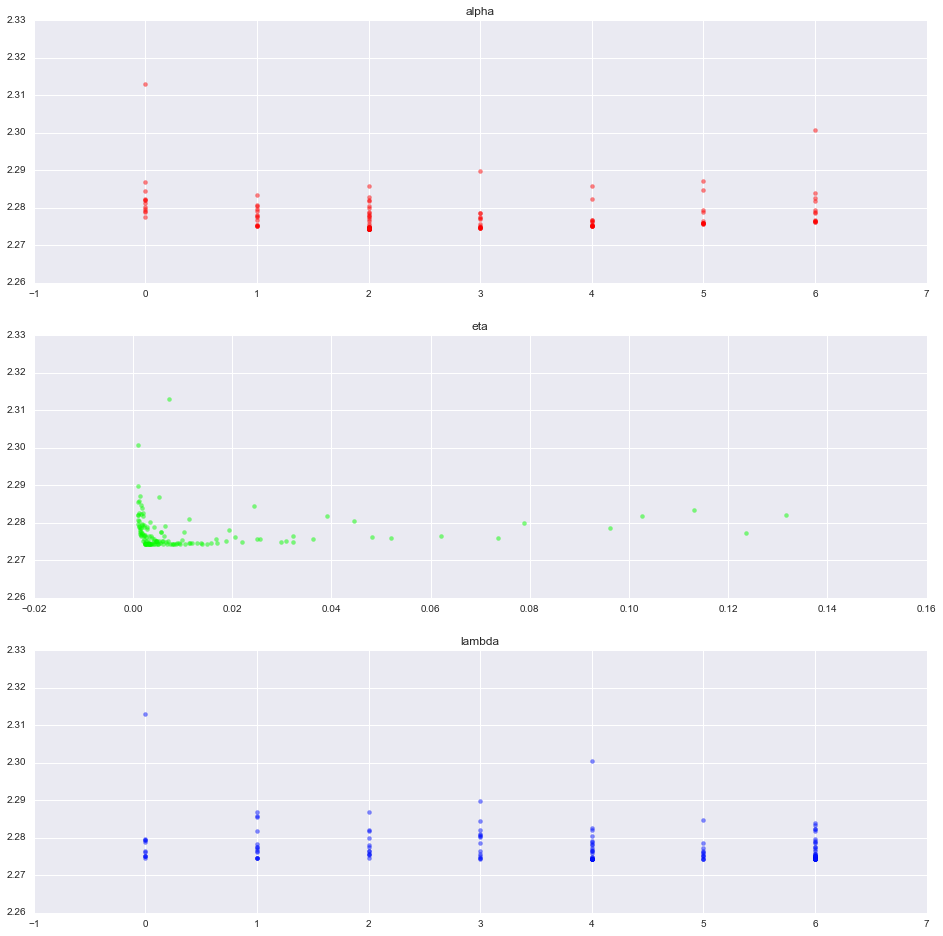

In [58]:
parameters = trials.trials[0]['misc']['vals'].keys()
f, axes = plt.subplots(nrows=len(parameters), ncols=1, figsize=(16,16))
cmap = plt.cm.hsv
par_best_score = {}
for i, val in enumerate(parameters):
    xs = np.array([t['misc']['vals'][val] for t in trials.trials if 'loss' in t['result']]).ravel()
    ys = [t['result']['loss'] for t in trials.trials if 'loss' in t['result']]
    
    par_best_score[val] = xs[ys.index(min(ys))]
    #print trials.trials[ys.index(max(ys))]
    print i, val, min(ys)
    #xs, ys = zip(sorted(xs), sorted(ys))
    #ys = np.array(ys)
    axes[i].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5, c=cmap(float(i)/len(parameters)))
    axes[i].set_title(val)
print par_best_score

0 alpha 2.27425154864
1 eta 2.27425154864
2 lambda 2.27425154864
{}


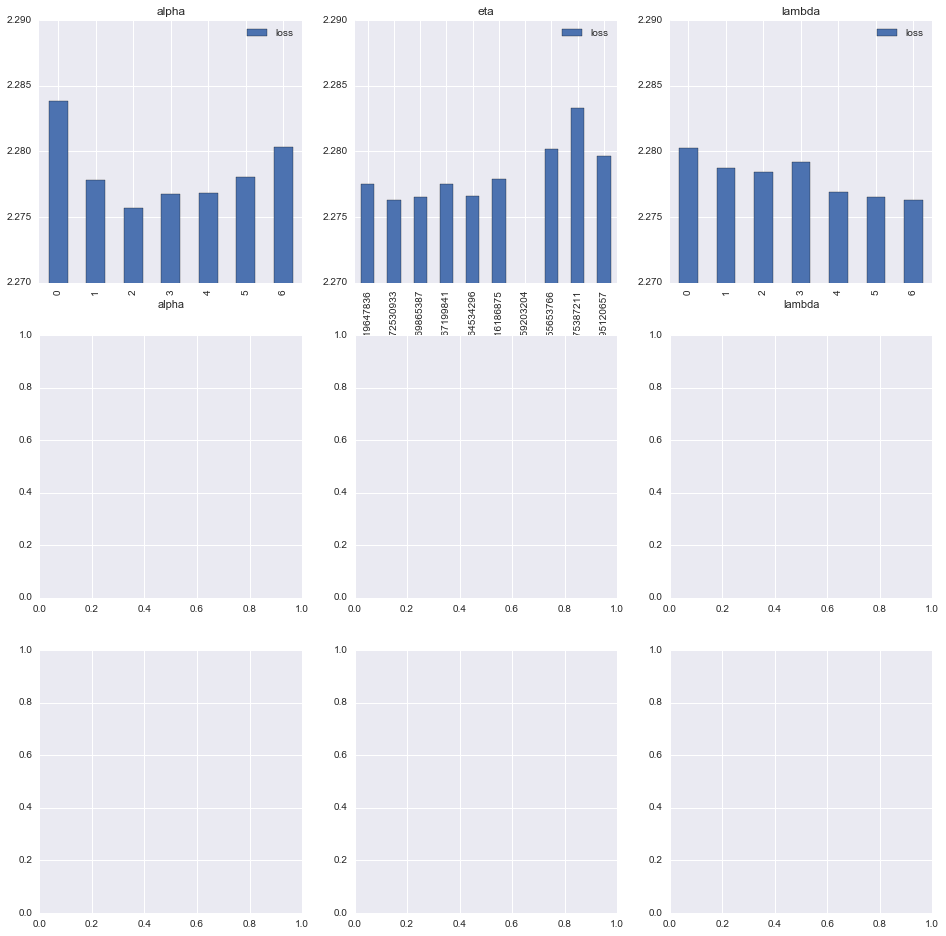

In [59]:
f, axes = plt.subplots(nrows=3, ncols=3, figsize=(16,16))
cmap = plt.cm.rainbow
par_best_score = {}
for i, val in enumerate(parameters):
    xs = np.array([t['misc']['vals'][val] for t in trials.trials if 'loss' in t['result']]).ravel()
    ys = [t['result']['loss'] for t in trials.trials if 'loss' in t['result']]
    
    #par_best_score[val] = xs[ys.index(max(ys))]
    #print trials.trials[ys.index(max(ys))]
    print i, val, min(ys)
    #xs, ys = zip(sorted(xs), sorted(ys))
    #ys = np.array(ys)
    a=pd.DataFrame({val:xs,'loss':ys})
    
    if a[val].nunique()>10:
        a[val] = pd.cut(a[val], 10, labels=np.linspace(a[val].min(),a[val].max(),10))
    #a[val] = a[val].round(0)
    (a.groupby(val).agg('mean')).plot(kind='bar',ylim=[2.27, 2.29], ax=axes[i/3,i%3])
    axes[i/3,i%3].set_title(val)
print par_best_score

In [60]:
trials.trials[0]

{'book_time': None,
 'exp_key': None,
 'misc': {'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'idxs': {'alpha': [0], 'eta': [0], 'lambda': [0]},
  'tid': 0,
  'vals': {'alpha': [2], 'eta': [0.03221821196364413], 'lambda': [6]},
  'workdir': None},
 'owner': None,
 'refresh_time': None,
 'result': {'loss': 2.274924020671339,
  'loss_train': 2.1607077556817282,
  'status': 'ok'},
 'spec': None,
 'state': 2,
 'tid': 0,
 'version': 0}

0 alpha 2.27425154864
1 eta 2.27425154864
2 lambda 2.27425154864
{}


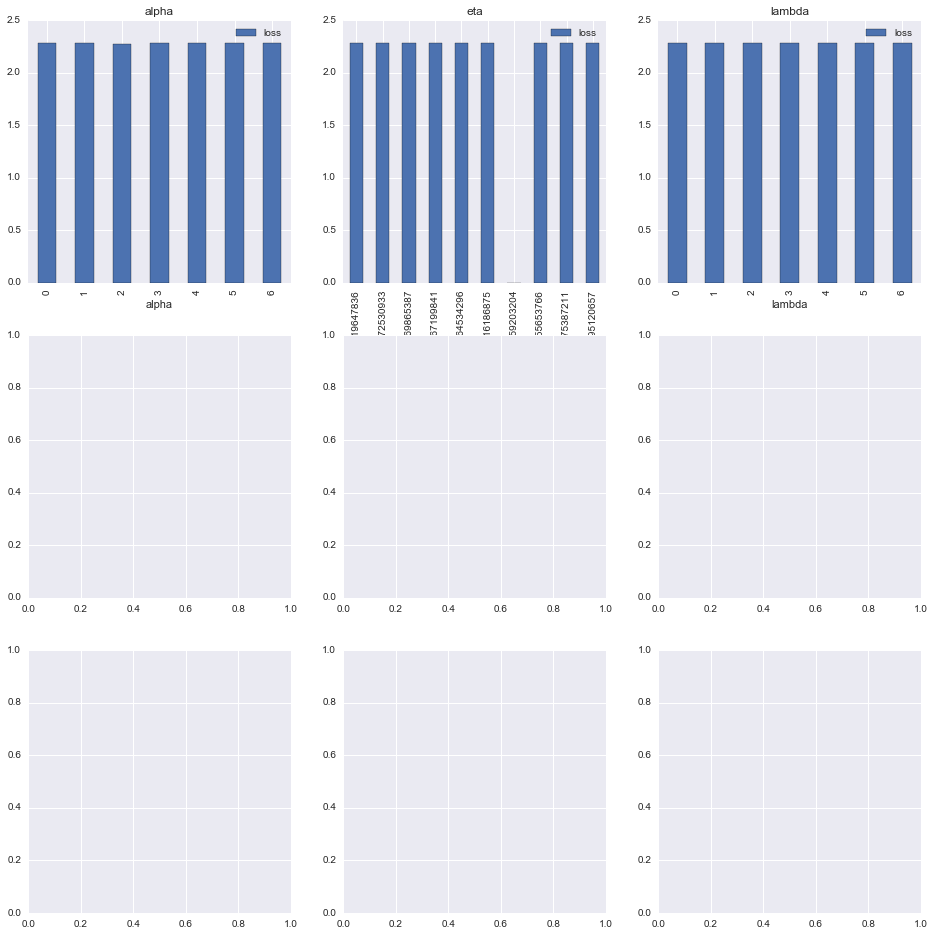

In [72]:
f, axes = plt.subplots(nrows=3, ncols=3, figsize=(16,16))
cmap = plt.cm.rainbow
par_best_score = {}
df=pd.DataFrame()
for i, val in enumerate(parameters):
    xs = np.array([t['misc']['vals'][val] for t in trials.trials if 'loss' in t['result']]).ravel()
    ys = [t['result']['loss'] for t in trials.trials if 'loss' in t['result']]
    ydiff = [t['result']['loss']-t['result']['loss_train'] for t in trials.trials if 'loss' in t['result']]
    #par_best_score[val] = xs[ys.index(max(ys))]
    #print trials.trials[ys.index(max(ys))]
    print i, val, min(ys)
    #xs, ys = zip(sorted(xs), sorted(ys))
    #ys = np.array(ys)
    a=pd.DataFrame({val:xs,'loss':ys})
    df[val] = xs
    df['loss'] = ys
    df['loss_diff'] = ydiff
    
    if a[val].nunique()>10:
        a[val] = pd.cut(a[val], 10, labels=np.linspace(a[val].min(),a[val].max(),10))
    #a[val] = a[val].round(0)
    (a.groupby(val).agg('mean')).plot(kind='bar', ax=axes[i/3,i%3])
    axes[i/3,i%3].set_title(val)
print par_best_score

In [73]:
from pandas.tools.plotting import scatter_matrix

In [74]:
df.sample()

alpha      loss  loss_diff       eta  lambda
87      2  2.274258   0.106102  0.004988       6

done


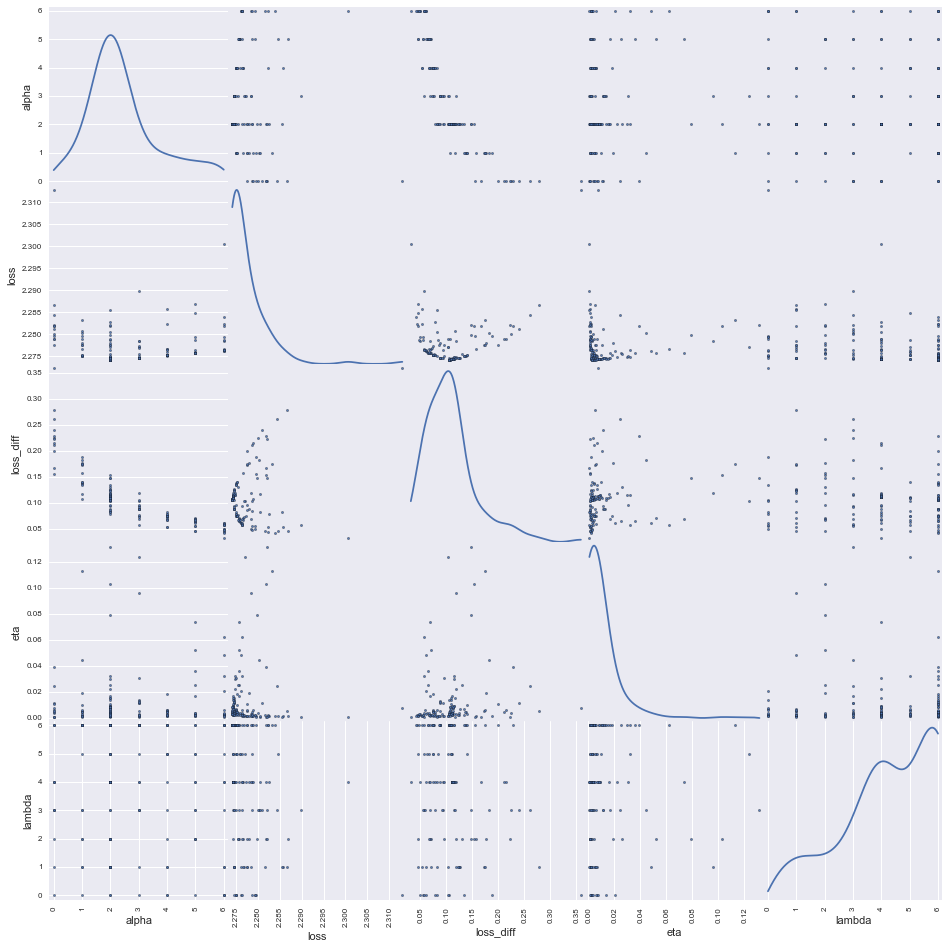

In [80]:
scatter_matrix(df, figsize=(16,16), alpha=0.9, diagonal='kde')
print('done')

In [81]:
df[df.loss_diff==df.loss_diff.min()]

alpha      loss  loss_diff       eta  lambda
79      6  2.300594   0.031726  0.000929       4

In [82]:
df[df.loss==df.loss.min()]

alpha      loss  loss_diff       eta  lambda
85      2  2.274252   0.105356  0.002873       6

In [88]:
df[(df.alpha==6) & (df['lambda']==6)]

alpha      loss  loss_diff       eta  lambda
60       6  2.282447   0.043088  0.002024       6
88       6  2.278772   0.048082  0.002873       6
97       6  2.276568   0.057397  0.061992       6
109      6  2.283893   0.041646  0.001843       6